# TOP BOTTOM - CHURN PROJECT

# IOT Method

## Input

### Business Case

1. Low purchase recurrence.
2. Customers ceasing to buy after a certain period.

## Output

1. What is the company's current Churn rate?
2. How does the churn rate vary by month?
3. What is the expected return in terms of revenue, if the company uses its model to avoid churn?
4. How does the model perform in classifying customers as churns?

## Tasks

1. What is the company's current Churn rate?
     - Annual, semiannual or monthly.
     - If 1 out of 20 customers cancel your product every month, that means the churn rate for your product will be 5%.
     - Find churn rate and do the monthly churn.

2. How does the churn rate vary by month?
     - Calculate monthly churn.
     - MRR CHURN = SUM (MRR of canceled customers)

3. What is the expected return in terms of revenue, if the company uses its model to avoid churn?
  - if this client is recovered how much he brings me based on salary
      - threshold
      - sorted list of people who are going to churn
      - which people to recover
      - LTV
      - Roc curve (live 21)

4. How does the model perform in classifying customers as churns?
     - Show Recall, Precision and Acc.
     - Search for different reporting metrics.
     - make the score

# CRISP-DM 

## Step 01 - data Description:
   - The objective is to use statistical metrics to identify outliers in the business scope.
## Step 02 - Feature Engineering:
   - Derive new attributes based on the original variables to better describe the phenomenon to be modeled.
## Step 03 - Data Filtering:
- Filter the rows and select the columns that do not contain information for modeling or that do not correspond to the scope of the business.
## Step 04 - Exploratory Data Analysis:
- Explore the data to find insights and better understand the impact of variables on model learning.
## Step 05 - Data Preparation:
- Prepare the data so that machine learning models can learn specific behaviors.
## Step 06 - Attribute Selection:
- Selection of the most significant attributes to train the model.
## Step 07 - Machine Learning Modeling:
- Machine learning model training
## Step 08 - Hyperparameter Fine Tunning:
- Choose the best values ​​for each of the parameters of the model selected in the previous step.
## Step 09 - Convert model performance into business values:
- Convert model performance into business results.
## Step 10 - Deploy the model to production:
- Publish the model to a cloud environment so that other people or services can use the results to improve their business decision.

# 0.0 IMPORTS

In [238]:
import os
import shap 
import mlflow
import pickle
import warnings
import inflection
import pandas                       as pd
import numpy                        as np
import seaborn                      as sns
import matplotlib.pyplot            as plt
import xgboost                      as xgb
import scikitplot                   as skplt
from yellowbrick.classifier         import ConfusionMatrix, ROCAUC, ClassificationReport, ClassPredictionError,PrecisionRecallCurve
from IPython.core.display           import HTML
from sklearn                        import preprocessing
from sklearn.preprocessing          import RobustScaler,StandardScaler, MinMaxScaler
from sklearn                        import model_selection    as ms
from sklearn.ensemble               import RandomForestRegressor
from sklearn.linear_model           import LogisticRegression
from boruta                         import BorutaPy
from BorutaShap                     import BorutaShap
from scipy.stats                    import chi2_contingency,shapiro
from sklearn.metrics                import accuracy_score, classification_report
from scikitplot.metrics             import plot_cumulative_gain, plot_lift_curve, plot_ks_statistic, plot_calibration_curve
from imblearn                       import under_sampling as us
from imblearn                       import over_sampling  as oversamp
from imblearn                       import combine        as c
from imblearn.over_sampling         import KMeansSMOTE as ksmt
from catboost                       import CatBoostClassifier, Pool
from sklearn.tree                   import DecisionTreeClassifier
from sklearn.ensemble               import RandomForestClassifier
from sklearn.svm                    import SVC
from sklearn                        import neighbors          as nh
from sklearn.naive_bayes            import GaussianNB
from yellowbrick.contrib.wrapper    import wrap
from sklearn.metrics                import recall_score
from sklearn.metrics                import precision_score
from sklearn.metrics                import *
from sklearn.model_selection        import StratifiedKFold, learning_curve


# MLFlow server
churn_server='http://0.0.0.0:8000/'

# Local path to save model
root_artifact = '/home/tc0019/DS/mlruns/'
# root_artifact ='/mlflow/mlflow-artifacts/0'

# set registry and track of models
mlflow.set_registry_uri(churn_server)
mlflow.set_tracking_uri(churn_server)

# set experiment name displayed on MLFLOW UI
mlflow.set_experiment('Bank Customers Churn Predictions')


<Experiment: artifact_location='file:///home/tc0019/mlruns/4', experiment_id='4', lifecycle_stage='active', name='Bank Customers Churn Predictions', tags={}>

##  Helper Functions

In [239]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()
warnings.filterwarnings("ignore")


def plot_corr(col):
    #Function to plot correlation of a column 
    a = correlation[col].sort_values(ascending=False).to_frame()
    a.columns = ['']
    a.drop(col, axis=0, inplace=True)
    plot = sns.heatmap( a, annot=True, cmap='Greens').set_title(col);
    
    return plot


def cramer_v(x, y):
    # cramer V function to calculate correlation btw categorical variables
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


def rocauc(model, class_0 = 'not churn', class_1 = 'churn'):

    """
    Creates the ROC-AUC curve using yellowbrick.

    Args:
        model: [The Machine Learning algorithm utilized]
        class_0[str]: Name of the class 0
        class_1[str]: Name of the class 1

    Returns:
        [Image]: [ROC-AUC curve]
    """

    roc = ROCAUC(wrap(model), classes=[class_0, class_1], micro = False, macro = False)
    roc.fit(X_train, y_train)  
    roc.score(x_validation, y_validation)  
    ax = roc.finalize()
    


    return ax

def confusion_matrix1(model): 
    
    """
    Creates a confusion matrix plot with churn and not churn using yellowbrick.

    Args:
        model: [The Machine Learning algorithm utilized]

    Returns:
        [Image]: [The confusion matrix plot]
    """

    confusion_matrix = ConfusionMatrix(wrap(model), classes = ['not churn', 'churn'], cmap = 'Greens')
    confusion_matrix.fit(X_train, y_train)  
    confusion_matrix.score(x_validation, y_validation)  
    ax = confusion_matrix.finalize()

    return ax


def plot_learning_curve(model, name, X, y, n_split):

    """
    Creates a plot with the learning curve of a model comparing simple and cross validation learning

    Args:
        model: [The Machine Learning algorithm utilized]
        name: [The name of the model]
        X: Features
        Y: Target Feature
        n_split: Number of splits in StratifiedKFold

    Returns:
        [Image]: [Learning Curve]
    """

    train_sizes = np.linspace(.1, 1.0, 5)
    cv = StratifiedKFold(n_splits = n_split, random_state = 42, shuffle = True)

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(model, X, y, cv = cv, n_jobs = -1, train_sizes = train_sizes, return_times = True)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    fit_times_mean = np.mean(fit_times, axis = 1)
    fit_times_std = np.std(fit_times, axis = 1)

    # Plot learning curve
    plt.plot(train_sizes, train_scores_mean, 'o-', color = '#1F77B4', label = 'Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color = '#FF7F0E', label = 'Cross-validation score')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = '#1F77B4')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = '#FF7F0E')
    plt.legend(loc = 'best')
    plt.title(name)
    plt.xlabel('Training Instances')
    plt.ylabel('Score')

    return plt


def descriptive_statistics(df1_num):

    """
    Shows the main values ​​for descriptive statistics in numerical variables.

    Args:
        data ([float64 and int64]): [Insert all numerical attributes in the dataset]

    Returns:
        [dataframe]: [A dataframe with mean, median, std deviation, skewness, kurtosis, min, max and range]
    """
    
    # Central Tendency - mean, meadina
    ct1= pd.DataFrame(df1_num.apply(np.mean)).T
    ct2= pd.DataFrame(df1_num.apply(np.median)).T

    # dispersion - std, min, max, range, skew, kurtosis
    ct3= pd.DataFrame(df1_num.apply(np.std)).T
    ct4= pd.DataFrame(df1_num.apply(min)).T
    ct5= pd.DataFrame(df1_num.apply(max)).T
    ct6= pd.DataFrame(df1_num.apply(lambda x: x.max() - x.min())).T
    ct7= pd.DataFrame(df1_num.apply(lambda x: x.skew())).T
    ct8= pd.DataFrame(df1_num.apply(lambda x: x.kurtosis())).T
    ct9 = pd.DataFrame(df1_num.apply(lambda x: 'not normal' if shapiro(x.sample(5000))[1] < 0.05 else 'normal')).T


    # concatenar
    df_statistics= pd.concat([ct4, ct5, ct6, ct1, ct2,ct3, ct7, ct8, ct9]).T
    df_statistics.columns=['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', 'shapiro']
    df_statistics.round(2)

    return df_statistics


def model_metrics(models, y_test):
    """Calculate Precision, Recall and F1

    Args:
        models[list]: [List of Machine Learning Algorithms]
        y_test: [Target Feature Test DataFrame]

    Returns:
        [DataFrame]: [DataFrame with metrics]
    """

    result_df = []
    for model in models:
        # model prediction
        model_name = type(model).__name__
        yhat = model.predict(x_validation)
        yhat_proba = model.predict_proba(x_validation)
        yhat_proba = yhat_proba[:, 1]
        accuracy = accuracy_score(y_test, yhat)
        precision = precision_score(y_test, yhat)
        recall = recall_score(y_test, yhat)
        f1 = f1_score(y_test, yhat)
        rocauc = roc_auc_score(y_test, yhat_proba)
        model_metrics = pd.DataFrame( { 'Model Name': model_name,
                                        'Accuracy': accuracy,
                                        'Precision': precision,
                                        'Recall': recall,
                                        'F1-Score': f1,
                                        'ROCAUC': rocauc},  index = [0])
        result_df.append(model_metrics)

    result = pd.concat(result_df)
    
    return result.reset_index(drop=True)



def classification_report1(model):
    
        """Creates a classification report plot with churn and not churn, precision recall and F1 scores using yellowbrick.

        Args:
            model: [The Machine Learning algorithm utilized]

        Returns:
            [Image]: [The classification report plot]"""

        report = ClassificationReport(model, classes=['Not churn', 'Churn'], cmap = 'Greens')
        report.fit(X_train, y_train)  
        report.score(x_validation, y_validation)  
        report.finalize()

        return a


def plot_learning_curve(model, name, X, y, n_split):

    """
    Creates a plot with the learning curve of a model comparing simple and cross validation learning

    Args:
        model: [The Machine Learning algorithm utilized]
        name: [The name of the model]
        X: Features
        Y: Target Feature
        n_split: Number of splits in StratifiedKFold

    Returns:
        [Image]: [Learning Curve]
    """

    train_sizes = np.linspace(.1, 1.0, 5)
    cv = StratifiedKFold(n_splits = n_split, random_state = 42, shuffle = True)

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(model, X, y, cv = cv, n_jobs = -1, train_sizes = train_sizes, return_times = True)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    fit_times_mean = np.mean(fit_times, axis = 1)
    fit_times_std = np.std(fit_times, axis = 1)

    # Plot learning curve
    plt.plot(train_sizes, train_scores_mean, 'o-', color = '#1F77B4', label = 'Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color = '#FF7F0E', label = 'Cross-validation score')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = '#1F77B4')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = '#FF7F0E')
    plt.legend(loc = 'best')
    plt.title(name)
    plt.xlabel('Training Instances')
    plt.ylabel('Score')

    return plt

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


##  Get Data from Database

##  Load dataset

In [240]:
df_raw=pd.read_csv('/home/tc0019/DS/topbottombank/data/churn.csv')
df_raw.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited
0          1    15634602  Hargrave          619    France  Female   42       2       0.00              1          1               1        101348.88       1
1          2    15647311      Hill          608     Spain  Female   41       1   83807.86              1          0               1        112542.58       0
2          3    15619304      Onio          502    France  Female   42       8  159660.80              3          1               0        113931.57       1
3          4    15701354      Boni          699    France  Female   39       1       0.00              2          0               0         93826.63       0
4          5    15737888  Mitchell          850     Spain  Female   43       2  125510.82              1          1               1         79084.10       0

#  1.0 DATA DESCRIPTION

In [241]:
df1=df_raw.copy()

## 1.1. Rename Columns

All columns will be renamed to snake case: https://en.wikipedia.org/wiki/Snake_case.

The main objective is create a columns name pattern to make simple dealing with the dataset.

In [242]:
df1.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [243]:
cols_old=['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

## 1.2. Data Dimensions

In [244]:
print( f'Number of Rows: {df1.shape[0]}')
print( f'Number of Columns: {df1.shape[1]}')

Number of Rows: 10000
Number of Columns: 14


## 1.3. Data Types

In [245]:
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.4. Check NA

 The dataset has no occurrence of NAs

In [246]:
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5. Descriptive Statistics

In [247]:
df1_num=df1.select_dtypes(include=['int64', 'float64'])
df1_cat=df1.select_dtypes(exclude=['int64', 'float64', 'datetime'])

### 1.5.1. Numerical Atributes

In [248]:
descriptive_statistics(df1_num)

min         max      range           mean      median           std      skew  kurtosis     shapiro
row_number               1.0     10000.0     9999.0         5000.5      5000.5   2886.751332       0.0      -1.2  not normal
customer_id       15565701.0  15815690.0   249989.0  15690940.5694  15690738.0  71932.589224  0.001149 -1.196113  not normal
credit_score           350.0       850.0      500.0       650.5288       652.0     96.648466 -0.071607 -0.425726  not normal
age                     18.0        92.0       74.0        38.9218        37.0     10.487282   1.01132  1.395347  not normal
tenure                   0.0        10.0       10.0         5.0128         5.0       2.89203  0.010991 -1.165225  not normal
balance                  0.0   250898.09  250898.09   76485.889288    97198.54  62394.285254 -0.141109 -1.489412  not normal
num_of_products          1.0         4.0        3.0         1.5302         1.0      0.581625  0.745568  0.582981  not normal
has_cr_card              0.0         1.0        1.0         0.7055         1.0      0.455818 -0.901812 -1.186973  not normal
is_active_member         0.0         1.0        1.0         0.5151         1.0      0.499772 -0.060437 -1.996747  not normal
estimated_salary       11.58   199992.48   199980.9  100090.239881  100193.915  57507.617221  0.002085 -1.181518  not normal
exited                   0.0         1.0        1.0         0.2037         0.0      0.402748  1.471611  0.165671  not normal

**Relavants Observations:**

**credit_score** may be better work in a categorical way to group people in classes

**estimated_salary** will be considered as annual salary, the value 11.50 must be checked it may be an input error.

**none** of the features have normal distribution

### 1.5.2 Categorical Attributes

**Gender** do not show to be a significant attribute to consider churn

**Geography** has similar churn, nothing seems to extrapolate due geo.

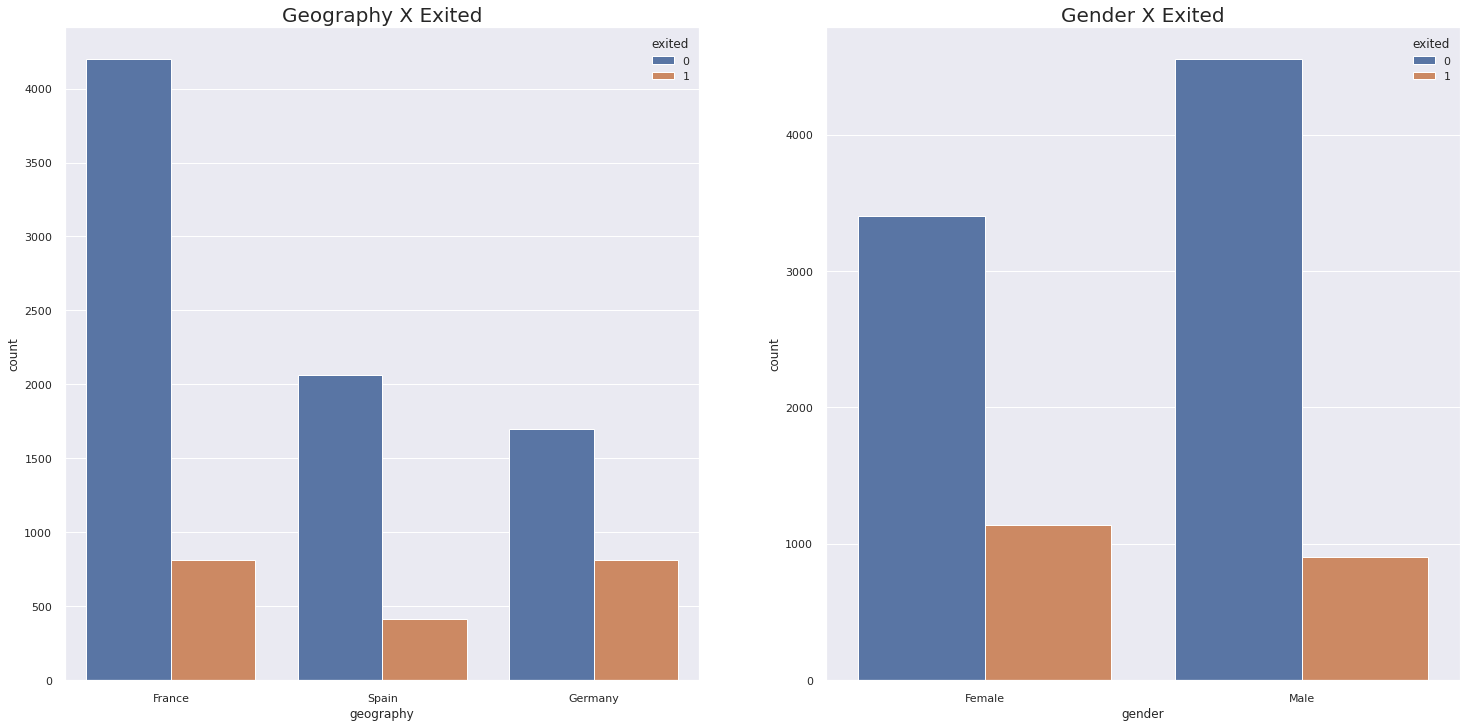

In [249]:
plt.subplot(1,2,1)
sns.countplot(x='geography', hue='exited', data=df1).set_title('Geography X Exited', fontsize=20);

plt.subplot(1,2,2)
sns.countplot(x='gender', hue='exited', data=df1).set_title('Gender X Exited', fontsize=20);

### 1.5.3 Target Variable

The dataset is unbalanced. Smote Tomek may be used here.

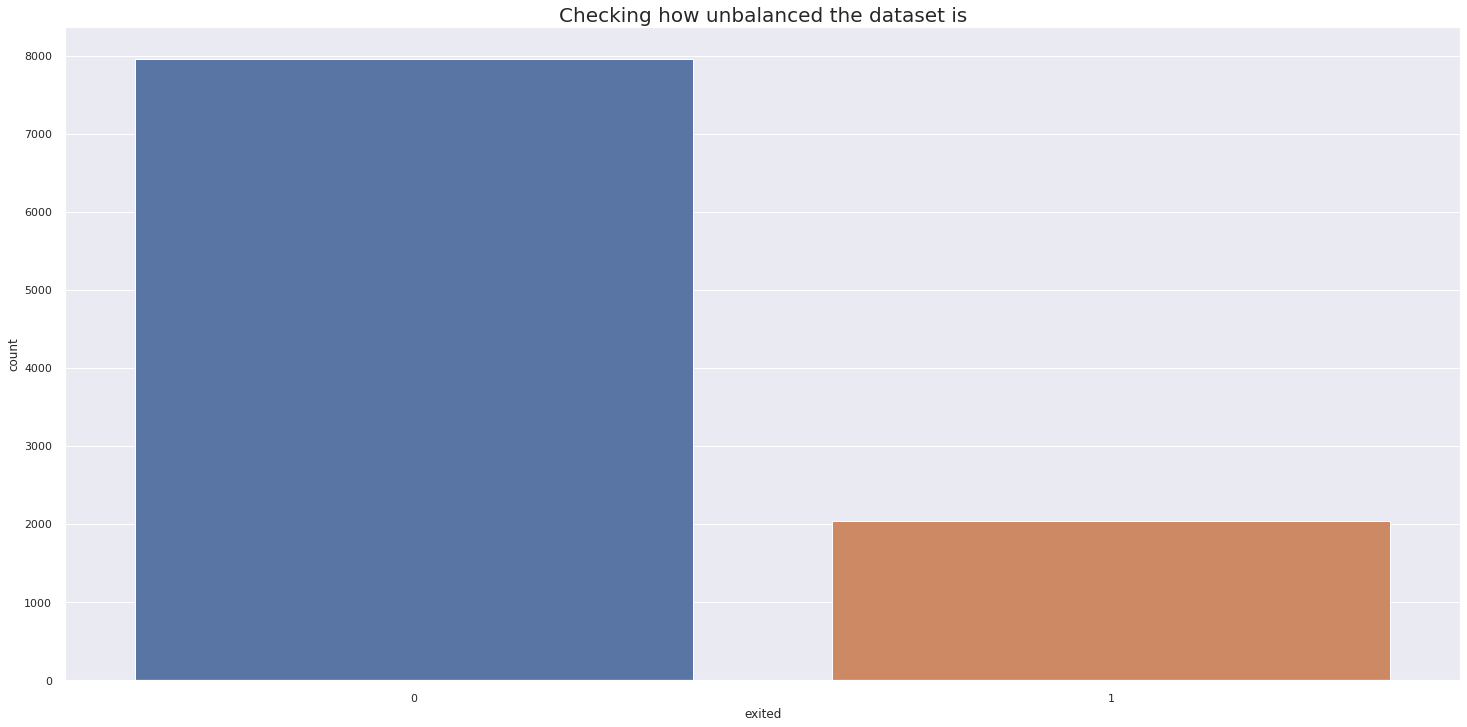

In [250]:
sns.countplot(x='exited', data=df1).set_title('Checking how unbalanced the dataset is', fontsize=20);

# 2.0 FEATURE ENGINEERING

In [251]:
df2 = df1.copy()

## 2.1 Hypothesis Mental Map


###  2.1.1 Hypotheses List

1. Os usuarios com score maior que 800 tem mais dinheiro em media. 
2. A espanha possue o maior numero de cartoes de credito da base de dados.
3. O publico feminino possui o score maior do que o masculino. 
4. Homens possuem mais dinheiro do que mulheres no banco.
5. O salario estimados das mulherem em media eh maior do que dos homens.
6. Pessoas que moram na alemanha em media sao mais ativos que os demais.
7. Os clientes com cadastro ativo sao maioria mulheres. 
8. Os clientes com maior numero de tenure comprados sao os que tem o menor salario estiamdo.
9. Pessoas que possuem cartao sao mais ativas do que as que nao possuem mais.
10. Salarios acima de 80k permanecem em media 3 anos.
11. Os alemaes possuem o maior salario da base.
12. Pessoas com balancos superior a 70k sao menos propensas ao churn.
13. Pessoas com score superior a 780 nao deixam a empresa.
14. Pessoas da franca entram sao mais propensos a entrar em churn do que as demais.
15. Homens entram em churn mais do que mulheres.
16. Pessoas acima dos 35 sao mais propensas a sairem da empresa.
17. Homens acima 40 anos e sem atividade no site sao mais propensos ao churn.
18. Mulheres abaixo dos 30 anos tem 70% de chance de NAO abandonar a empresa.
19. Homens com 40 anos e sem atividade no site sao mais propensos ao churn.
20. Mulheres com score acima dos 800 e balance acima de 80k tem 90% de NAO abandonar a empresa.
21. Pessoas com tenure acima de 8 tem 60% de pessoas ativa no site.



###  2.1.2 Hypotheses Final List

1. Os usuarios com score maior que 800 em media tem mais dinheiro no banco.
2. A espanha possue o maior numero de cartoes de credito da base de dados.
3. O publico feminino possui o score maior do que o masculino. 
4. Homens possuem mais dinheiro do que mulheres no banco.
5. O salario estimados das mulherem em media eh maior do que dos homens.
6. Pessoas que moram na alemanha em media sao mais ativos que os demais.


## 2.2 Feature Engineering
- 2nd cycle try to apply credit_score as categorical to catboost

In [252]:
df2['balance_by_age']=df2['balance']/df2['age']
df2['num_of_prod_by_age']=df2['num_of_products']/df2['age']
df2['balance_by_num_of_prod']=df2['balance']/df2['num_of_products']
df2['credit_score_by_age']=df2['credit_score']/df2['age']
df2['estimated_salary_by_age']=df2['estimated_salary']/df2['age']
df2['balance_by_age']=df2['balance']/df2['age']
df2.head()

row_number  customer_id   surname  credit_score geography  gender  age  tenure    balance  num_of_products  has_cr_card  is_active_member  estimated_salary  exited  balance_by_age  num_of_prod_by_age  balance_by_num_of_prod  credit_score_by_age  estimated_salary_by_age
0           1     15634602  Hargrave           619    France  Female   42       2       0.00                1            1                 1         101348.88       1        0.000000            0.023810                0.000000            14.738095              2413.068571
1           2     15647311      Hill           608     Spain  Female   41       1   83807.86                1            0                 1         112542.58       0     2044.094146            0.024390            83807.860000            14.829268              2744.940976
2           3     15619304      Onio           502    France  Female   42       8  159660.80                3            1                 0         113931.57       1     3801.447619            0.071429            53220.266667            11.952381              2712.656429
3           4     15701354      Boni           699    France  Female   39       1       0.00                2            0                 0          93826.63       0        0.000000            0.051282                0.000000            17.923077              2405.811026
4           5     15737888  Mitchell           850     Spain  Female   43       2  125510.82                1            1                 1          79084.10       0     2918.856279            0.023256           125510.820000            19.767442              1839.165116

#  3.0 DATA FILTERING

 Some variables won't be useful understanding the dataset nor to create the machine learning model, then I will remove it.


In [253]:
df3 = df2.copy()
cols_drop = ['row_number','customer_id','surname']
df3 = df3.drop(cols_drop, axis=1)

In [254]:
# take a look in these customers
df3[df3['balance']==0.00].shape[0]


3617

# 4.0 EXPLANATORY DATA ANALYSIS

In [255]:
df4 = df3.copy()

## 4.1. Analise Univariada
plot always distplot e boxplot with plt subplot, and make observation

### 4.1.1 Credit Score
- Even though this feature seems to be a normal distribuiton in shapiro test earlier showed not normal.

- A normalization can be tested (Standardization can become skewed or biased if the input variable contains outlier values.)

- To overcome this, the median and interquartile range can be used when standardizing numerical input variables, generally referred to as robust scaling.

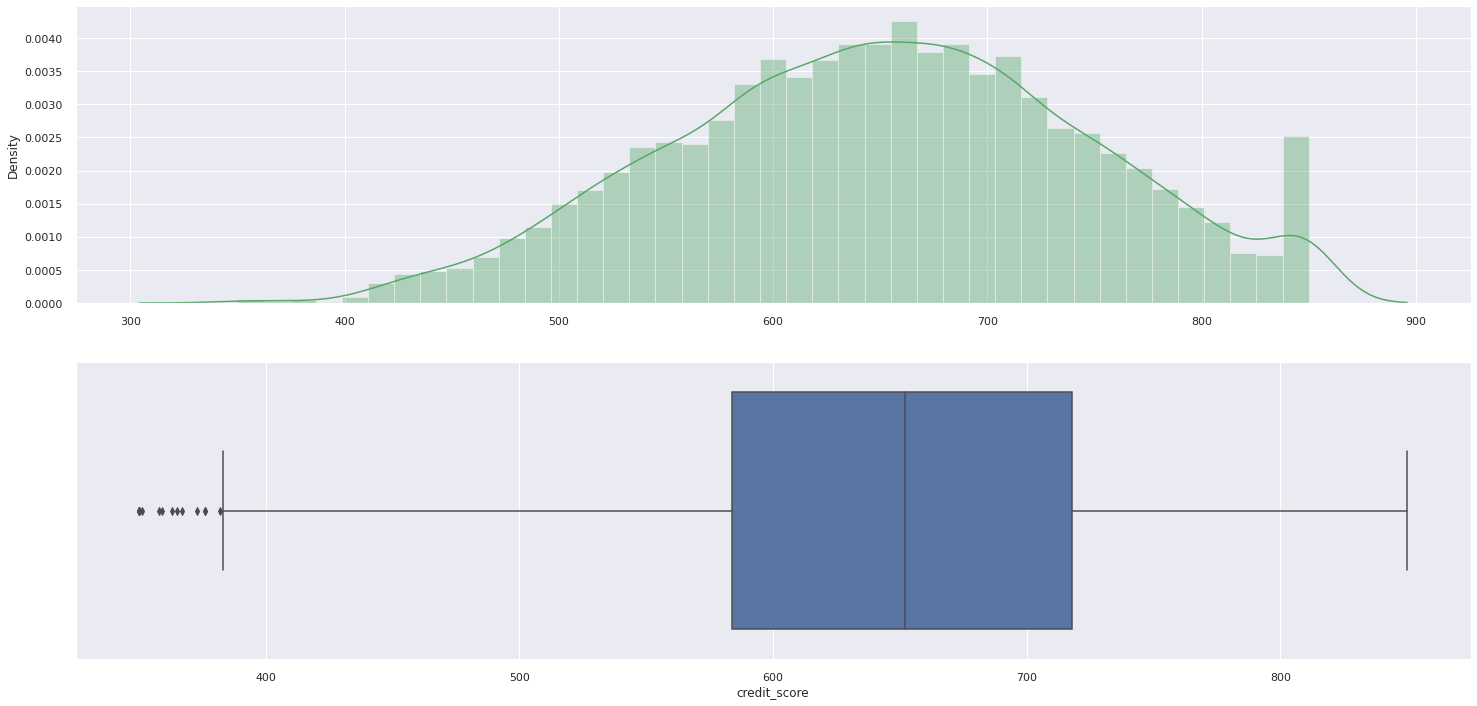

In [256]:
plt.subplot(2,1,1)
sns.set_color_codes()
sns.distplot(x=df1['credit_score'], color='g');

plt.subplot(2,1,2)
sns.boxplot(x=df1['credit_score']);


### 4.1.2 Geography

- Geo must have a closer look when comparade to exited.

- France can cause an unbalance in target

- Analysis done on topic 1.5.2 with the conclusion: churn isnt attached to geo

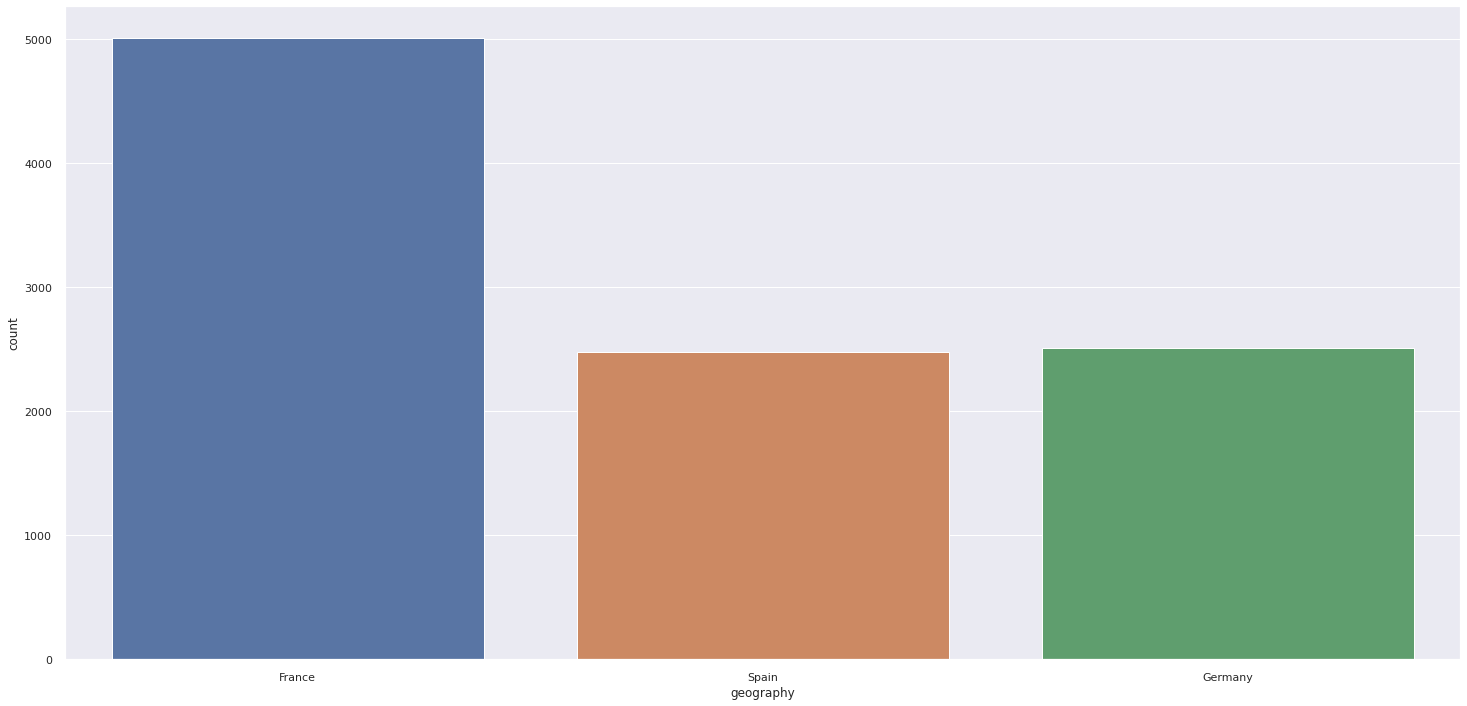

In [257]:

x=df4['geography']

sns.countplot(x=x);

### 4.1.3 Gender

- **Gender** do not show to be a significant attribute to consider churn
- Men give slightly more churn than women.

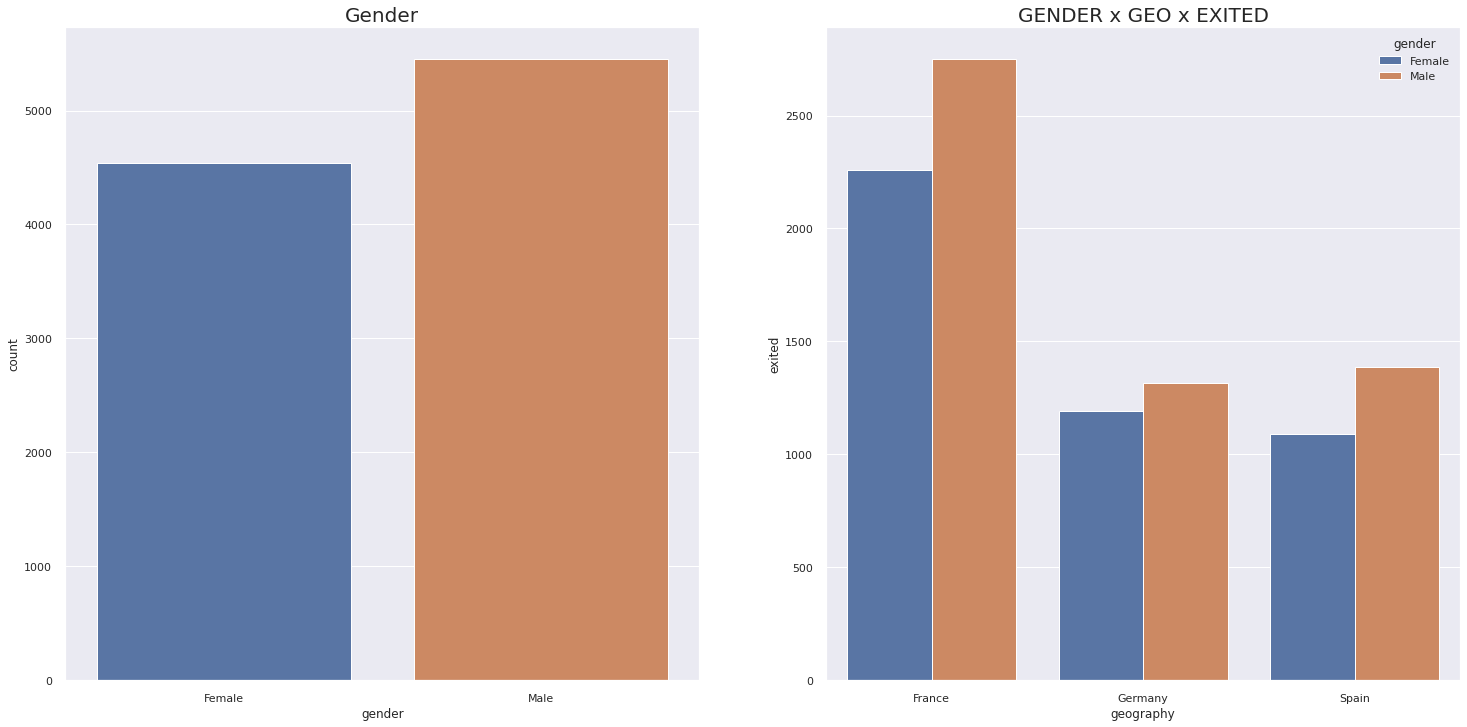

In [258]:
plt.subplot(1,2,1)
x=df4['gender']
sns.countplot(x=x).set_title('Gender', fontsize=20);


plt.subplot(1,2,2)
auxgen=df4[['geography', 'gender', 'exited']].groupby(['geography','gender']).count().reset_index()
sns.barplot(x = 'geography', hue= 'gender', y = 'exited', data=auxgen).set_title('GENDER x GEO x EXITED', fontsize=20);

### 4.1.4 Age
- It's notorious that older clients tend to churn more.
- The most common age is 37.

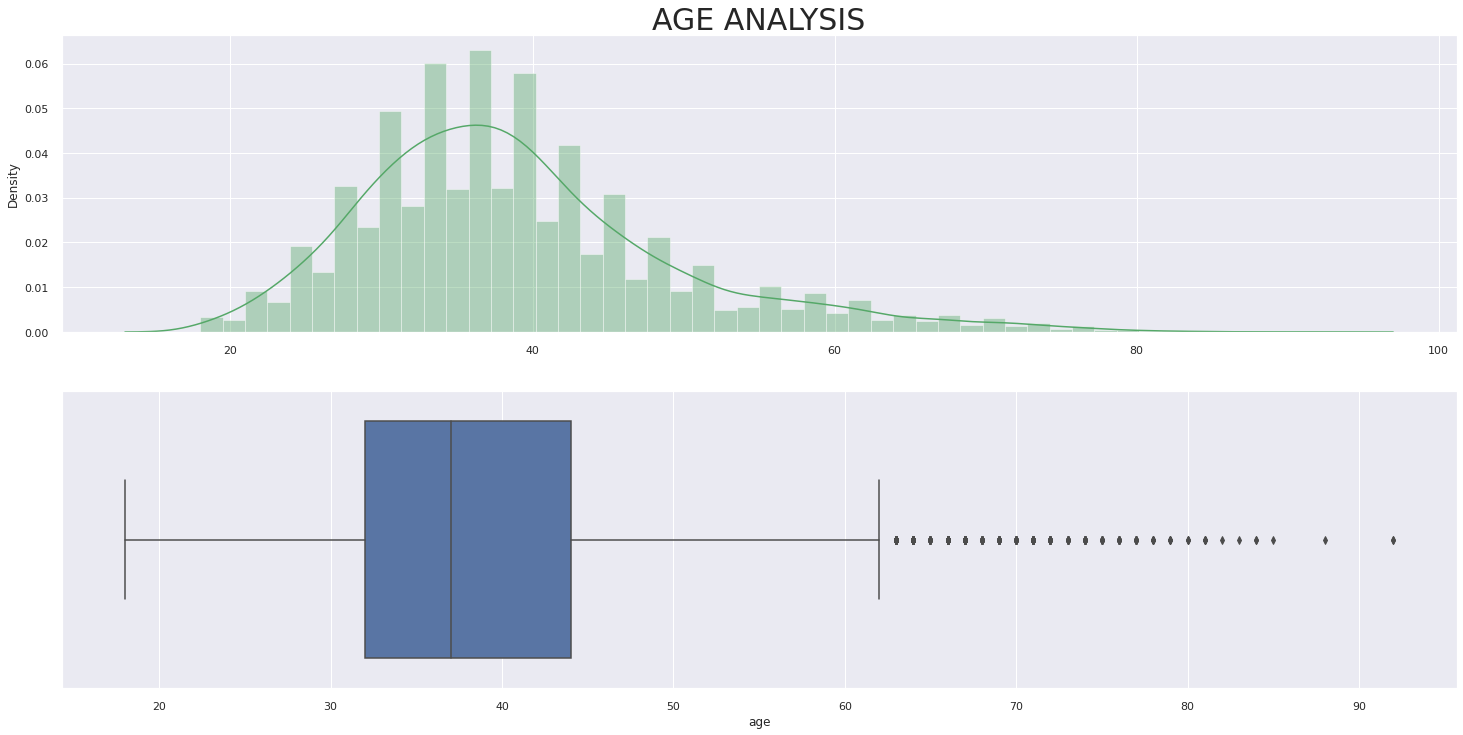

In [259]:
plt.subplot(2,1,1)
sns.set_color_codes()
sns.distplot(x=df1['age'], color='g').set_title('AGE ANALYSIS', fontsize=30);

plt.subplot(2,1,2)
sns.boxplot(x=df4['age']);

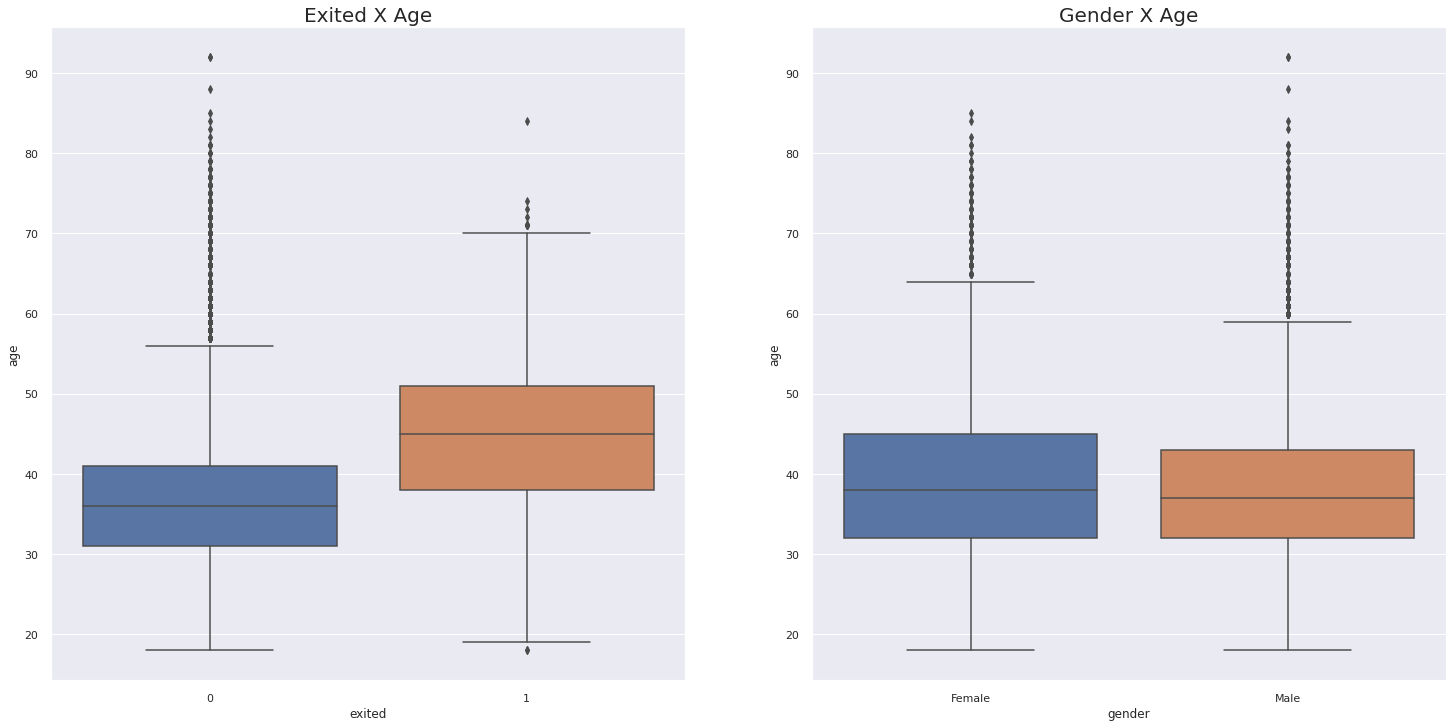

In [260]:
plt.subplot(1,2,1)
sns.boxplot(x='exited', y='age', data=df4).set_title('Exited X Age', fontsize=20);

plt.subplot(1,2,2)
sns.boxplot(x='gender', y='age', data=df4).set_title('Gender X Age', fontsize=20);


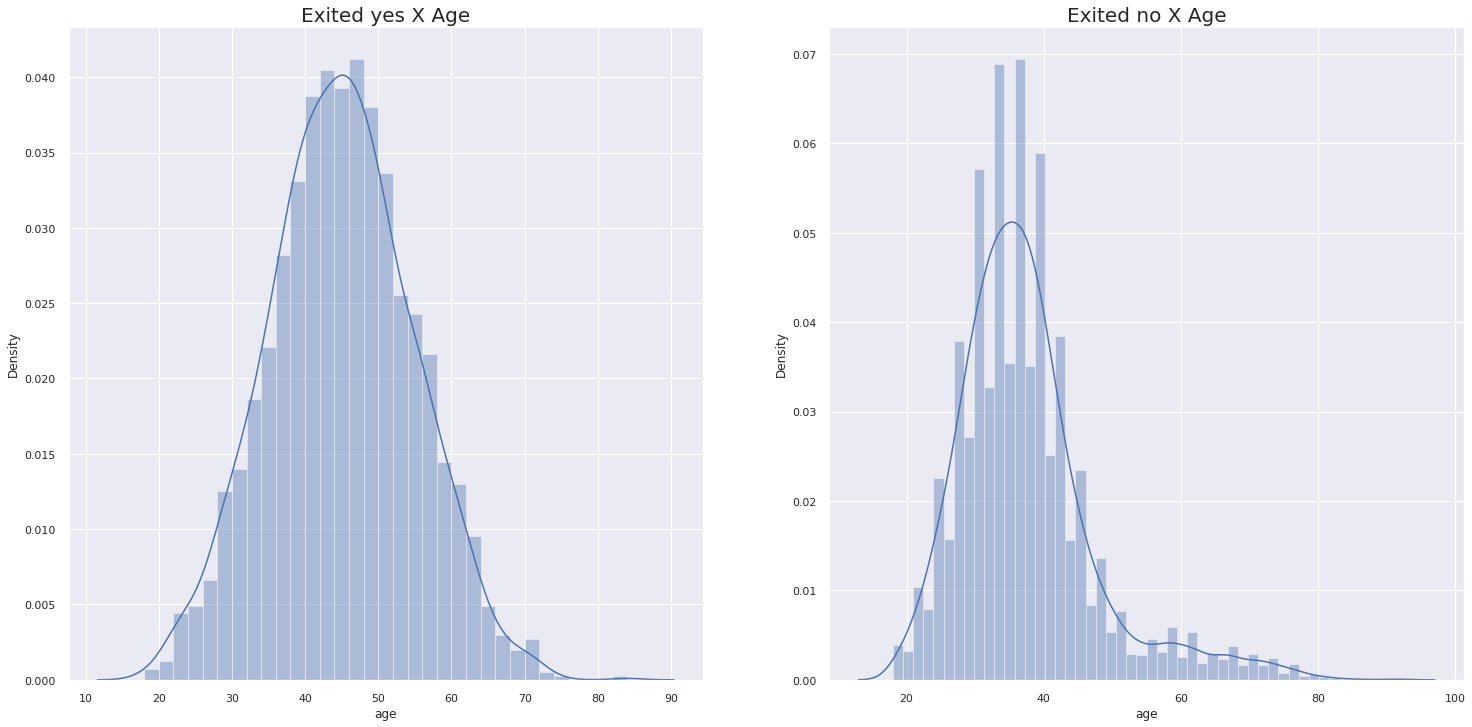

In [261]:
plt.subplot(1,2,1)
aux=df4.loc[df4['exited']==1,'age']
sns.distplot(aux).set_title('Exited yes X Age', fontsize=20);

plt.subplot(1,2,2)
aux1=df4.loc[df4['exited']==0, 'age']
sns.distplot(aux1).set_title('Exited no X Age', fontsize=20);

### 4.1.5 Tenure

- It has a unitary distribution

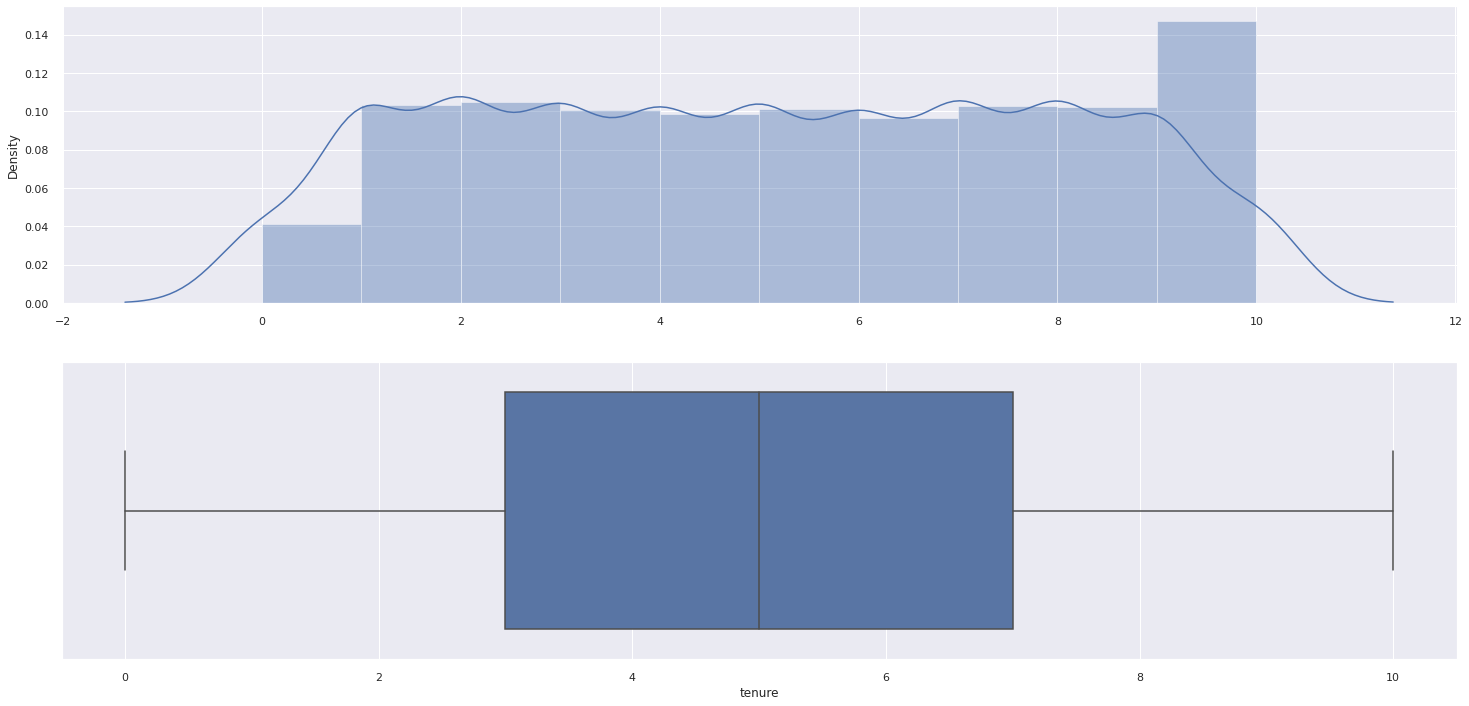

In [262]:
plt.subplot(2,1,1);
sns.distplot(x=df1['tenure'], bins=10);

plt.subplot(2,1,2);
sns.boxplot(x='tenure', data=df4);


### 4.1.6 Estimated Salary
- It has a unitary distribution

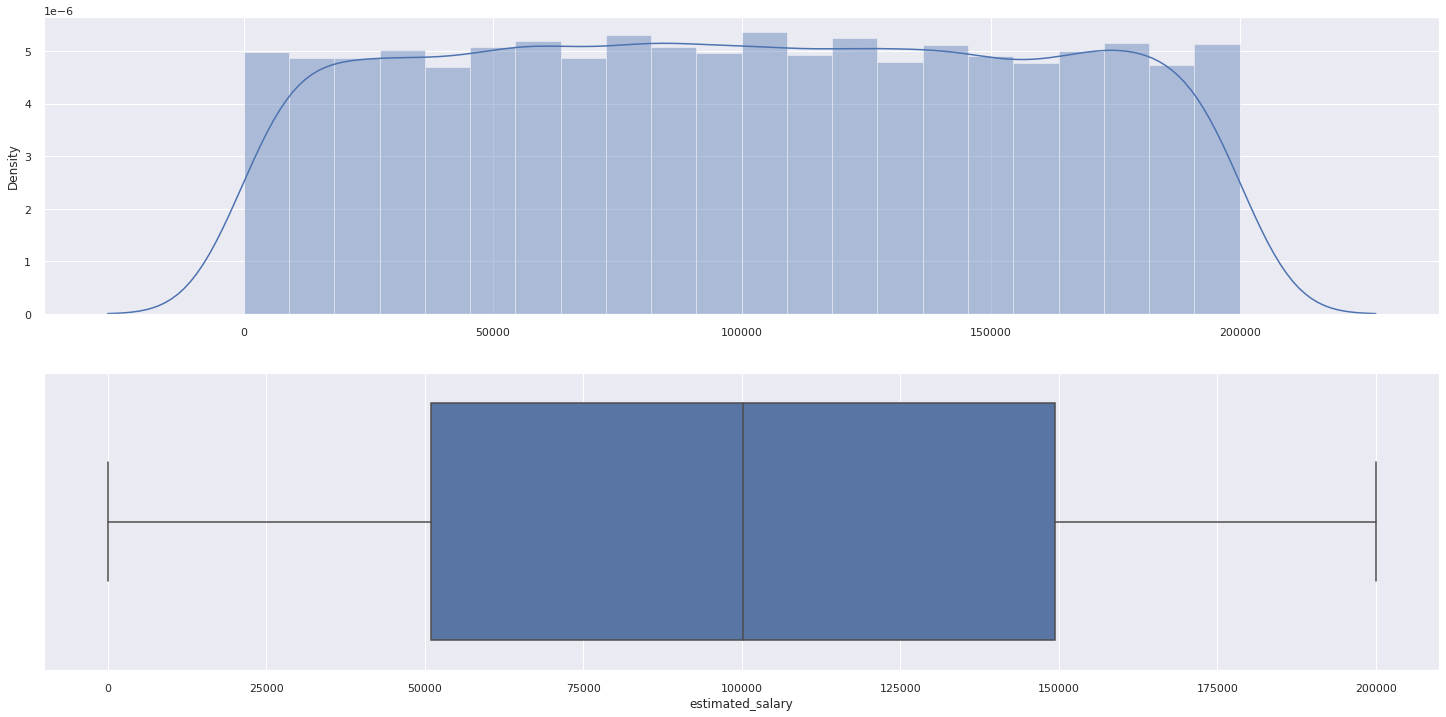

In [263]:

plt.subplot(2,1,1);
sns.distplot(x=df4['estimated_salary']);


plt.subplot(2,1,2);
sns.boxplot(x='estimated_salary', data=df4);

### 4.1.7 Exited

- It's unballanced, here can be a problem. The ML models can interpet class 0 (no churn) and learn more about this class than the main class 1(Churn) that represents the phenomenon we are trying to predict.

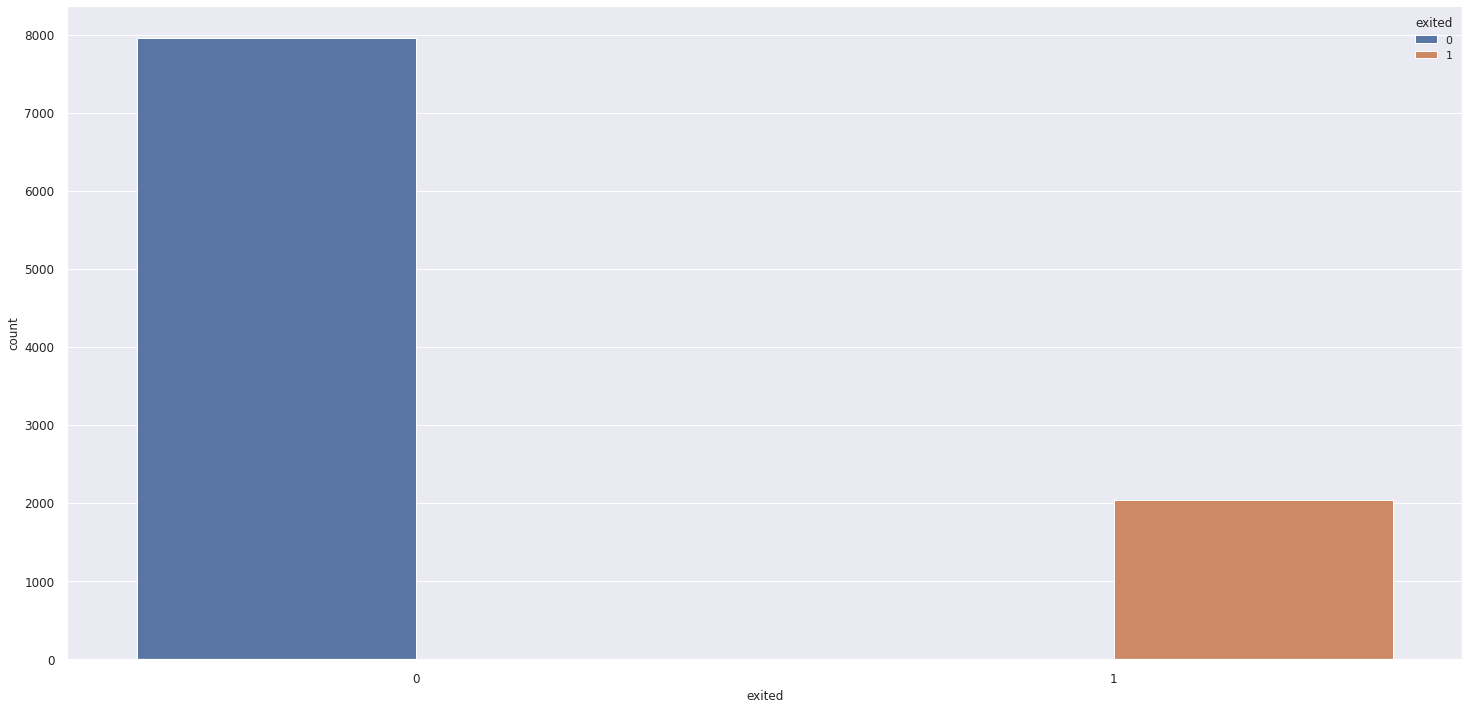

In [264]:
ax1 = sns.countplot(x='exited',hue='exited', data=df2);
plt.xticks(size=12);
plt.xlabel('exited', size=12);
plt.yticks(size=12);
plt.ylabel('count', size=12);

### 4.1.8 Numerical Attributes 

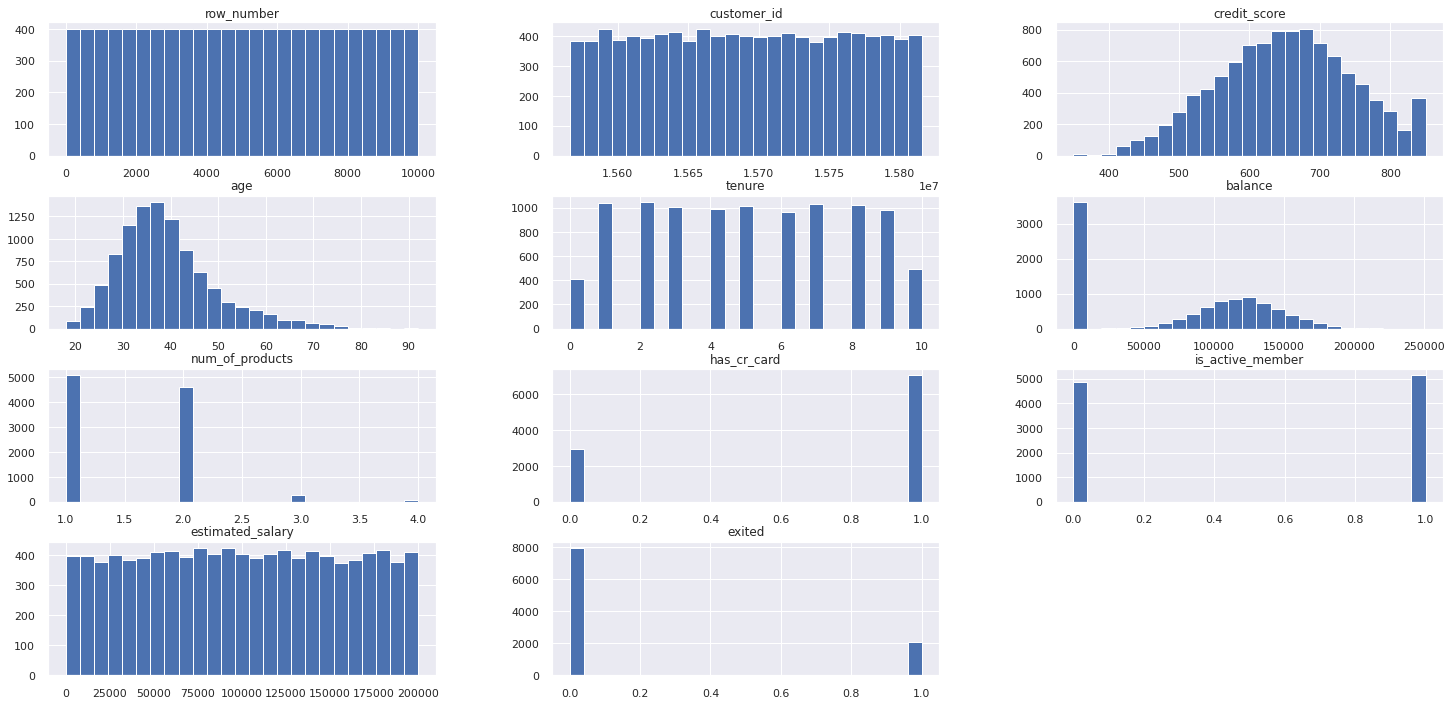

In [265]:
df1_num.hist(bins=25);

### 4.1.9 Categorical Attributes

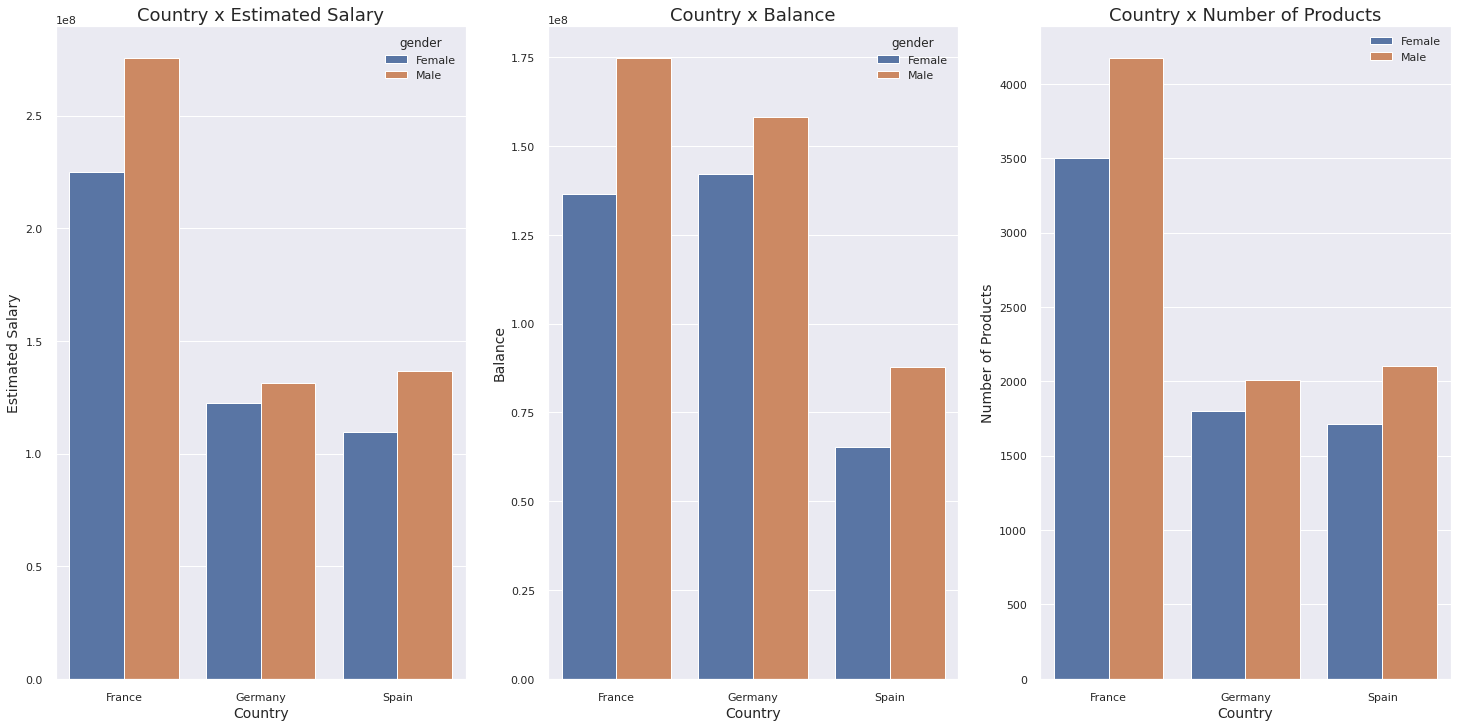

In [266]:
# check hue https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn

# Setting title and labels
def set_plots_features(ax, title, xlabel, ylabel):
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

aux1 = df1[['geography', 'gender', 'balance']].groupby(['geography', 'gender']).sum().reset_index()

aux2 = df1[['geography', 'gender', 'estimated_salary']].groupby(['geography', 'gender']).sum().reset_index()

aux3 = df1[['geography', 'gender', 'num_of_products']].groupby(['geography', 'gender']).sum().reset_index()



# country 
fig, gr = plt.subplots()

plt.subplot(1,3,1)
gr = sns.barplot(x = 'geography', hue= 'gender', y = 'estimated_salary', data=aux2)
set_plots_features(gr, 'Country x Estimated Salary', 'Country', 'Estimated Salary')

plt.subplot(1,3,2)
gr = sns.barplot(x = 'geography', hue= 'gender', y = 'balance', data=aux1)
set_plots_features(gr, 'Country x Balance', 'Country', 'Balance')

plt.subplot(1,3,3)
gr = sns.barplot(x = 'geography', hue= 'gender', y = 'num_of_products', data=aux3)
set_plots_features(gr, 'Country x Number of Products', 'Country', 'Number of Products')

# Legend
plt.legend()

# Display the plot
plt.show()

## 4.2 Analise Bivariada

Now let's look at the correlation of the resources with the "closed" target variable. The main objective here is to better understand the data and business and especially which variables are most relevant to the machine start algorithm.

### H1. Os usuarios com score maior que 800 em media tem mais dinheiro no banco.
*Falso* os usuarios em media tem o mesmo valor 


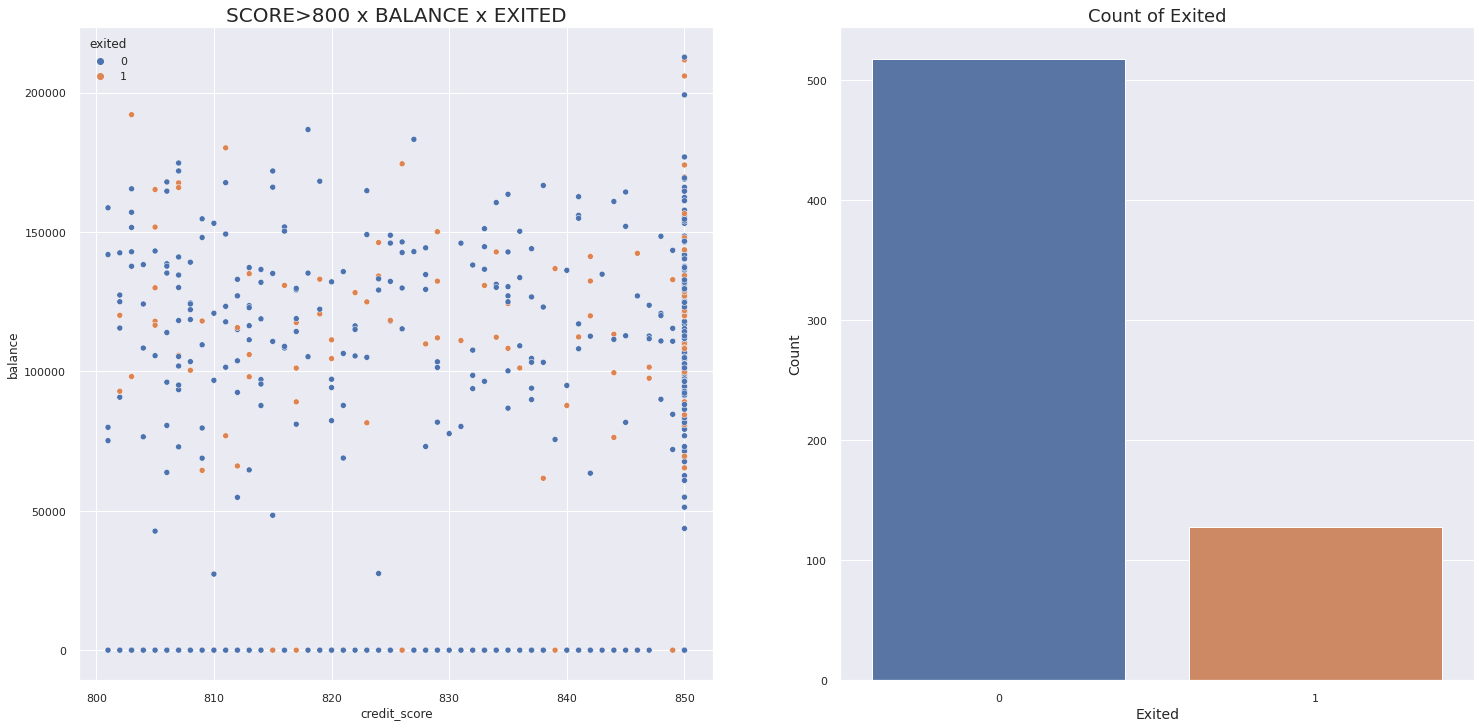

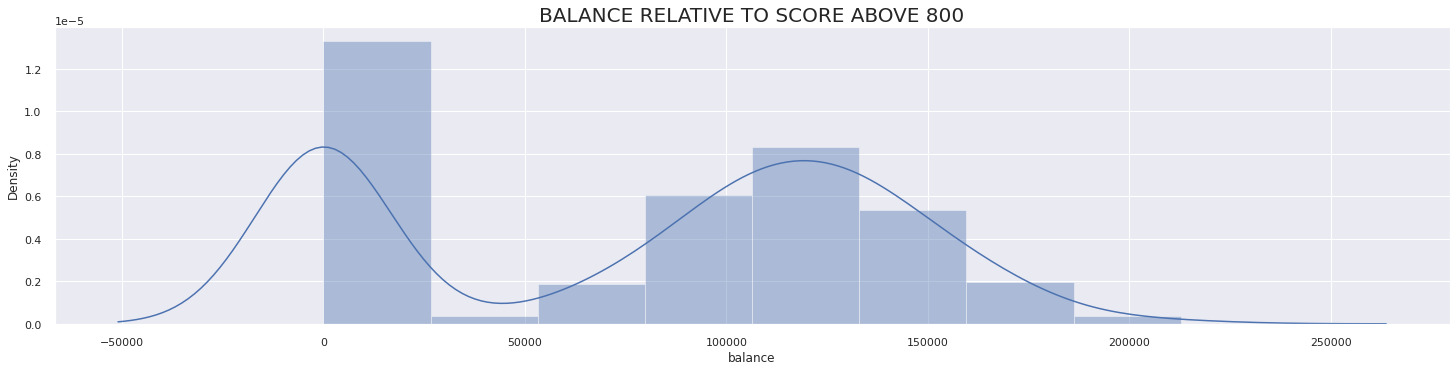

In [267]:
auxh1_h=df1[df1['credit_score']>800]
plt.subplot(1,2,1);
sns.scatterplot(x='credit_score',y='balance', hue='exited', data=auxh1_h).set_title('SCORE>800 x BALANCE x EXITED', fontsize=20);



# Count Plot
plt.subplot(1,2,2);

gr = sns.countplot(auxh1_h['exited']);
set_plots_features(gr, 'Count of Exited', 'Exited', 'Count');


# Display the plot
plt.show();

plt.subplot(2,1,1)
auxdisth=df1.loc[df1['credit_score']>800, 'balance']
sns.distplot(auxdisth).set_title('BALANCE RELATIVE TO SCORE ABOVE 800', fontsize=20);

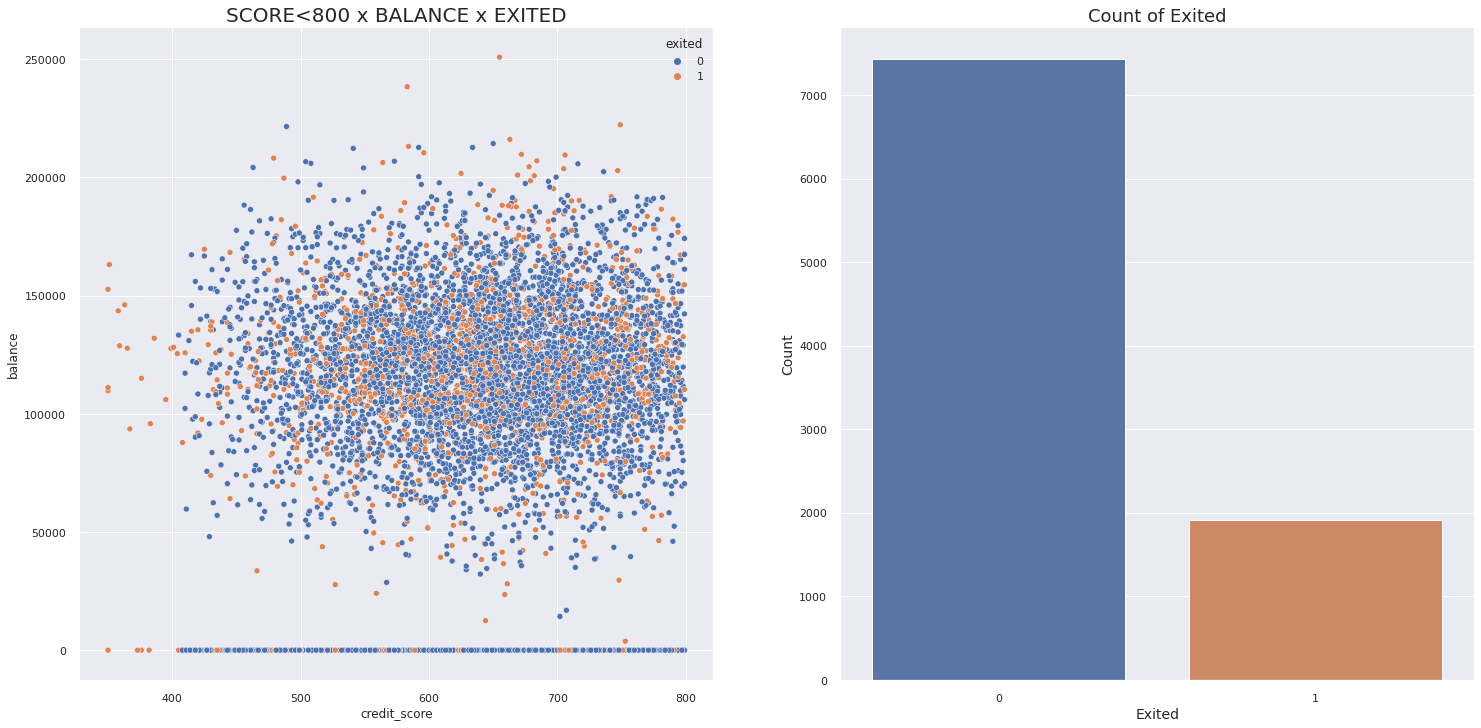

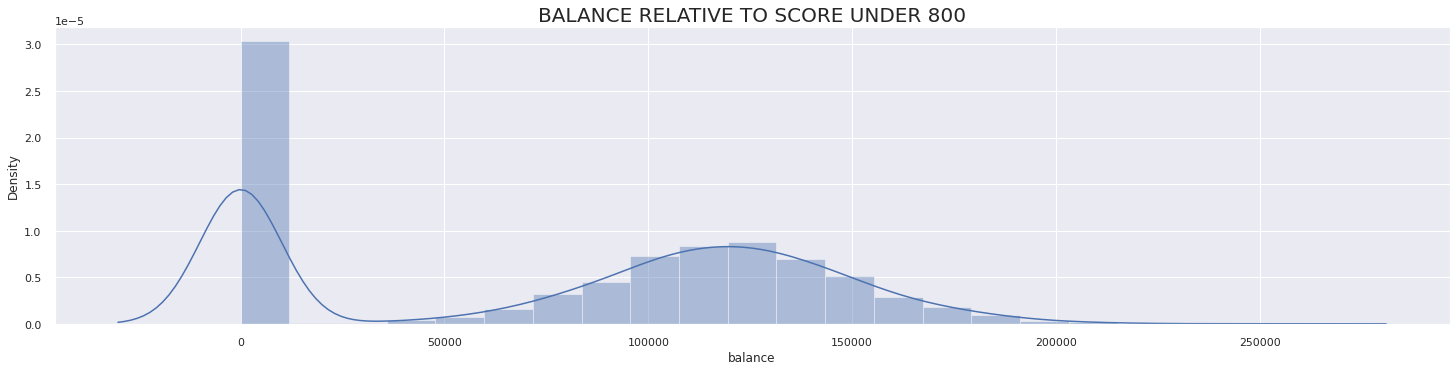

In [268]:
auxh1_l=df1[df1['credit_score']<800]
plt.subplot(1,2,1)
sns.scatterplot(x='credit_score',y='balance', hue='exited', data=auxh1_l).set_title('SCORE<800 x BALANCE x EXITED', fontsize=20);


# Count Plot
plt.subplot(1,2,2)

gr = sns.countplot(auxh1_l['exited'])
set_plots_features(gr, 'Count of Exited', 'Exited', 'Count')

# Display the plot
plt.show()

plt.subplot(2,1,1)
auxdistl=df1.loc[df1['credit_score']<800, 'balance']
sns.distplot(auxdistl).set_title('BALANCE RELATIVE TO SCORE UNDER 800', fontsize=20);

### H2. Spain has the largest number of credit cards in the database.
**False** Spain has the lowest number of cards with 2477


**Note:** People who have a credit card give more churn

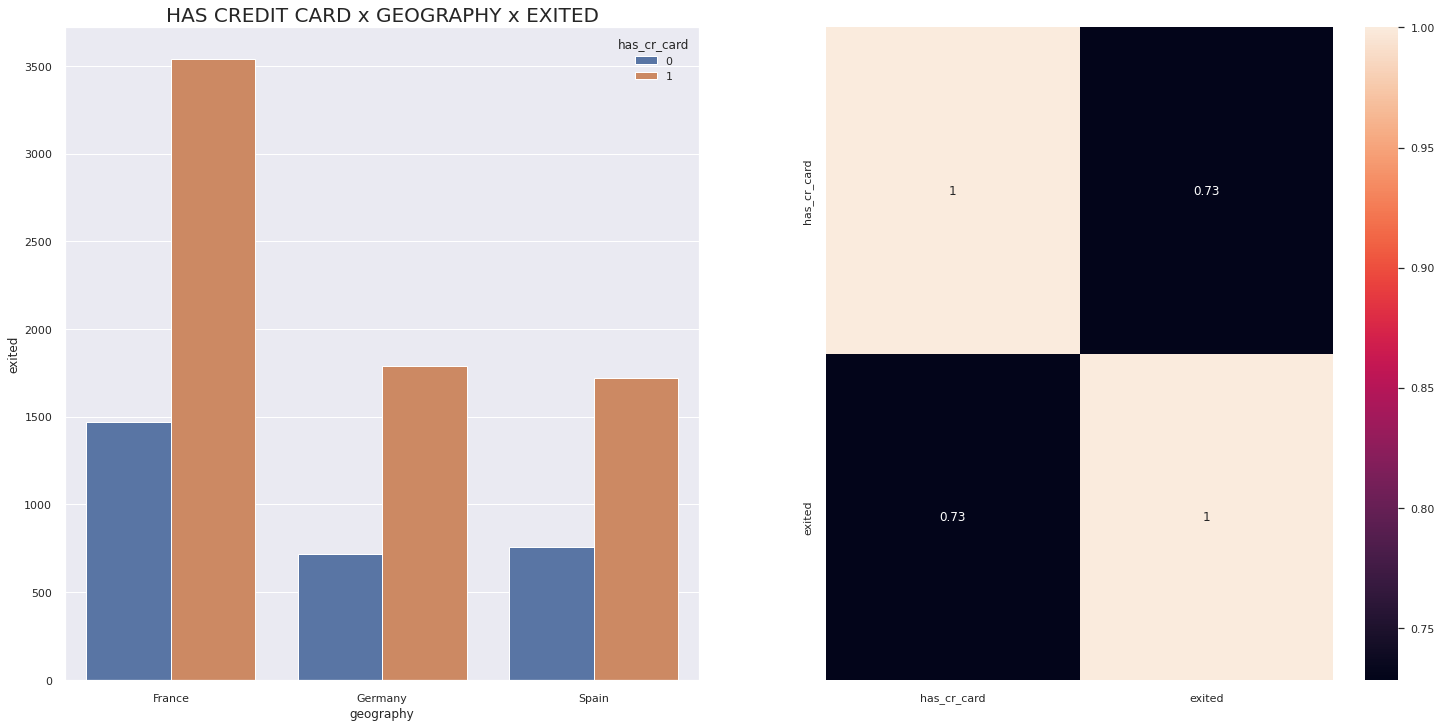

In [269]:
aux2=df4[['geography','has_cr_card','exited']].groupby(['geography','has_cr_card']).count().reset_index()
# aux2
plt.subplot(1,2,1)
sns.barplot(x='geography', y='exited', hue='has_cr_card', data=aux2).set_title('HAS CREDIT CARD x GEOGRAPHY x EXITED', fontsize=20);

plt.subplot(1,2,2)
sns.heatmap( aux2.corr( method='pearson' ), annot=True );

### H3. The female audience has a higher score than the male audience.

**False** Men and Women on average have the same score.

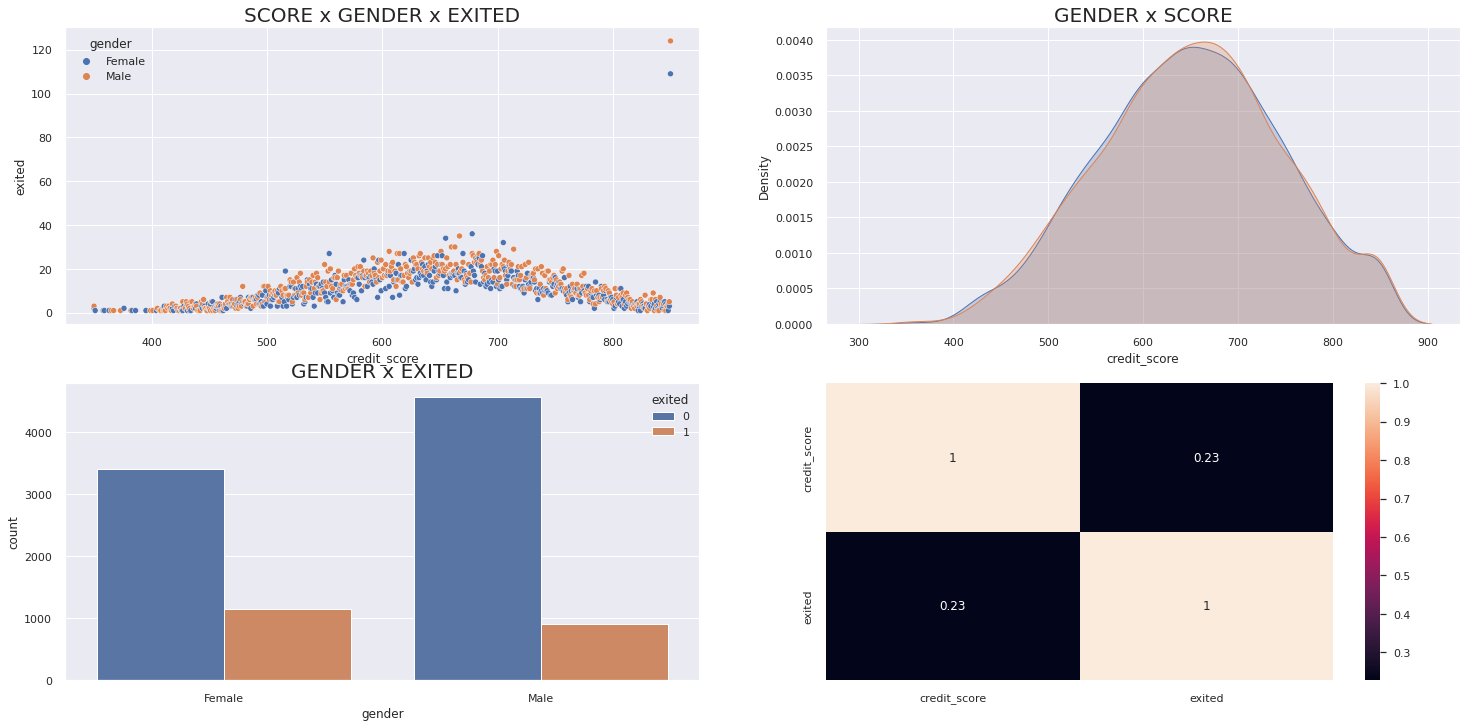

In [270]:
aux3=df4[['credit_score','gender','exited']].groupby(['credit_score','gender']).count().reset_index()

plt.subplot(2,2,1)
sns.scatterplot(hue='gender', x='credit_score', y='exited', data=aux3).set_title('SCORE x GENDER x EXITED', fontsize=20);
# plt.show()

plt.subplot(2,2,2)
sns.kdeplot( df4[df4['gender'] == 'Male']['credit_score'], label='MALE SCORE', shade=True ).set_title('GENDER x SCORE', fontsize=20);
sns.kdeplot( df4[df4['gender'] == 'Female']['credit_score'], label='FEMALE SCORE', shade=True );
# plt.show()

plt.subplot(2,2,3)
sns.countplot(x='gender', hue='exited', data=df4).set_title('GENDER x EXITED', fontsize=20);

plt.subplot(2,2,4)
sns.heatmap( aux3.corr( method='pearson' ), annot=True )
plt.show()





### H4. Men have more money than women in the bank.

**True** Men have more money in the bank than women and give less churn too.

<AxesSubplot:>

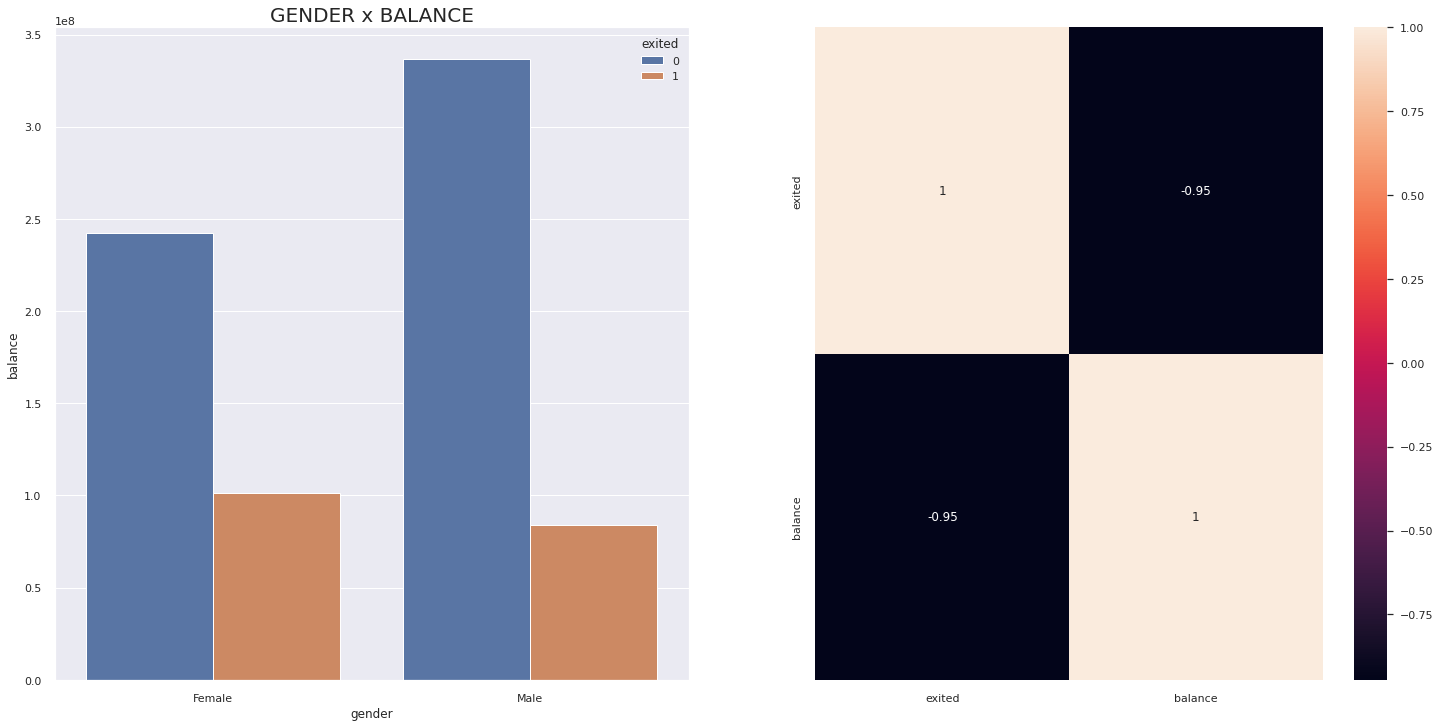

In [271]:
aux4=df4[['gender', 'exited', 'balance']].groupby(['gender', 'exited']).sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x='gender', y='balance', hue='exited', data=aux4).set_title('GENDER x BALANCE', fontsize=20);

plt.subplot(1,2,2)
sns.heatmap( aux4.corr( method='pearson' ), annot=True )


###  H5. O salario estimados das mulherem em media eh maior do que dos homens.

**Falso** a distribuicao eh proxima de uma unitaria.

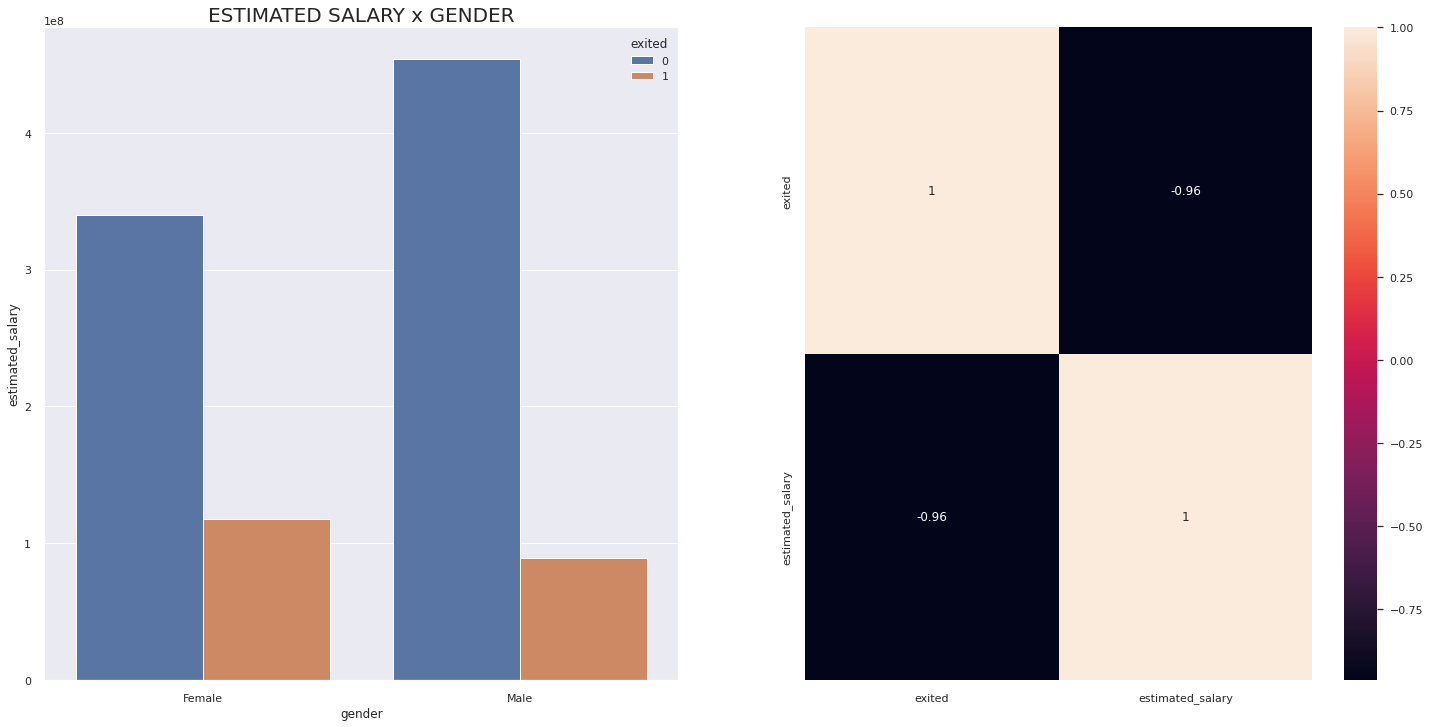

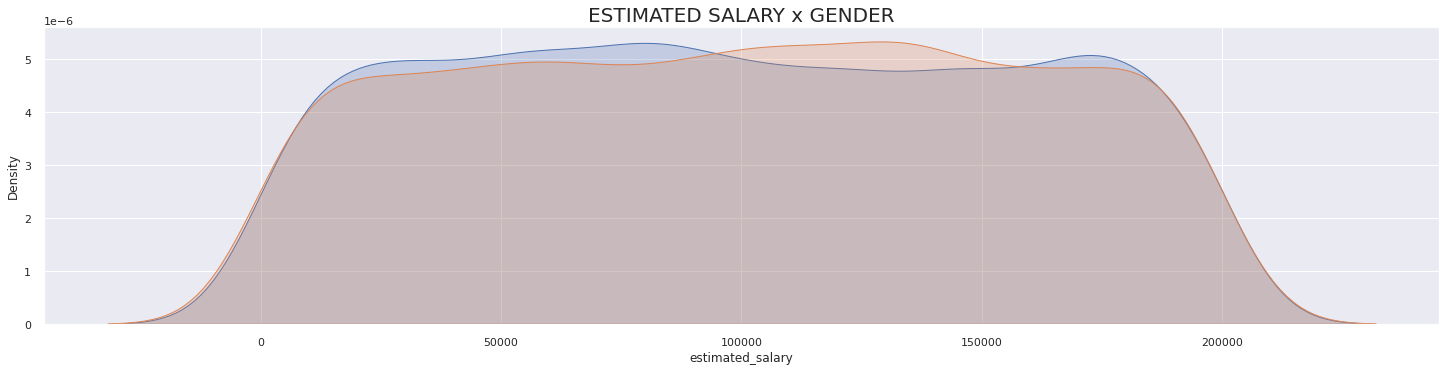

In [272]:
aux5=df4[['gender', 'exited', 'estimated_salary']].groupby(['gender', 'exited']).sum().reset_index()
# aux5
plt.subplot(1,2,1)
sns.barplot(x='gender', y='estimated_salary', hue='exited', data=aux5).set_title('ESTIMATED SALARY x GENDER', fontsize=20);

plt.subplot(1,2,2)
sns.heatmap( aux5.corr( method='pearson' ), annot=True )
plt.show()


plt.subplot(2,1,1 )
sns.kdeplot( df4[df4['gender'] == 'Male']['estimated_salary'], label='MALE ESTIMATED SALARY', shade=True ).set_title('ESTIMATED SALARY x GENDER', fontsize=20);
sns.kdeplot( df4[df4['gender'] == 'Female']['estimated_salary'], label='FEMALE ESTIMATED SALARY', shade=True );

### H6. Pessoas que moram na alemanha em media sao mais ativos que os demais.

**False** a Franca que possue o maior numero de usuarios ativos.


**obs**: devido aos dados estarem desbalanceados a franca leva a maioria neste experimento.

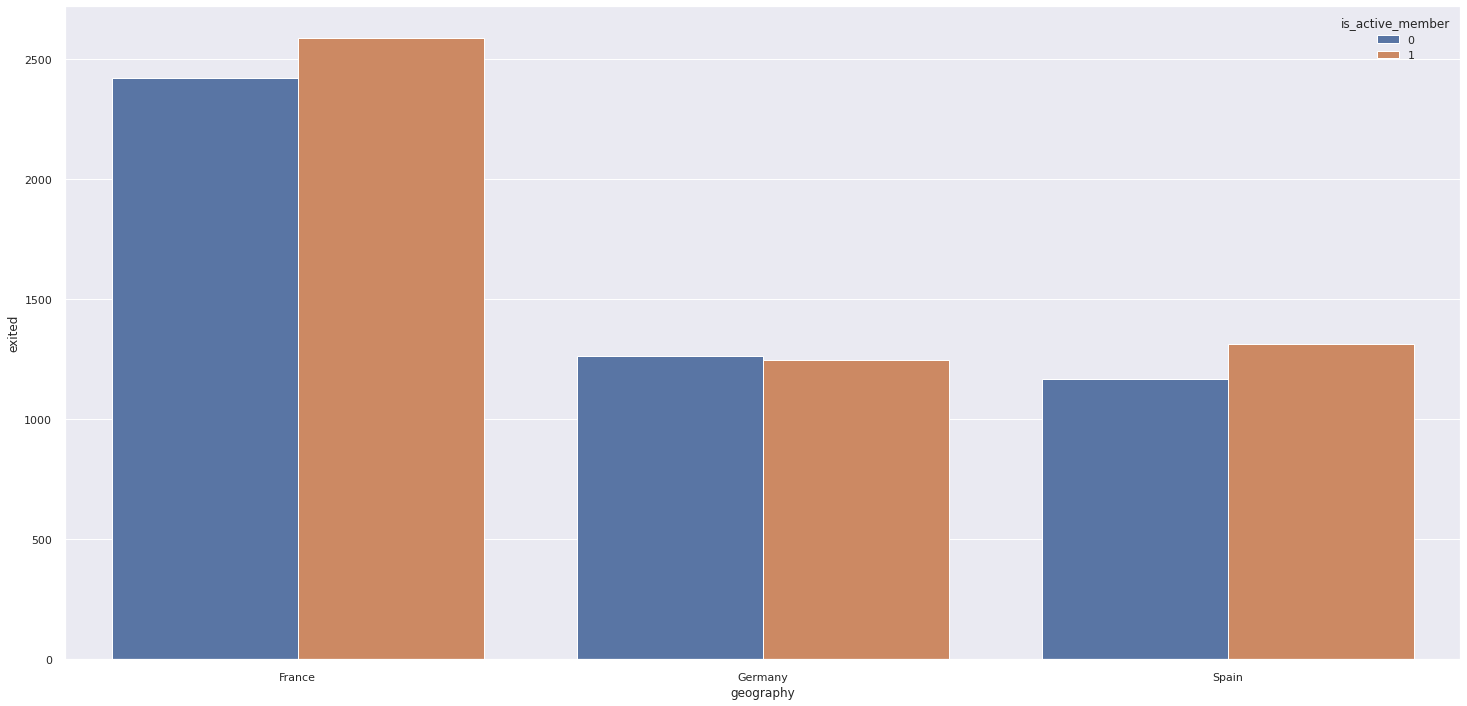

In [273]:
aux6=df4[['geography', 'exited', 'is_active_member']].groupby(['geography','is_active_member']).count().reset_index()
sns.barplot(x='geography', hue='is_active_member', y='exited', data=aux6);

## 4.3 Analise Multivariada

### 4.3.1 Numerical Attributes before


**Numerical attributes** indicates that **age, balance and num_of_products** has some correlation with our target variable, but nothing strong.

In order to improve the machine learning algorithm we should create some new features based on this three features.

It should be:

- balance_by_age = balance / age

- balance_by_num_of_products = balance / num_of_products

- num_of_products_by_age = num_of_products / age

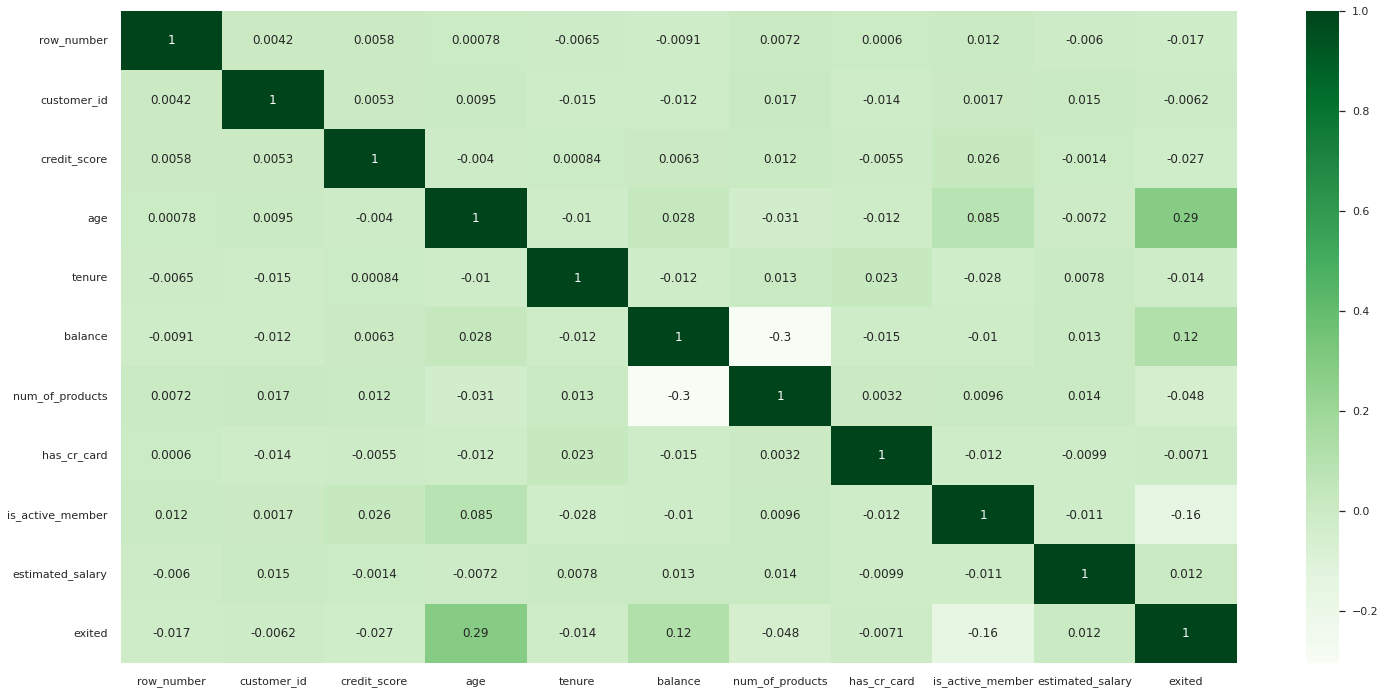

In [274]:
correlation=df1_num.corr(method='pearson')
sns.heatmap(correlation, cmap='Greens',annot=True);


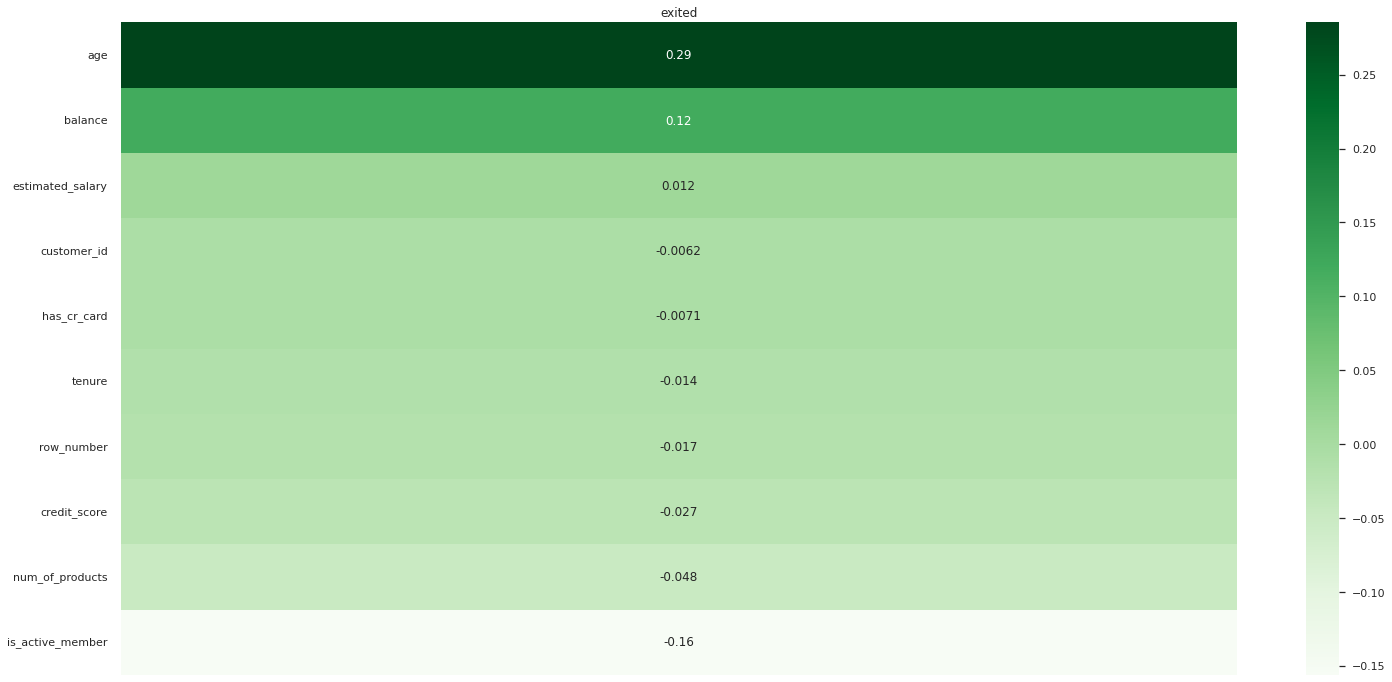

In [275]:
 #See the result in correlation to the target variable 

plot_corr('exited') ;

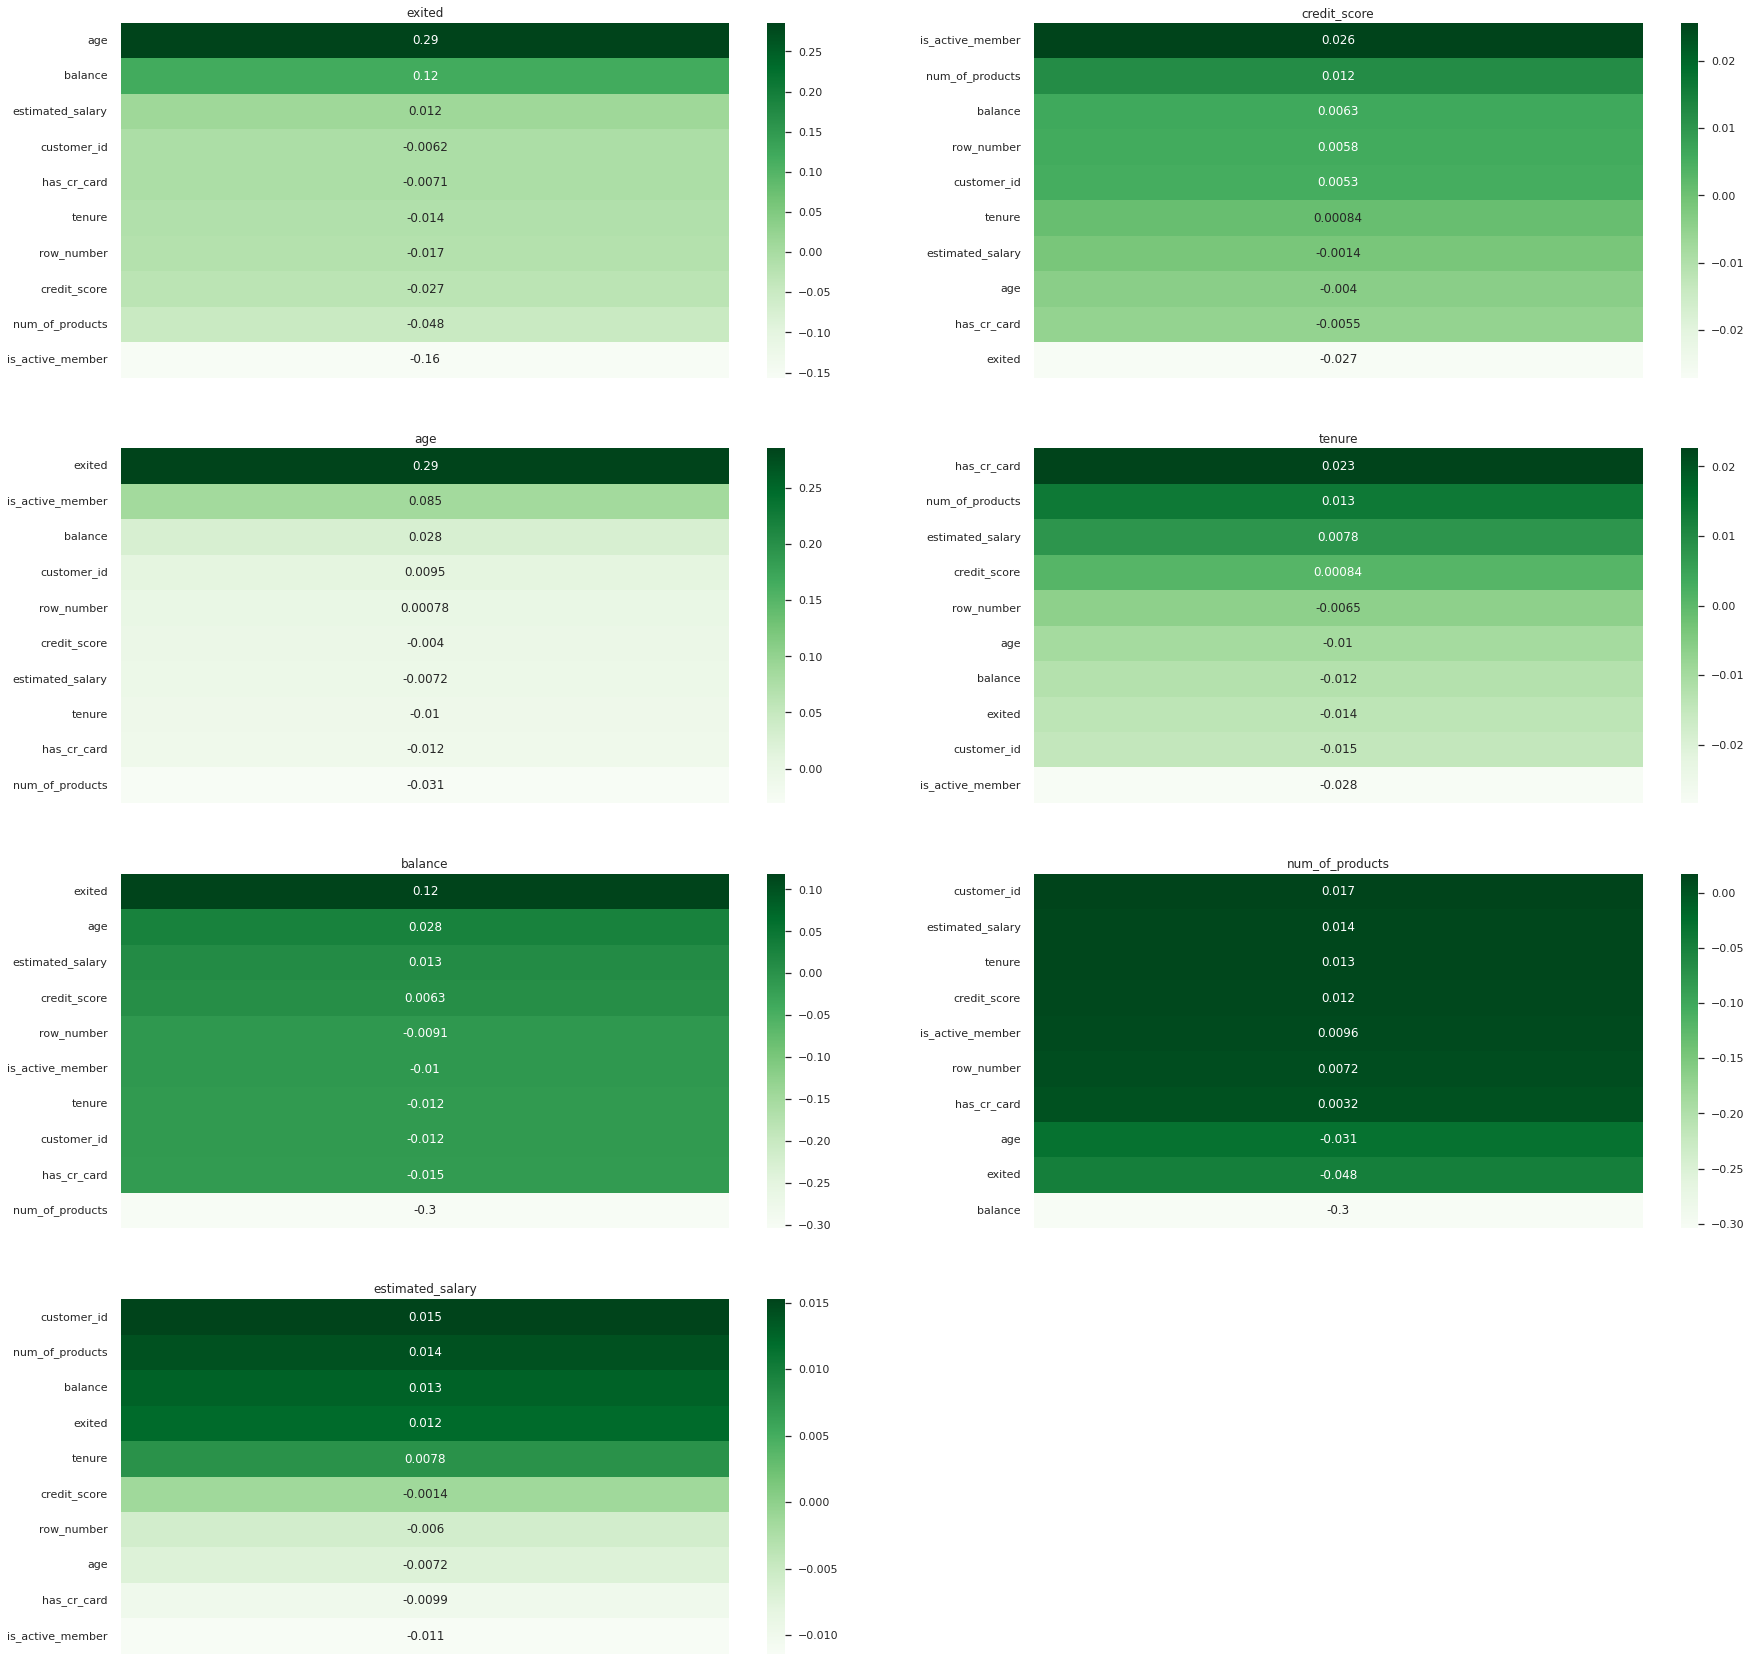

In [276]:
# Ranking of correlation between each variable 

plt.subplots(figsize=(30,30))
plt.subplot(4,2,1)
plot_corr('exited')

plt.subplot(4,2,2)
plot_corr('credit_score') 

plt.subplot(4,2,3)
plot_corr('age') 

plt.subplot(4,2,4)
plot_corr('tenure') 

plt.subplot(4,2,5)
plot_corr('balance') 

plt.subplot(4,2,6)
plot_corr('num_of_products') 

plt.subplot(4,2,7)
plot_corr('estimated_salary') ;

#### 4.3.1.1 Numerical Attributes after

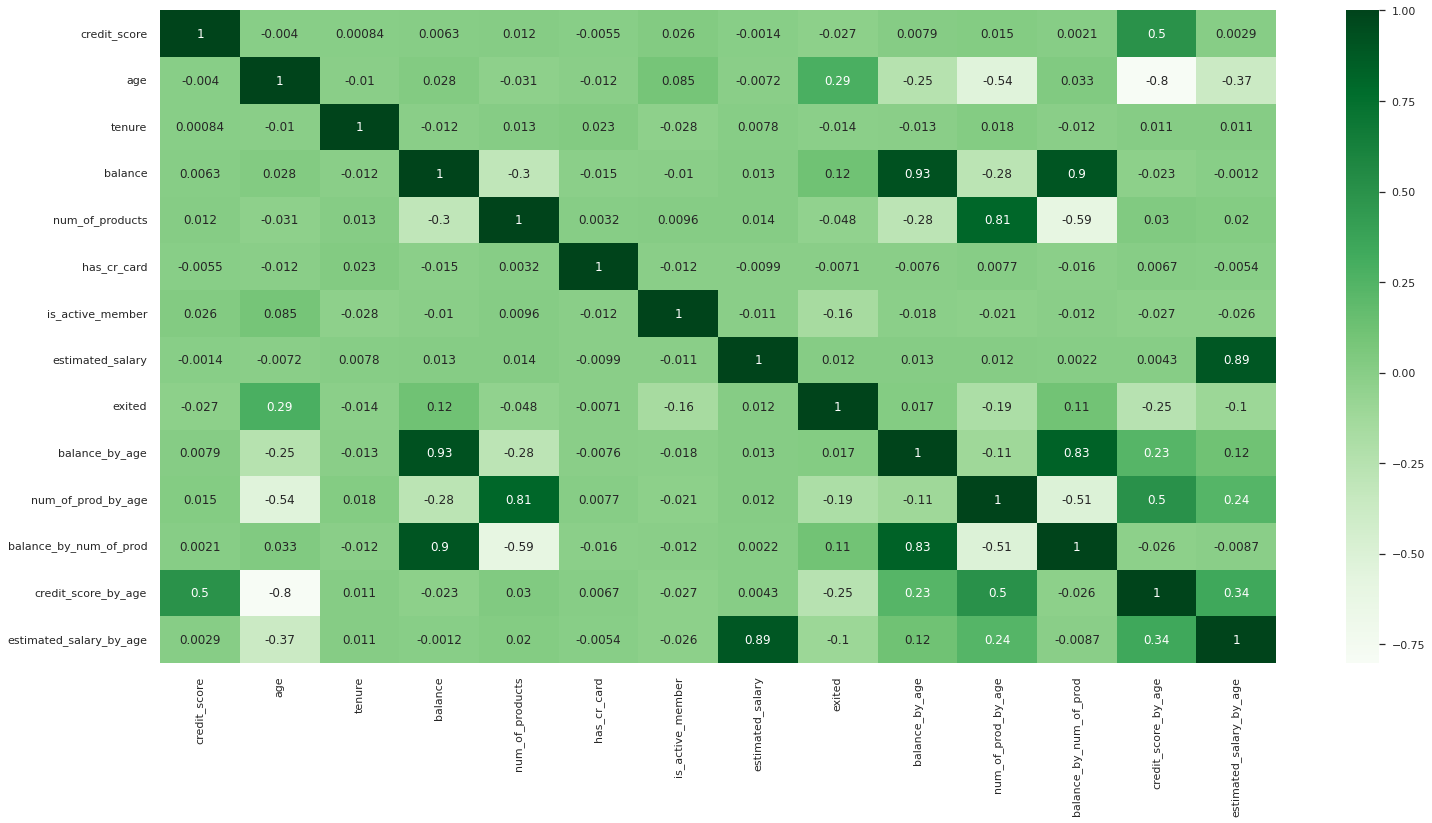

In [277]:
df4_nw_feat=df4.select_dtypes(include=['int64','float64'])

correlation=df4_nw_feat.corr(method='pearson')
sns.heatmap(correlation, cmap='Greens',annot=True);

### 4.3.2 Categorical Attributes

In order to analyse the correlation between categorical attributes I applied Cramer's V method (https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V).

Churn correlation happens between gender, geo and is active member, it's not too strong but considerable.

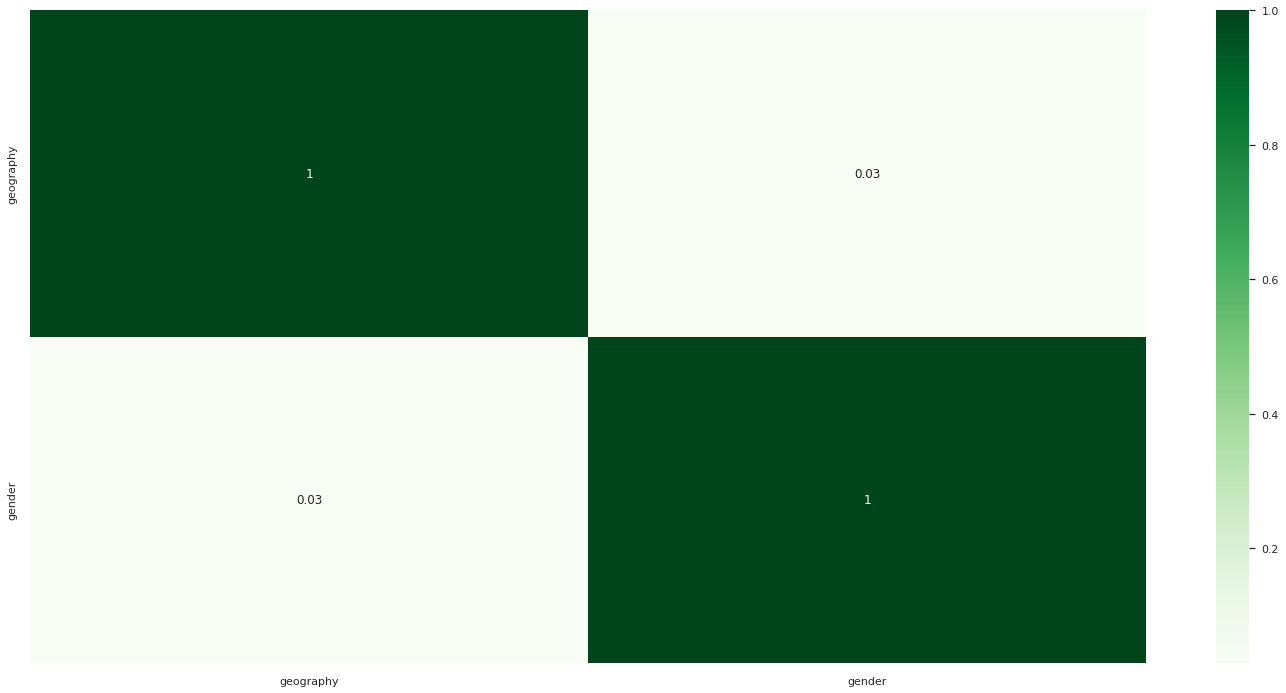

In [278]:
a = df4.select_dtypes(exclude=['float64','int64'])
rows= []

for var1 in a:
  col = []
  for var2 in a :
    
    # Cramer's V test
    cramers =cramer_v(a[var1], a[var2]) 
    # Keeping of the rounded value of the Cramer's V  
    col.append(round(cramers,2)) 
    
  rows.append(col)
  
cramers_results = np.array(rows)
dfcv = pd.DataFrame(cramers_results, columns = a.columns, index =a.columns)
sns.heatmap(dfcv, cmap='Greens', annot=True);

# 5.0 DATA PREPARATION


In [312]:
df5=df4.copy()

## 5.1 Standardization

##  5.2 Rescaling


age robust scaler - with outliers

In [313]:
rs=RobustScaler()
mms=MinMaxScaler()

# age - robust scaler devido a outliers
df5['age']=mms.fit_transform(df5[['age']].values)
pickle.dump(mms, open('/home/tc0019/DS/topbottombank/src/parameter/age_scaler.pkl', 'wb' ))

df5['credit_score'] = rs.fit_transform(df5[['credit_score']].values)
pickle.dump(rs, open('/home/tc0019/DS/topbottombank/src/parameter/credit_score.pkl', 'wb' ))

# estimated salary
df5['estimated_salary']=mms.fit_transform(df5[['estimated_salary']].values)
pickle.dump(mms, open('/home/tc0019/DS/topbottombank/src/parameter/estimated_salary_scaler.pkl', 'wb' ))

# tenure
df5['tenure'] = mms.fit_transform(df5[['tenure']].values)
pickle.dump(mms, open('/home/tc0019/DS/topbottombank/src/parameter/tenure_scaler.pk1', 'wb'))

# balance
df5['balance'] = mms.fit_transform(df5[['balance']].values)
pickle.dump(mms, open('/home/tc0019/DS/topbottombank/src/parameter/balance_scaler.pk1', 'wb'))

# num_of_products
df5['num_of_products'] = mms.fit_transform(df5[['num_of_products']].values)
pickle.dump(mms, open('/home/tc0019/DS/topbottombank/src/parameter/num_of_products_scaler.pk1', 'wb'))

# balance_by_age
df5['balance_by_age'] = mms.fit_transform(df5[['balance_by_age']].values)
pickle.dump(mms, open('/home/tc0019/DS/topbottombank/src/parameter/balance_by_age_scaler.pk1', 'wb'))

# balance_by_num_of_prod
df5['balance_by_num_of_prod'] = mms.fit_transform(df5[['balance_by_num_of_prod']].values)
pickle.dump(mms, open('/home/tc0019/DS/topbottombank/src/parameter/balance_by_num_of_prod_scaler.pk1', 'wb'))

## 5.3 Transformation


### 5.3.1 Encoding

In [314]:
df1.head()

row_number  customer_id   surname  credit_score geography  gender  age  tenure    balance  num_of_products  has_cr_card  is_active_member  estimated_salary  exited
0           1     15634602  Hargrave           619    France  Female   42       2       0.00                1            1                 1         101348.88       1
1           2     15647311      Hill           608     Spain  Female   41       1   83807.86                1            0                 1         112542.58       0
2           3     15619304      Onio           502    France  Female   42       8  159660.80                3            1                 0         113931.57       1
3           4     15701354      Boni           699    France  Female   39       1       0.00                2            0                 0          93826.63       0
4           5     15737888  Mitchell           850     Spain  Female   43       2  125510.82                1            1                 1          79084.10       0

In [315]:

# geography
# one hot encoding
df5=pd.get_dummies(df5, prefix=['geography'], columns=['geography'])

# gender
# one hot encoding
df5=pd.get_dummies(df5,prefix=['gender'],columns=['gender'])
# or apply lambda tg manually

# has_cr_card
# one hot encoding
# df5=pd.get_dummies(df5,prefix=['has_cr_card'],columns=['has_cr_card'])

# is_active_member
# one hot encoding
# df5=pd.get_dummies(df5,prefix=['is_active_member'],columns=['is_active_member'])


# Transform strings into numbers

# d = {'yes':1,'no':0}

# df3['HasCrCard'] = df3['HasCrCard'].map(d)
# df3['IsActiveMember'] = df3['IsActiveMember'].map(d)



# df5.loc[df5['geography']=='France', 'geography_France']=1 
# df5.loc[df5['geography']=='Germany', 'geography_Germany']=1 
# df5.loc[df5['geography']=='Spain', 'geography_Spain']=1 

# df5.loc[df5['gender']=='Female', 'gender_Female']=1 
# df5.loc[df5['gender']=='Male', 'gender_Male']=1 

# df5.loc[df5['has_cr_card']==0, 'has_cr_card_0']=1 
# df5.loc[df5['has_cr_card']==1, 'has_cr_card_1']=1 

# df5.loc[df5['is_active_member']==0, 'is_active_member_0']=1 
# df5.loc[df5['is_active_member']==1, 'is_active_member_1']=1 

# df5=df5.fillna(0)


## 5.4 Split into train and test

In [316]:
X = df5.drop( 'exited', axis=1 )
y = df5['exited'].copy() 

X_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.20, random_state=32, stratify=y)

df5 = pd.concat( [X_train, y_train], axis=1 )
df5.shape

(8000, 19)

In [317]:
(X_train.shape, y_train.shape), (x_validation.shape, y_validation.shape)


(((8000, 18), (8000,)), ((2000, 18), (2000,)))

# 6.0  FEATURE SELECTION


In [318]:
df6=df5.copy()

## 6.2 Boruta selection

### 6.2.1 Feature Selecting Summary

**The folow fatures was discarded by BorutaShap:**

- geography_France and geography_Spain: As observed on EDA step, German clients are more propense to churn, but not French and Spanish clients. **In agreement with EDA.**

- has_cr_card: It's in accordance with observations on EDA, where we didn't found diferences between clientes with credit card or not. **In agreement with EDA.**


**The folow fatures was selected by BorutaShap:**

- estimated_salary: We analyzed salary by ranges, where we didn't observed any impact on churn, but it's was considered relevant for the model. **Not in agreement with EDA.**

- gender: Was observed that womans are more propense to churn. **In agreement with EDA.**

- balance: EDA showed that clients with balance greater then zero have more chances to churn. **In agreement with EDA.**

- age: Age as expected as a important variable too. **In agreement with EDA.**

- credit_score: The credit score didn't show on the EDA analysis been a relevante variable. **Not in agreement with EDA.**

- tenure: On EDA it was observed as not important variable. **Not in agreement with EDA.**

- is_active_member: It was considered a important variable during EDA process. **In agreement with EDA.**

- num_of_products: Other variable that was espected to be selected as important. **In agreement with EDA.**

### 6.2.2 BorutaShap
 
 As BorutaShap allows to choose what algorithm we want to use to find the best features, I will use CatBoostClassifier because is one of the most eficient algorithms to dealing with classifications and fast.

 - A representative BorutaSHAP importance plot. Green are features to keep in the model for this fold. Blue are
maximum, mean, median and minimum shadow features.

100%|██████████| 100/100 [16:14<00:00,  9.75s/it]


15 attributes confirmed important: ['num_of_prod_by_age', 'is_active_member', 'credit_score_by_age', 'geography_France', 'balance_by_age', 'gender_Male', 'num_of_products', 'credit_score', 'balance', 'balance_by_num_of_prod', 'tenure', 'geography_Germany', 'geography_Spain', 'gender_Female', 'age']
2 attributes confirmed unimportant: ['estimated_salary_by_age', 'has_cr_card']
1 tentative attributes remains: ['estimated_salary']


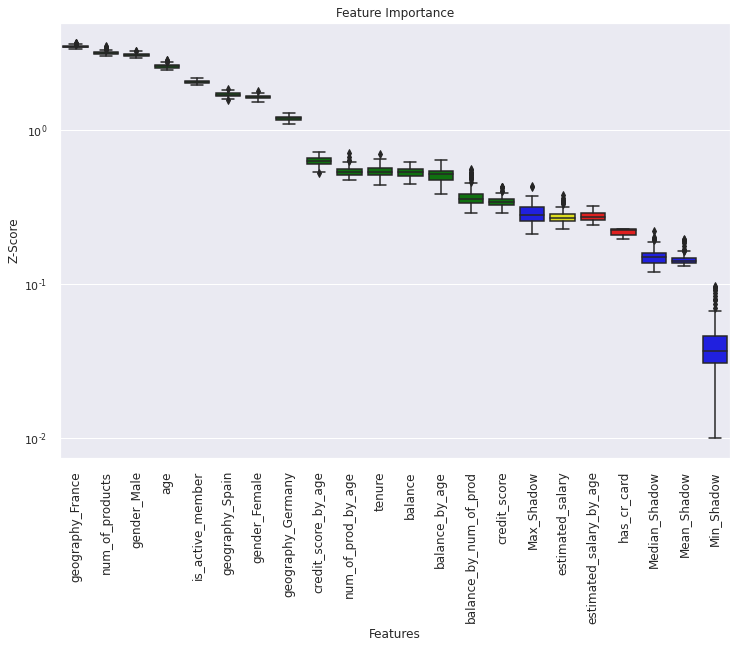

In [291]:
cat_boruta = CatBoostClassifier(random_state=42)

Feature_Selector_cat = BorutaShap(model = cat_boruta,
                                  importance_measure='shap',
                                  classification=True)

Feature_Selector_cat.fit(X=X_train, y=y_train, n_trials=100, random_state=32)


# Returns Boxplot of features
Feature_Selector_cat.plot(X_size=12, figsize=(12,8),
                          y_scale='log', which_features='all')

In [292]:
asdd

NameError: name 'asdd' is not defined

### 6.2.3 SHAP
- The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. 

- https://www.youtube.com/watch?v=ZkIxZ5xlMuI

In [ ]:
catb = CatBoostClassifier(random_state=42, logging_level='Silent').fit(X=X_train, y=y_train)

explainer = shap.TreeExplainer(catb)
shap_values = explainer.shap_values(Pool(X_train, y_train))

shap_values = catb.get_feature_importance(Pool(x_validation, label=y_validation) ,
                                               type="ShapValues")
 
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

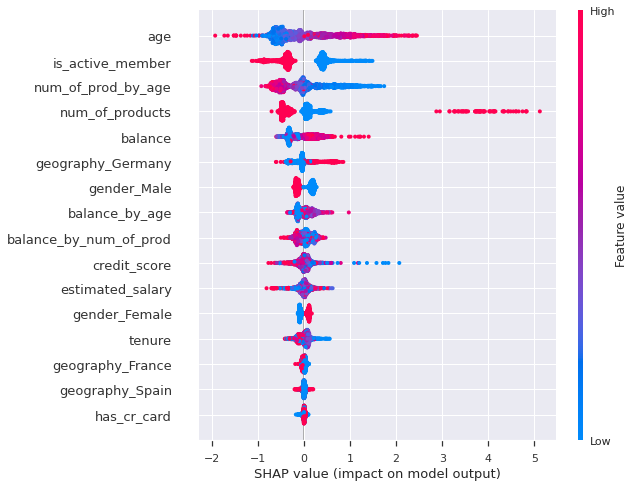

In [ ]:
shap.summary_plot(shap_values, x_validation,show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

In [ ]:
df5.head()

credit_score       age  tenure   balance  num_of_products  has_cr_card  is_active_member  estimated_salary  balance_by_age  num_of_prod_by_age  balance_by_num_of_prod  geography_France  geography_Germany  geography_Spain  gender_Female  gender_Male  exited
7879      0.037313  0.351351     0.6  0.304885         0.000000            1                 0          0.395339        0.170257            0.022727                0.320885                 1                  0                0              0            1       0
9128      0.305970  0.337838     0.1  0.485966         0.000000            1                 0          0.439959        0.277690            0.023256                0.511469                 0                  1                0              1            0       1
651       0.507463  0.459459     0.7  0.000000         0.000000            1                 1          0.073855        0.000000            0.019231                0.000000                 1                  0                0              0            1       0
1975     -0.223881  0.229730     0.5  0.000000         0.333333            1                 0          0.255531        0.000000            0.057143                0.000000                 1                  0                0              1            0       0
5985      0.395522  0.202703     0.7  0.272716         0.000000            1                 1          0.324336        0.203058            0.030303                0.287028                 0                  0                1              0            1       0

In [319]:
#features not selected
unimportant_cols = ['credit_score', 'has_cr_card' ] #'gender_Female', 'gender_Male', #geography_Germany (keep all countries)

# Drop uniportant attributes
X_train = X_train.drop(unimportant_cols, axis=1)
x_validation = x_validation.drop(unimportant_cols, axis=1)

# 7.0 MACHINE LEARNING


In [ ]:
df7 = df6.copy()

## 7.1 Logistic regression

Advantages
- It's a simple model, so it takes very little time for training.
- It can handle a large number of features.


Disadvantages
- Although it has the word regression in its name, we can only use it for classification problems because of its range which always lies between 0 and 1.
- It can only be used for binary classification problems and has a poor response for multi-class classification problems

**logistic regression common hyperparameters:** penalty, max_iter, C, solver

https://towardsdatascience.com/tuning-the-hyperparameters-of-your-machine-learning-model-using-gridsearchcv-7fc2bb76ff27


2022/06/06 23:36:47 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: file:///mlruns/1/artifacts/552d72892b944d63bfbdbf99a708a7eb/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


Experiment_id: 4
Artifact Location: file:///home/tc0019/mlruns/4
Acurácia Logistic Regression=  0.8165


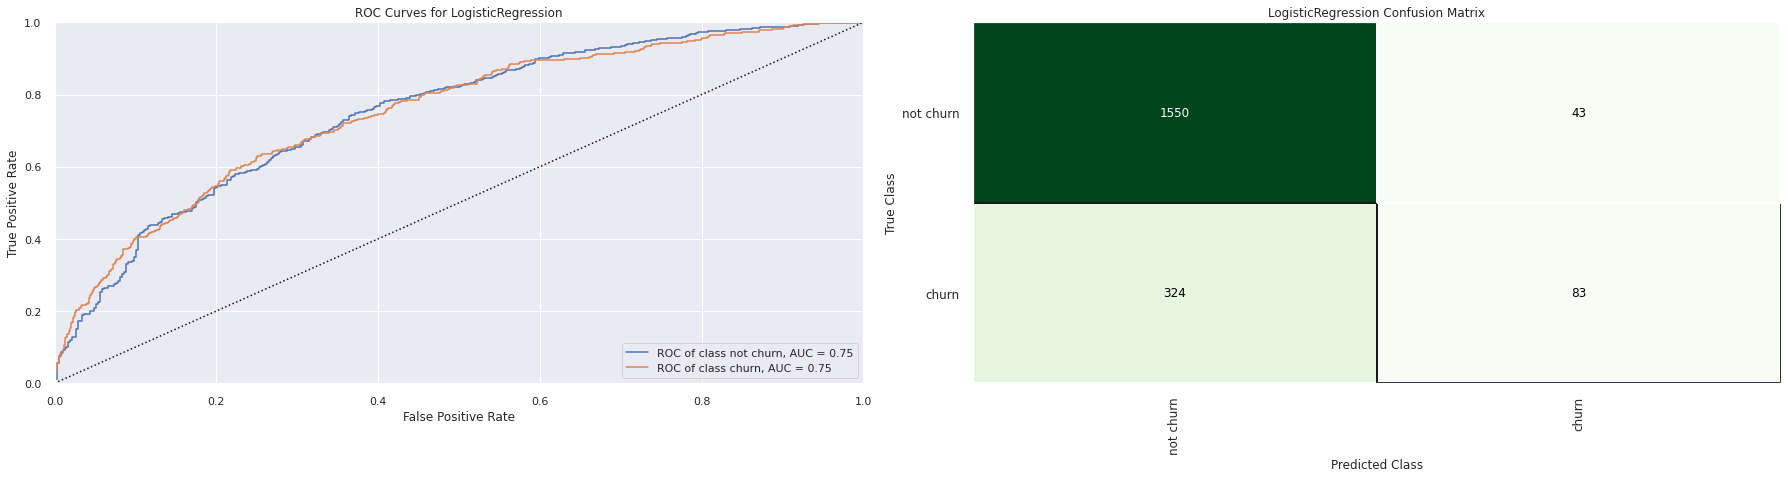

In [320]:
# run name
mlflow.start_run(run_name='logistic_regression_churn_predictions')
mlflow.set_tag('Train','V1')

# local path to artifacts /usr/src/mlruns/1
export_path = "file:///mlruns/1/artifacts/{run_id}/{artifact_path}".format(run_id=mlflow.active_run().info.run_id,artifact_path="model")
experiment = mlflow.get_experiment_by_name("Bank Customers Churn Predictions")
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))

# model definition and train
model_lr=LogisticRegression(solver='liblinear',random_state=32).fit(X_train, y_train)

if os.path.exists(export_path) == False:
    mlflow.sklearn.save_model(model_lr, path=export_path)
    mlflow.log_artifacts(export_path, "logistic_regression")
    mlflow.log_params( {'solver':'liblinear','random_state':32})  

else:
    mlflow.log_artifacts(export_path, "logistic_regression")
    mlflow.log_params( {'solver':'liblinear','random_state':32})  


plt.subplot(2,2,1)
rocauc(model_lr)


plt.subplot(2,2,2)
confusion_matrix1(model_lr)
plt.savefig("/home/tc0019/DS/topbottombank/reports/rocconfmat_logistic_regression.png")
mlflow.log_artifact("/home/tc0019/DS/topbottombank/reports/rocconfmat_logistic_regression.png")

# predict
yhat_lr=model_lr.predict(x_validation)
y_probas_lr = model_lr.predict_proba(x_validation)
a=accuracy_score(y_validation, yhat_lr).round(2)
recall = recall_score(y_validation, yhat_lr, average='binary').round(2)
precision = precision_score(y_validation, yhat_lr, average='binary').round(2)
mlflow.log_metrics({'Accuracy':a, 'Recall':recall, 'Precision':precision})
print("Acurácia Logistic Regression= ", accuracy_score(y_validation, yhat_lr))
mlflow.end_run()

In [ ]:
mlflow.end_run()

## 7.2 Decision Tree

Advantages
- This algorithm allows for an uncomplicated representation of data. So, it is easier to interpret and explain it to executives.
- Decision Trees mimic the way humans make decisions in everyday life.
- They smoothly handle qualitative target variables.
- They handle non-linear data effectively.


Disadvantages
- They may create complex trees which sometimes become irrelevant.
- They do not have the same level of prediction accuracy as compared to other algorithms.

**decision tree common hyperparameters:** criterion, max_depth, min_samples_split, min_samples_leaf; max_features

https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680

2022/06/06 23:36:54 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: file:///mlruns/1/artifacts/1181eb847c4d4cc08b456d4fd11f8e2f/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


Experiment_id: 4
Artifact Location: file:///home/tc0019/mlruns/4
Acurácia Decision Tree=  0.7945


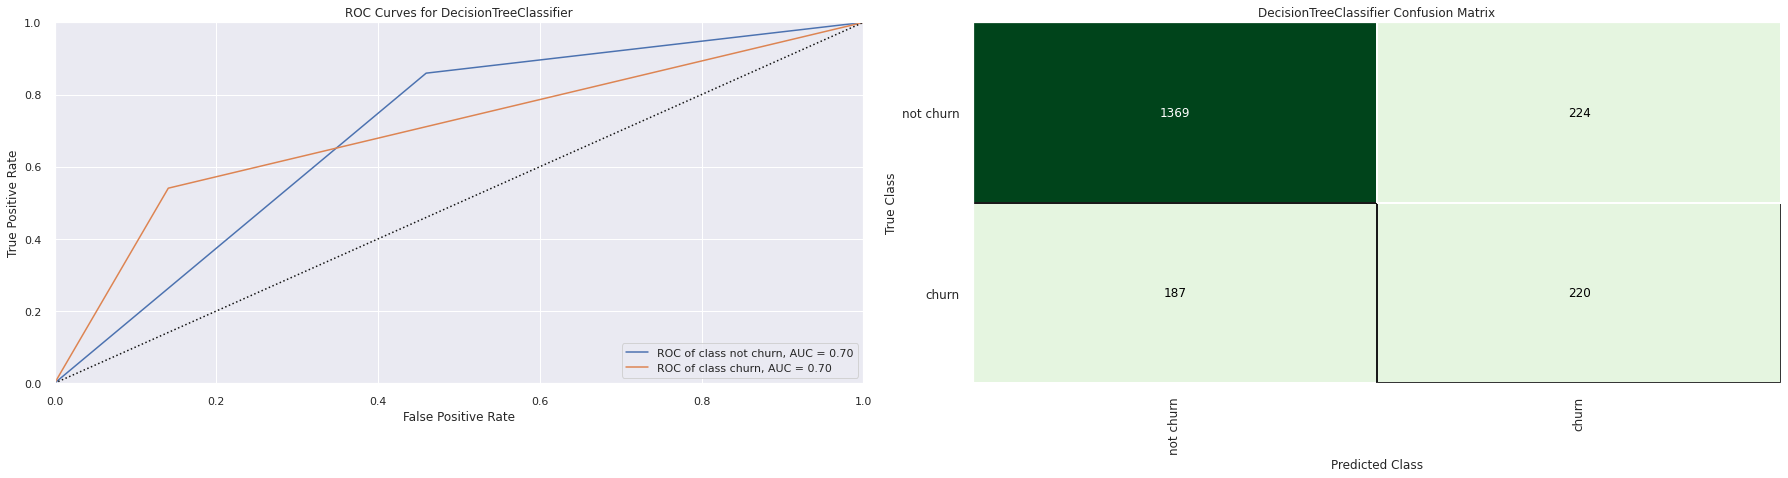

In [321]:
# run name
mlflow.start_run(run_name='decision_tree_churn_predictions')
mlflow.set_tag('Train','V1')

# local path to artifacts
export_path = "file:///mlruns/1/artifacts/{run_id}/{artifact_path}".format(run_id=mlflow.active_run().info.run_id,artifact_path="model")
experiment = mlflow.get_experiment_by_name("Bank Customers Churn Predictions")
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))

# model definition and train
model_dtc= DecisionTreeClassifier(random_state=32).fit(X_train, y_train)

if os.path.exists(export_path) == False:
    mlflow.sklearn.save_model(model_dtc, path=export_path)
    mlflow.log_artifacts(export_path, "decision_tree")
    mlflow.log_params( {'random_state':32})  

else:
    mlflow.log_artifacts(export_path, "decision_tree")
    mlflow.log_params( {'random_state':32})  

#graphs
plt.subplot(2,2,1)
rocauc(model_dtc)


plt.subplot(2,2,2)
confusion_matrix1(model_dtc)
plt.savefig("/home/tc0019/DS/topbottombank/reports/roc_and_conf_decision_tree.png")
mlflow.log_artifact("/home/tc0019/DS/topbottombank/reports/roc_and_conf_decision_tree.png")

# predict
yhat_dtc=model_dtc.predict(x_validation)
y_probas_dtc = model_dtc.predict_proba(x_validation)
a=accuracy_score(y_validation, yhat_dtc).round(2)
recall = recall_score(y_validation, yhat_dtc, average='binary').round(2)
precision = precision_score(y_validation, yhat_dtc, average='binary').round(2)
mlflow.log_metrics({'Accuracy':a, 'Recall':recall, 'Precision':precision})
print("Acurácia Decision Tree= ", accuracy_score(y_validation, yhat_dtc))
mlflow.end_run()

## 7.3 Random Forest

Advantages
- It is efficient when it comes to large datasets.
- It allows estimating the significance of input variables in classification.
- It is more accurate than decision trees.

Disadvantages
- It is more complex when it comes to implementation and thus takes more time to evaluate.

**random forest common hyperparameters:** n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, boostrap

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

Experiment_id: 4
Artifact Location: file:///home/tc0019/mlruns/4


2022/06/06 23:36:55 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: file:///mlruns/1/artifacts/70e09e508211493aa4a38722af63ee97/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


Acurácia Random Forest=  0.863


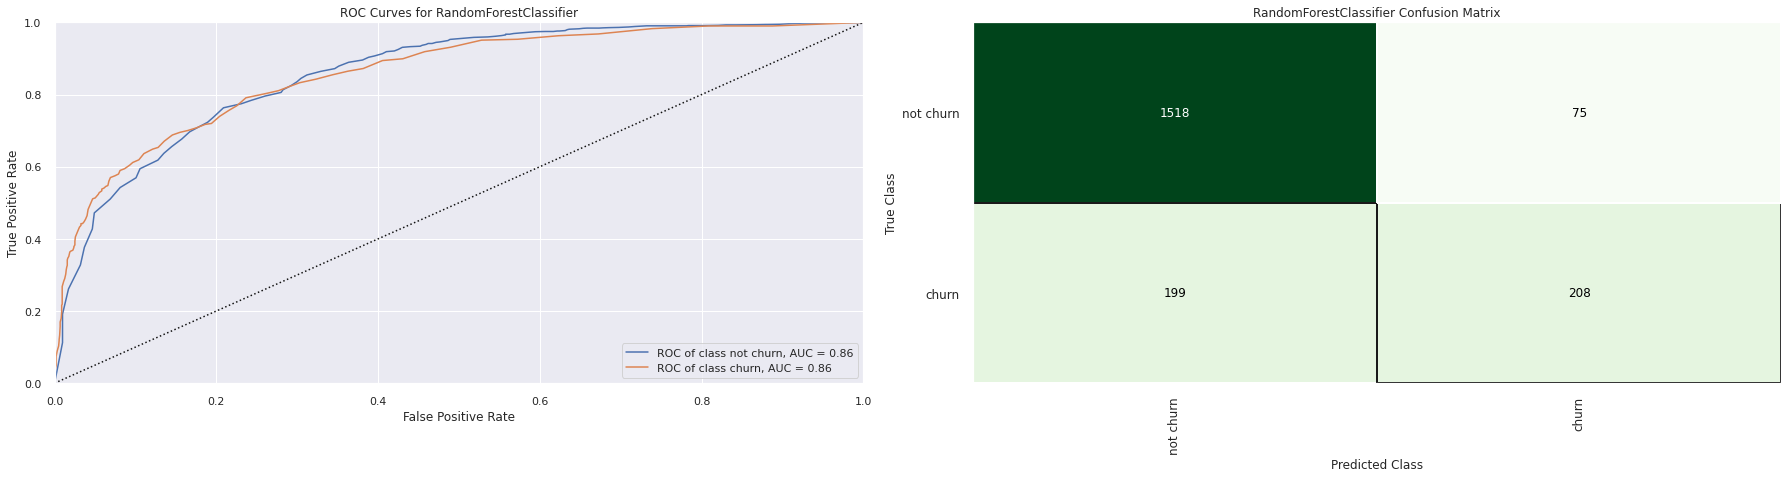

In [322]:
# run name
mlflow.start_run(run_name='random_forest_churn_predictions')
mlflow.set_tag('Train','V1')

# local path to artifacts
export_path = "file:///mlruns/1/artifacts/{run_id}/{artifact_path}".format(run_id=mlflow.active_run().info.run_id,artifact_path="model")
experiment = mlflow.get_experiment_by_name("Bank Customers Churn Predictions")
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))

# model definition and train
model_rf=RandomForestClassifier(random_state=32, n_jobs=-1).fit(X_train, y_train)

if os.path.exists(export_path) == False:
    mlflow.sklearn.save_model(model_rf, path=export_path)
    mlflow.log_artifacts(export_path, "random_forest")
    mlflow.log_params( {'random_state':32, 'n_jobs':-1})  

else:
    mlflow.log_artifacts(export_path, "random_forest")
    mlflow.log_params( {'random_state':32, 'n_jobs':-1})  

#graphs
plt.subplot(2,2,1)
rocauc(model_rf)


plt.subplot(2,2,2)
confusion_matrix1(model_rf)
plt.savefig("/home/tc0019/DS/topbottombank/reports/roc_and_conf_random_forest.png")
mlflow.log_artifact("/home/tc0019/DS/topbottombank/reports/roc_and_conf_random_forest.png")

# predict
y_probas_rf = model_rf.predict_proba(x_validation)
yhat_rf=model_rf.predict(x_validation)
a=accuracy_score(y_validation, yhat_rf).round(2)
recall = recall_score(y_validation, yhat_rf, average='binary').round(2)
precision = precision_score(y_validation, yhat_rf, average='binary').round(2)
mlflow.log_metrics({'Accuracy':a, 'Recall':recall, 'Precision':precision})
print("Acurácia Random Forest= ", accuracy_score(y_validation, yhat_rf))
mlflow.end_run()

## 7.4 Support Vector Machine (SVM)

Advantages
- It makes training the dataset easy.
- It performs well when the data is high-dimensional.


Disadvantages
- It doesn't perform well when the data has noisy elements.
- It is sensitive to kernel functions, so they have to be chosen wisely.

support vector machine common hyperparameters: c, kernel, gamma

https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/

Experiment_id: 4
Artifact Location: file:///home/tc0019/mlruns/4


2022/06/06 23:37:00 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: file:///mlruns/1/artifacts/efcf16cafe2942a88ed78474b87f6c2c/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


Acurácia SVM =  0.7965


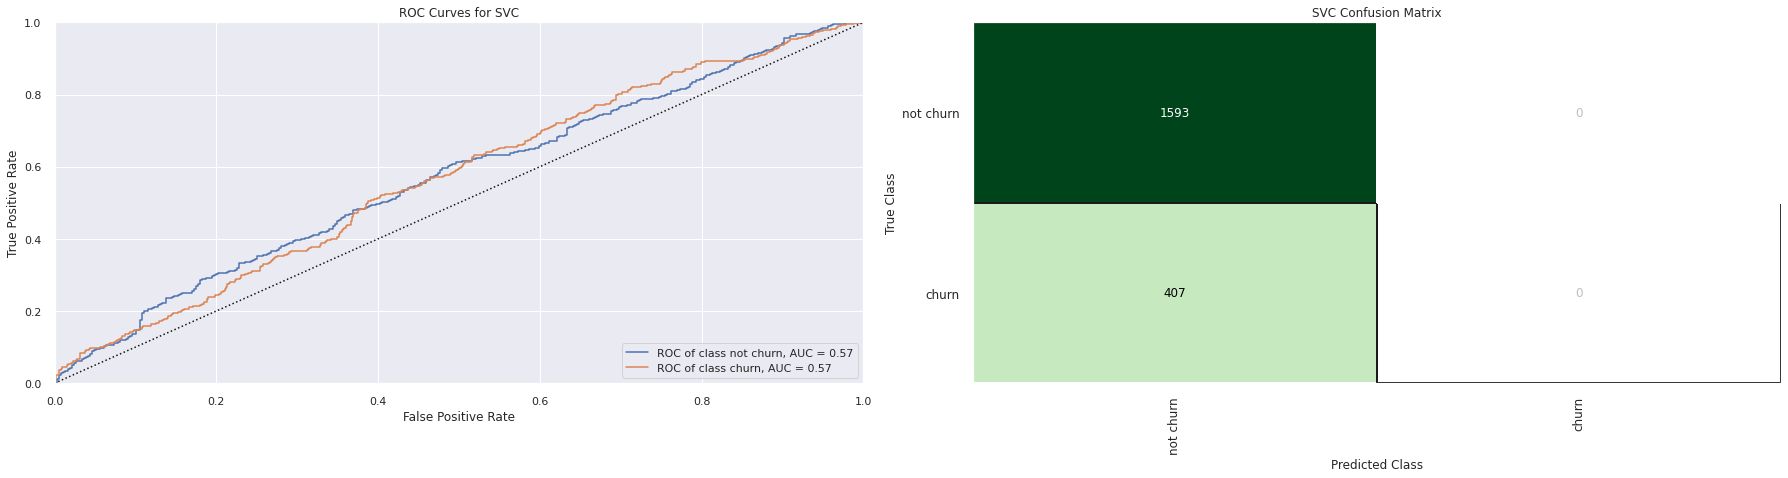

In [323]:
# run name
mlflow.start_run(run_name='svm_churn_predictions')
mlflow.set_tag('Train','V1')

# local path to artifacts
export_path = "file:///mlruns/1/artifacts/{run_id}/{artifact_path}".format(run_id=mlflow.active_run().info.run_id,artifact_path="model")
experiment = mlflow.get_experiment_by_name("Bank Customers Churn Predictions")
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))

# model definition and train
model_svm=SVC(random_state=32,probability=True).fit(X_train, y_train)

if os.path.exists(export_path) == False:
    mlflow.sklearn.save_model(model_svm, path=export_path)
    mlflow.log_artifacts(export_path, "SVM")
    mlflow.log_params( {'random_state':32,"probability":True})  

else:
    mlflow.log_artifacts(export_path, "SVM")
    mlflow.log_params( {'n_neighbors':10})  

#graphs
plt.subplot(2,2,1)
rocauc(model_svm)


plt.subplot(2,2,2)
confusion_matrix1(model_svm)
plt.savefig("/home/tc0019/DS/topbottombank/reports/roc_and_conf_svm.png")
mlflow.log_artifact("/home/tc0019/DS/topbottombank/reports/roc_and_conf_svm.png")

# predict
yhat_svm=model_svm.predict(x_validation)
y_probas_svm = model_svm.predict_proba(x_validation)
a=accuracy_score(y_validation, yhat_svm).round(2)
recall = recall_score(y_validation, yhat_svm, average='binary').round(2)
precision = precision_score(y_validation, yhat_svm, average='binary').round(2)
mlflow.log_metrics({'Accuracy':a, 'Recall':recall, 'Precision':precision})
print("Acurácia SVM = ", accuracy_score(y_validation, yhat_svm))
mlflow.end_run()

## 7.5 K-Nearest Neighbour (KNN Classifier)

Advantages
- One can apply it to datasets of any distribution.
- It is easy to understand and is quite intuitive.

Disadvantages
- It is easily affected by outliers.
- It is biased towards a class that has more instances in the dataset.
- It is sometimes challenging to find the optimal number for K.

KNN common hyperparameters: n_neighbors, weights, leaf_size, p

https://medium.datadriveninvestor.com/k-nearest-neighbors-in-python-hyperparameters-tuning-716734bc557f?gi=6ace5ed01f38

2022/06/06 23:37:02 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: file:///mlruns/1/artifacts/96cda61b2353413b9303d0062e3da464/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


Experiment_id: 4
Artifact Location: file:///home/tc0019/mlruns/4
Acurácia KNN =  0.787


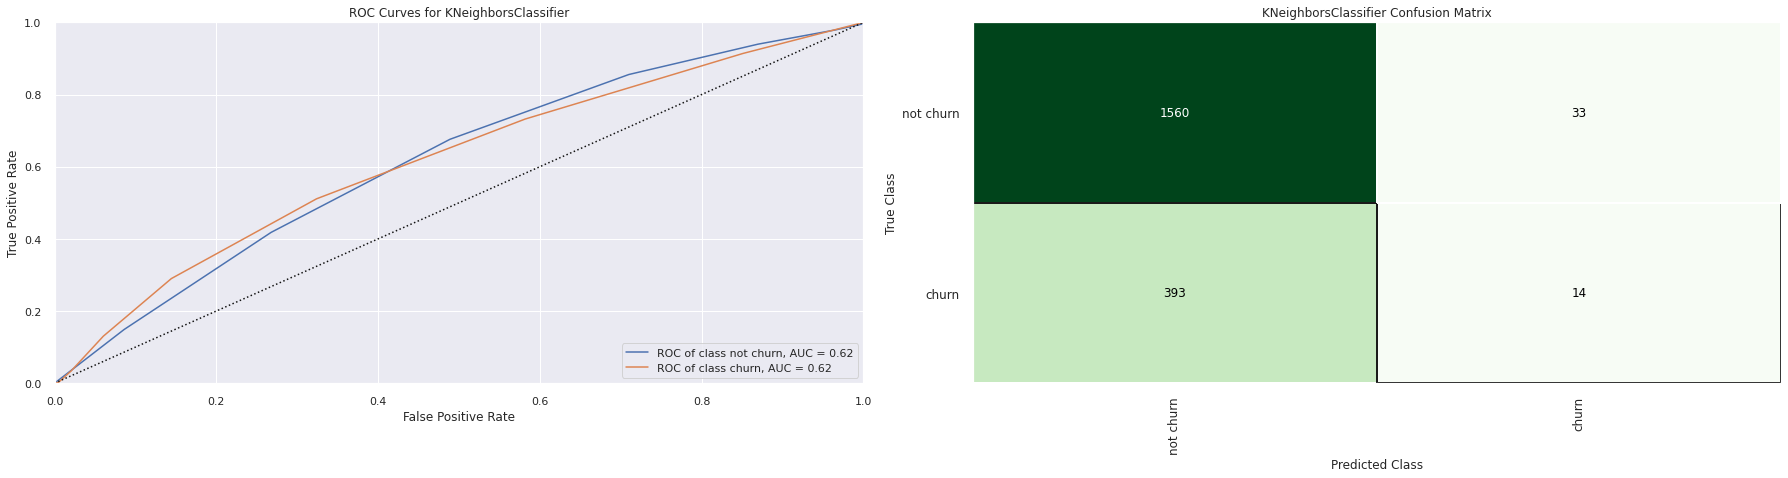

In [324]:
# run name
mlflow.start_run(run_name='knn_churn_predictions')
mlflow.set_tag('Train','V1')

# local path to artifacts
export_path = "file:///mlruns/1/artifacts/{run_id}/{artifact_path}".format(run_id=mlflow.active_run().info.run_id,artifact_path="model")
experiment = mlflow.get_experiment_by_name("Bank Customers Churn Predictions")
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))

# model definition and train
model_knn = nh.KNeighborsClassifier( n_neighbors=10 ).fit( X_train, y_train )

if os.path.exists(export_path) == False:
    mlflow.sklearn.save_model(model_knn, path=export_path)
    mlflow.log_artifacts(export_path, "KNN")
    mlflow.log_params( {'n_neighbors':10})  

else:
    mlflow.log_artifacts(export_path, "KNN")
    mlflow.log_params( {'n_neighbors':10})  

#graphs
plt.subplot(2,2,1)
rocauc(model_knn)


plt.subplot(2,2,2)
confusion_matrix1(model_knn)
plt.savefig("/home/tc0019/DS/topbottombank/reports/roc_and_conf_knn.png")
mlflow.log_artifact("/home/tc0019/DS/topbottombank/reports/roc_and_conf_knn.png")

# predict
yhat_knn = model_knn.predict( x_validation )
y_probas_knn = model_knn.predict_proba(x_validation)
a=accuracy_score(y_validation, yhat_knn).round(2)
recall = recall_score(y_validation, yhat_knn, average='binary').round(2)
precision = precision_score(y_validation, yhat_knn, average='binary').round(2)
mlflow.log_metrics({'Accuracy':a, 'Recall':recall, 'Precision':precision})
print("Acurácia KNN = ", accuracy_score(y_validation, yhat_knn))
mlflow.end_run()


## 7.6 Naive Bayes

Advantages
- It gives good results for complex real-world problems.
- The time required by the machine to learn the pattern using this classifier is less.
- It performs well in the case where the input variables have categorical values. (not this case)
- It performs well in the case of multi-class classification.(not this case)


Disadvantages


- It assumes independence among feature variables which may not always be the case.
- We often refer to it as a bad estimator, and hence the probabilities are not always of great significance.
- If, during the training time, the model was not aware of any of the categorical variables and that variable is passed during testing, the model assigns 0 (zero) likelihood and thus substitutes zero probability referred to as 'zero frequency.' One can avoid this situation by using smoothing procedures such as Laplace estimation.


**gaussian naive bayes common hyperparameters**: priors, var_smoothing

https://www.analyticsvidhya.com/blog/2021/01/gaussian-naive-bayes-with-hyperpameter-tuning/



2022/06/06 23:37:06 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: file:///mlruns/1/artifacts/6d0f0fe73dc14f72b80ebd22feb3e9ed/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.0.0']. Set logging level to DEBUG to see the full traceback.


Experiment_id: 4
Artifact Location: file:///home/tc0019/mlruns/4
Acurácia Naive Bayes =  0.784


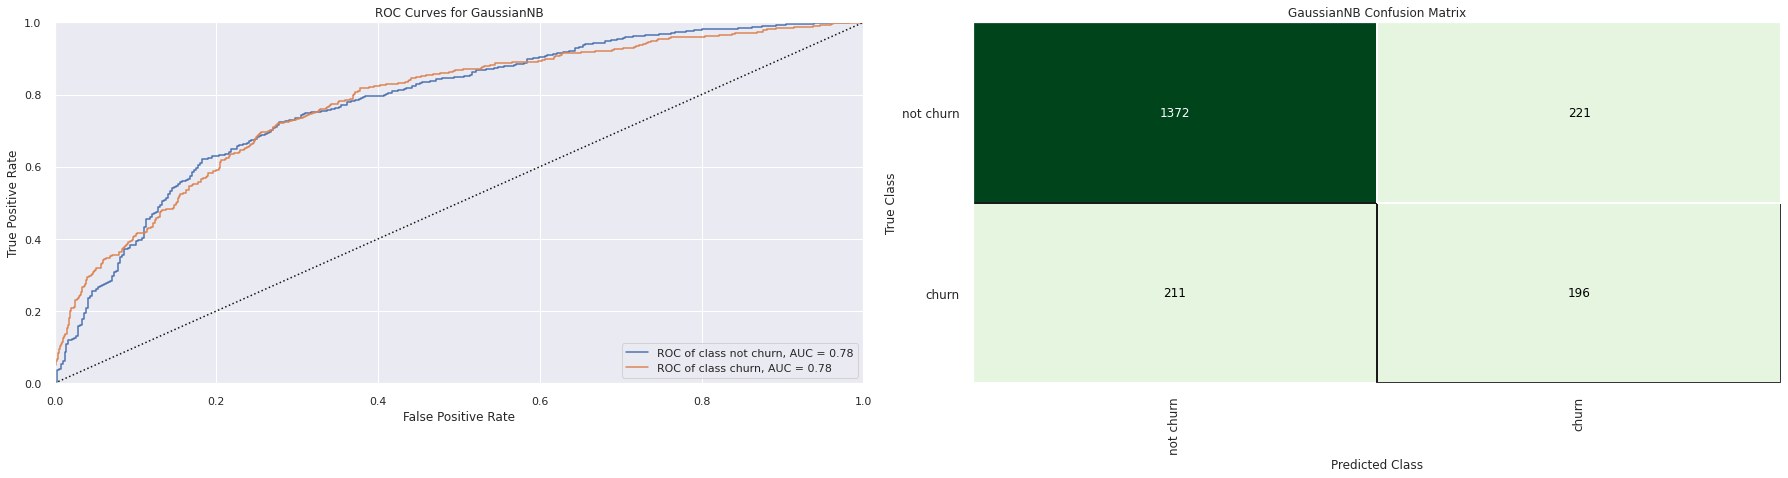

In [325]:
# run name
mlflow.start_run(run_name='naive_bayes_churn_predictions')
mlflow.set_tag('Train','V1')

# local path to artifacts
export_path = "file:///mlruns/1/artifacts/{run_id}/{artifact_path}".format(run_id=mlflow.active_run().info.run_id,artifact_path="model")
experiment = mlflow.get_experiment_by_name("Bank Customers Churn Predictions")
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))

# model definition and train
model_gnb= GaussianNB(priors=None, var_smoothing=1e-09).fit(X_train, y_train)

if os.path.exists(export_path) == False:
    mlflow.sklearn.save_model(model_gnb, path=export_path)
    mlflow.log_artifacts(export_path, "Naive Bayes")
    mlflow.log_params( {'priors':None, 'var_smoothing':1e-09})  

else:
    mlflow.log_artifacts(export_path, "Naive Bayes")
    mlflow.log_params( {'priors':None, 'var_smoothing':1e-09})  

#graphs
plt.subplot(2,2,1)
rocauc(model_gnb)


plt.subplot(2,2,2)
confusion_matrix1(model_gnb)
plt.savefig("/home/tc0019/DS/topbottombank/reports/roc_and_conf_gnb.png")
mlflow.log_artifact("/home/tc0019/DS/topbottombank/reports/roc_and_conf_gnb.png")

# predict
yhat_gnb= model_gnb.predict(x_validation)
y_probas_gnb = model_gnb.predict_proba(x_validation)
a=accuracy_score(y_validation, yhat_gnb).round(2)
recall = recall_score(y_validation, yhat_gnb, average='binary').round(2)
precision = precision_score(y_validation, yhat_gnb, average='binary').round(2)
mlflow.log_metrics({'Accuracy':a, 'Recall':recall, 'Precision':precision})
print("Acurácia Naive Bayes = ", accuracy_score(y_validation, yhat_gnb))
mlflow.end_run()

## 7.7 XGBoost

Experiment_id: 4
Artifact Location: file:///home/tc0019/mlruns/4
[23:37:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Acurácia XGBoost =  0.86


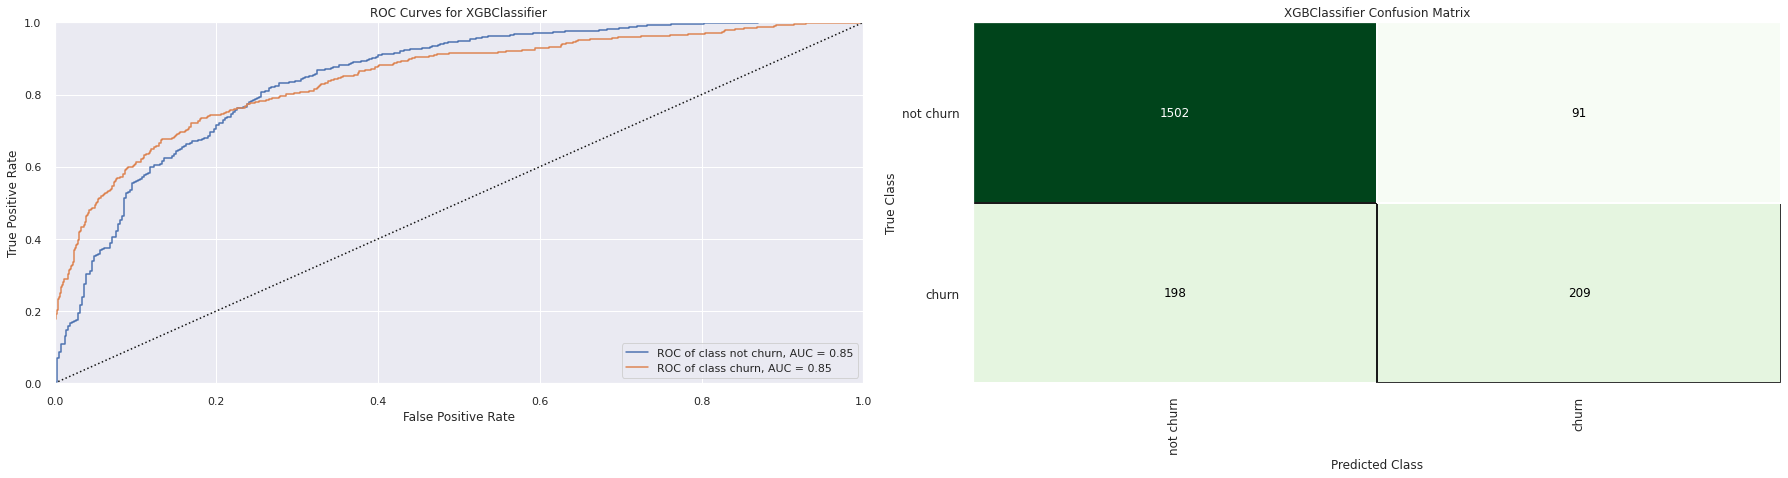

In [326]:
# run name
mlflow.start_run(run_name='xgboost_churn_predictions')
mlflow.set_tag('Train','V1')

# local path to artifacts
export_path = "file:///mlruns/1/artifacts/{run_id}/{artifact_path}".format(run_id=mlflow.active_run().info.run_id,artifact_path="model")
experiment = mlflow.get_experiment_by_name("Bank Customers Churn Predictions")
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))

# model definition and fit
model_xgb = xgb.XGBClassifier( random_state=32, n_jobs=-1).fit(X_train, y_train)


if os.path.exists(export_path) == False:
    mlflow.xgboost.save_model(model_xgb, path=export_path)
    mlflow.log_artifacts(export_path, "xgboost")
    mlflow.log_params( {'objective':'binary:logistic', 'n_jobs':-1, 'eval_metric':'logloss'}) 

else:
    mlflow.log_artifacts(export_path, "xgboost")
    mlflow.log_params( {'objective':'binary:logistic', 'n_jobs':-1, 'eval_metric':'logloss'})  

#graphs
plt.subplot(2,2,1)
rocauc(model_xgb)


plt.subplot(2,2,2)
confusion_matrix1(model_xgb)
plt.savefig("/home/tc0019/DS/topbottombank/reports/roc_and_conf_xgb.png")
mlflow.log_artifact("/home/tc0019/DS/topbottombank/reports/roc_and_conf_xgb.png")     

# prediction
yhat_xgb = model_xgb.predict(x_validation)
y_probas_xgb = model_xgb.predict_proba(x_validation)
a=accuracy_score(y_validation, yhat_xgb).round(2)
recall = recall_score(y_validation, yhat_xgb, average='binary').round(2)
precision = precision_score(y_validation, yhat_xgb, average='binary').round(2)
mlflow.log_metrics({'Accuracy':a, 'Recall':recall, 'Precision':precision})
mlflow.end_run()
print("Acurácia XGBoost = ", a)



## 7.8 Catboost

https://www.mlflow.org/reports/latest/python_api/mlflow.html#mlflow.log_param

Experiment_id: 4
Artifact Location: file:///home/tc0019/mlruns/4
Acurácia CatBoost =  0.8625


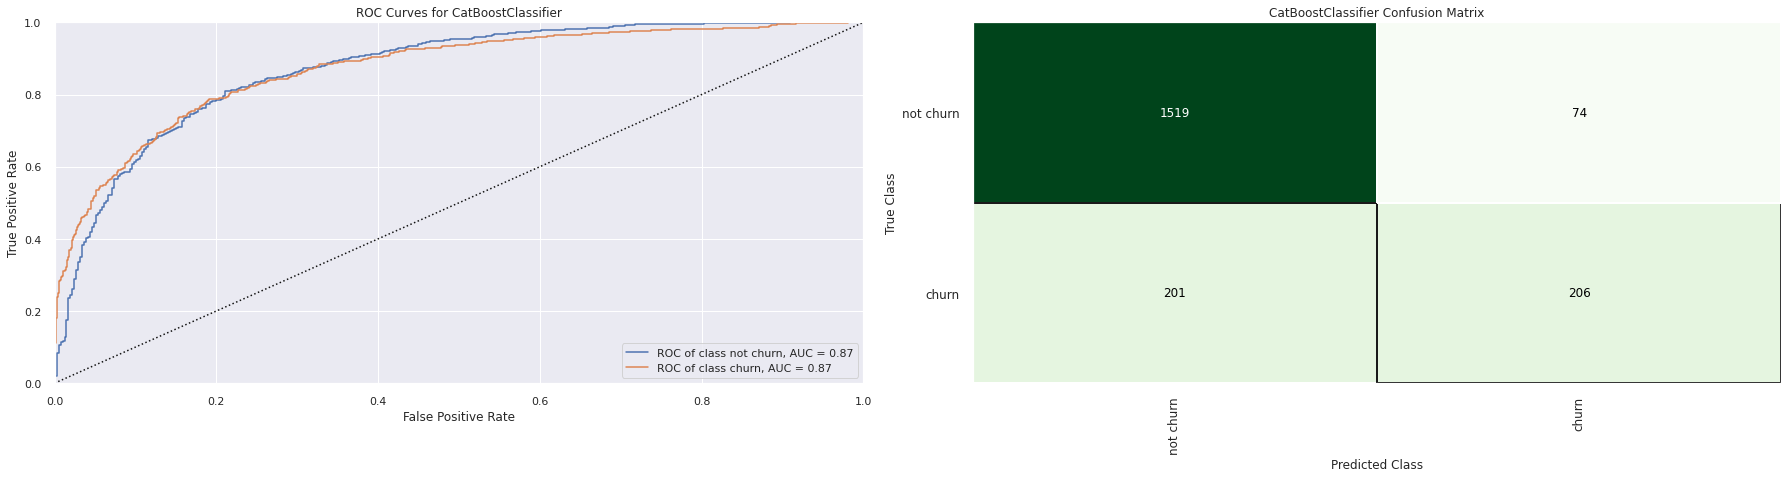

In [327]:
# run name
mlflow.start_run(run_name='catboost_churn_predictions')
mlflow.set_tag('Train','V1')

# local path to artifacts
export_path = "file:///mlruns/1/artifacts/{run_id}/{artifact_path}".format(run_id=mlflow.active_run().info.run_id,artifact_path="model")
experiment = mlflow.get_experiment_by_name("Bank Customers Churn Predictions")
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))

# model definition and fit
model_cat = CatBoostClassifier(iterations= 500, logging_level= 'Silent', random_state= 32).fit(X_train, y_train)


if os.path.exists(export_path) == False:
    mlflow.catboost.save_model(model_cat, path=export_path)
    mlflow.log_artifacts(export_path, "catboost")
    mlflow.log_params( {'depth': 9, 'eval_metric': 'BalancedAccuracy', 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.03, 'logging_level': 'Silent', 'random_state': 32})

else:
    mlflow.log_artifacts(export_path, "catboost")
    mlflow.log_params( {'depth': 9, 'eval_metric': 'BalancedAccuracy', 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.03, 'logging_level': 'Silent', 'random_state': 32}) 


#graphs
plt.subplot(2,2,1)
rocauc(model_cat)


plt.subplot(2,2,2)
confusion_matrix1(model_cat)
plt.savefig("/home/tc0019/DS/topbottombank/reports/roc_and_conf_cat.png")
mlflow.log_artifact("/home/tc0019/DS/topbottombank/reports/roc_and_conf_cat.png")


# prediction
yhat_cat=model_cat.predict(x_validation)
y_probas_cat = model_cat.predict_proba(x_validation)
a=accuracy_score(y_validation, yhat_cat).round(2)
recall = recall_score(y_validation, yhat_cat, average='binary').round(2)
precision = precision_score(y_validation, yhat_cat, average='binary').round(2)
mlflow.log_metrics({'Accuracy':a, 'Recall':recall, 'Precision':precision})
print("Acurácia CatBoost = ", accuracy_score(y_validation, yhat_cat))
mlflow.end_run()

In [302]:
# #CatBoost

# df_categories = ['num_of_products', 'is_active_member', 'tenure', 'geography_France', 'geography_Germany', 'geography_Spain']               

# params = {'iterations':500, 'random_seed':123, 'cat_features':df_categories, 'eval_metric':'BalancedAccuracy', 'verbose':False}

# cat_boost = CatBoostClassifier(**params)

# cat_boost.fit(X_train, y_train, eval_set=(x_validation, y_validation), use_best_model=True, plot=False)

## 7.9 Models Comparison

### 7.9.1 ROC Curve

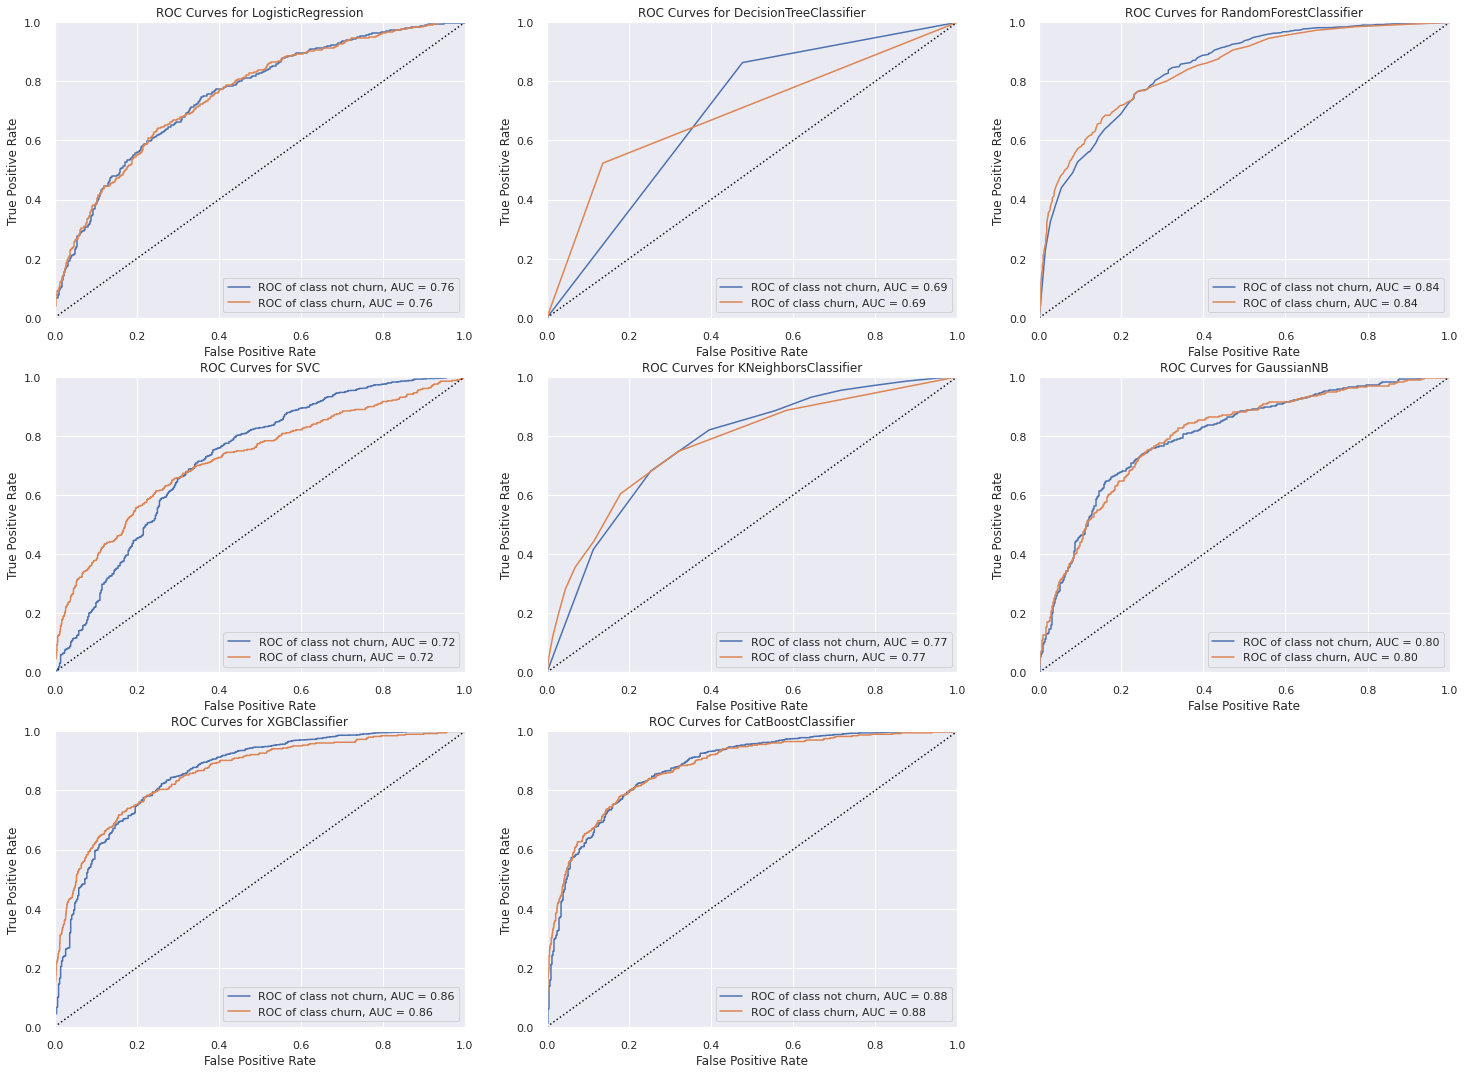

In [ ]:
fig, ax = plt.subplots(figsize= (25, 25))
plt.subplot(4,3,1)
rocauc(model_lr)

plt.subplot(4,3,2)
rocauc(model_dtc)

plt.subplot(4,3,3)
rocauc(model_rf)

plt.subplot(4,3,4)
rocauc(model_svm)

plt.subplot(4,3,5)
rocauc(model_knn)

plt.subplot(4,3,6)
rocauc(model_gnb)

plt.subplot(4,3,7)
rocauc(model_xgb)

plt.subplot(4,3,8)
rocauc(model_cat)
plt.savefig("/home/tc0019/DS/topbottombank/reports/model_roc_curves.png")


### 7.9.2 Confusion Matrix

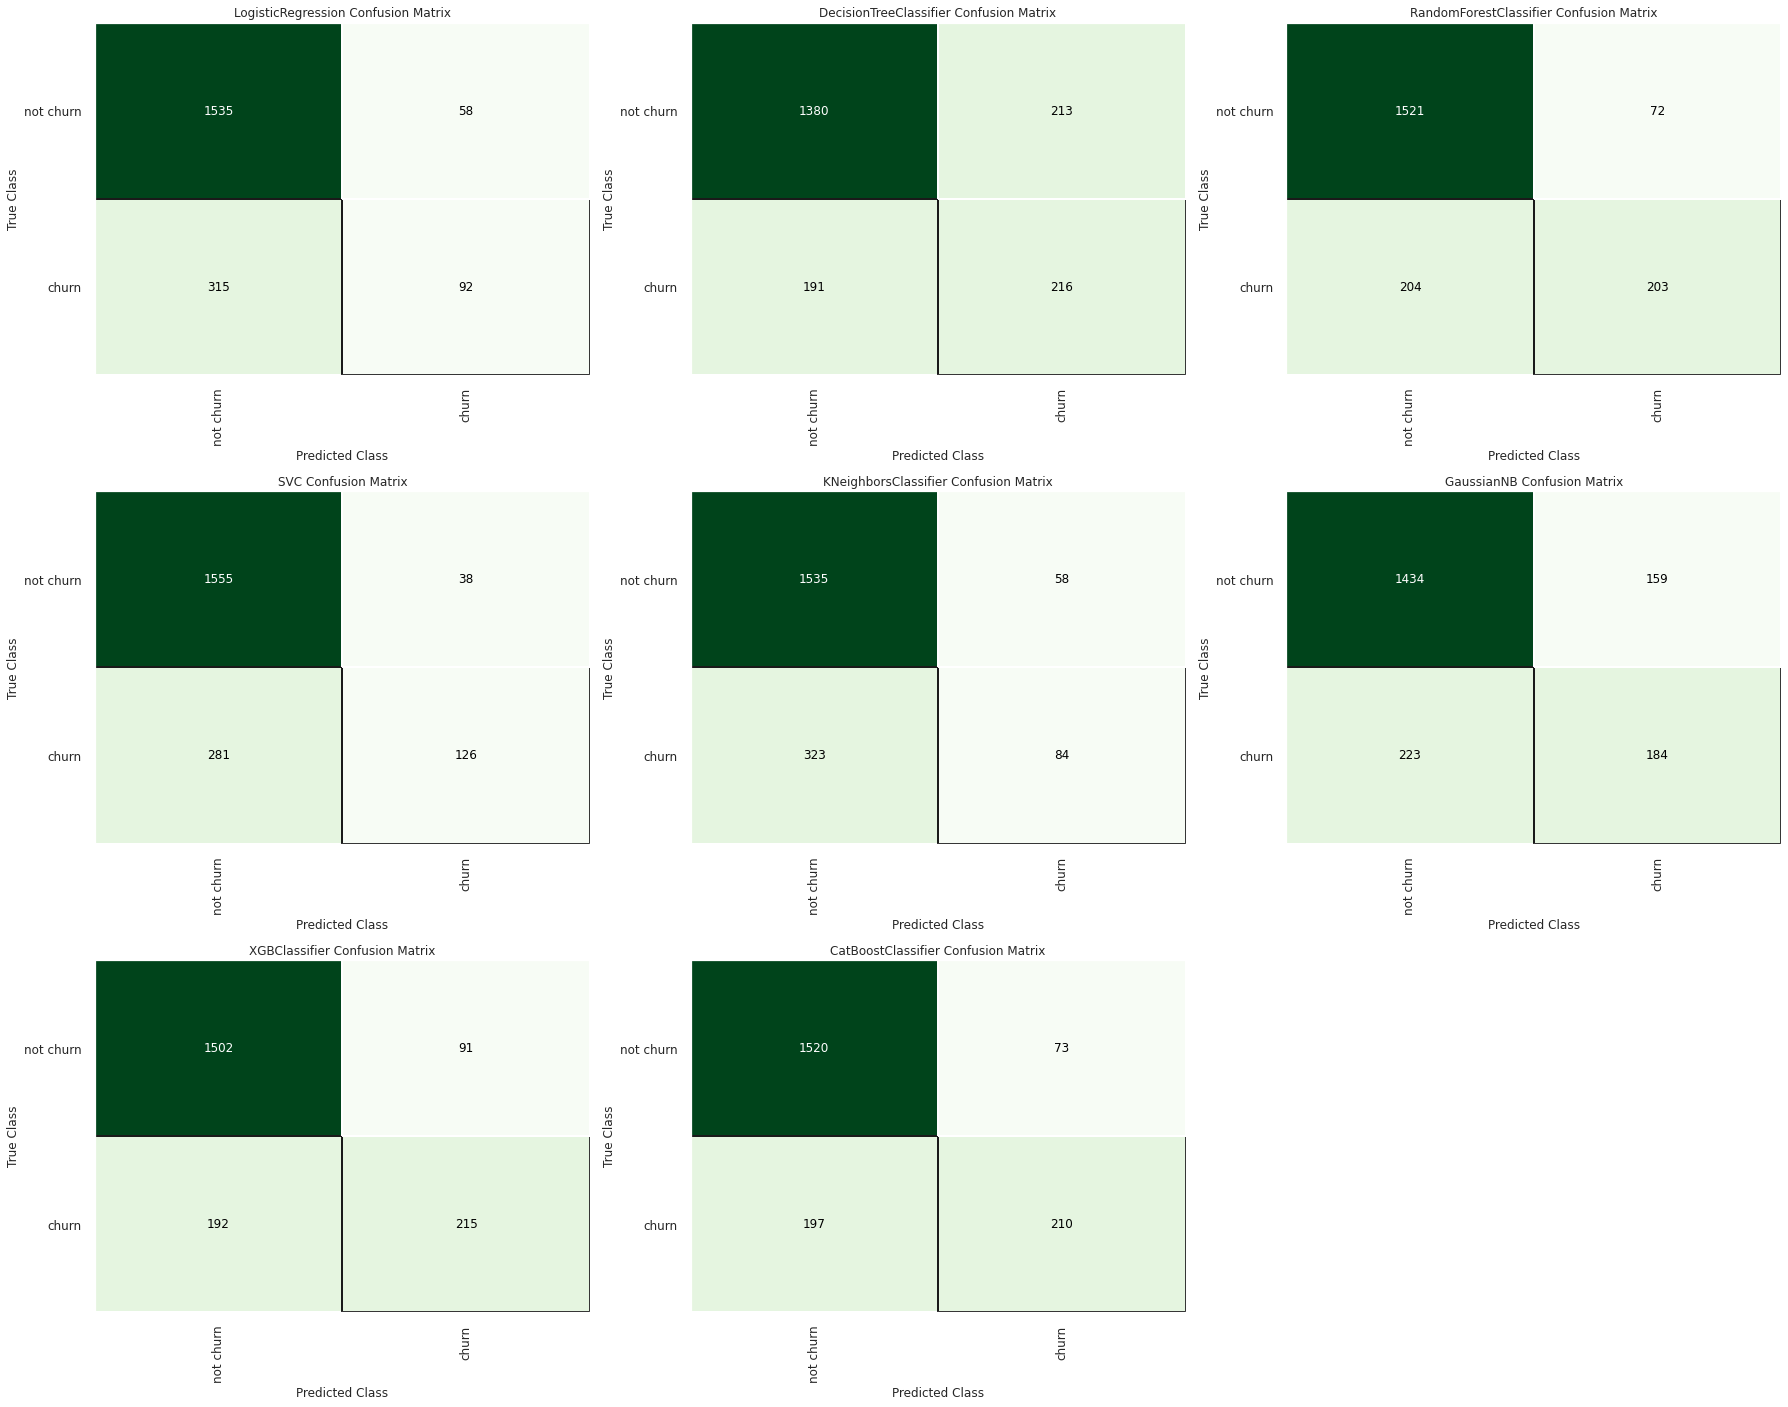

In [ ]:
fig, ax = plt.subplots(figsize= (25, 25))
plt.subplot(4,3,1)
confusion_matrix1(model_lr)

plt.subplot(4,3,2)
confusion_matrix1(model_dtc)

plt.subplot(4,3,3)
confusion_matrix1(model_rf)

plt.subplot(4,3,4)
confusion_matrix1(model_svm)

plt.subplot(4,3,5)
confusion_matrix1(model_knn)

plt.subplot(4,3,6)
confusion_matrix1(model_gnb)

plt.subplot(4,3,7)
confusion_matrix1(model_xgb)

plt.subplot(4,3,8)
confusion_matrix1(model_cat)
plt.savefig("/home/tc0019/DS/topbottombank/reports/models_confmat.png")

### 7.9.3 Classification Reports

- This report shows the precision, recall and F1 scores
- What are the top 3 best performance ?
    - Cat Boost
    - Random Forest
    - XGBoost

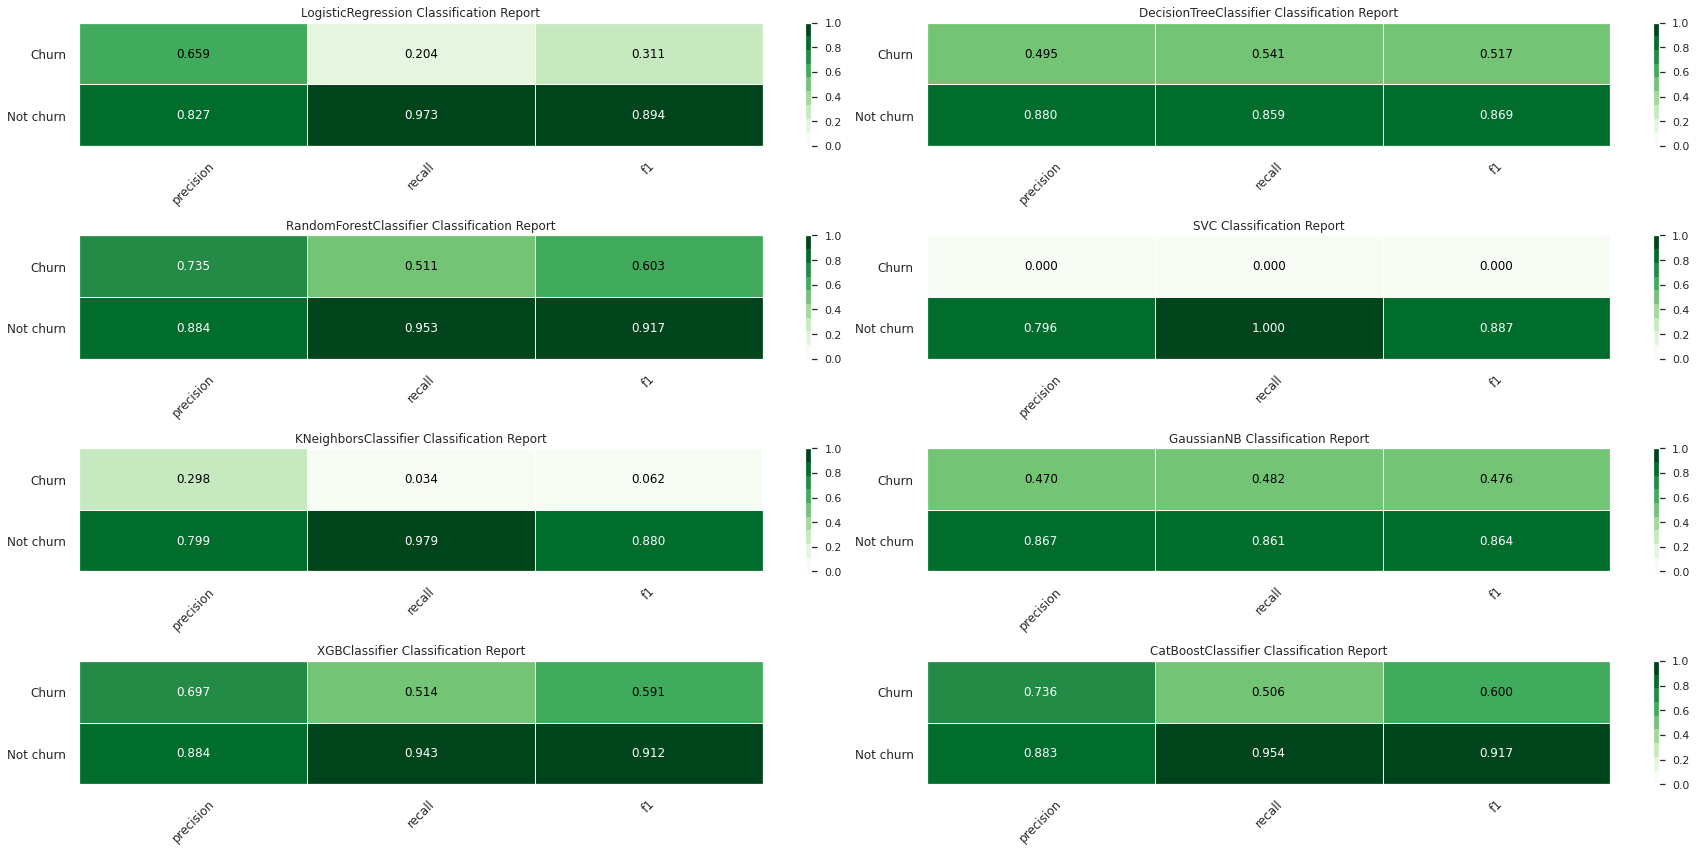

In [328]:
plt.subplot(4, 2, 1)
classification_report1(model_lr)

plt.subplot(4, 2, 2)
classification_report1(model_dtc)

plt.subplot(4, 2, 3)
classification_report1(model_rf)

plt.subplot(4, 2, 4)
classification_report1(model_svm)

plt.subplot(4, 2, 5)
classification_report1(model_knn)

plt.subplot(4, 2, 6)
classification_report1(model_gnb)

plt.subplot(4, 2, 7)
classification_report1(model_xgb)

plt.subplot(4, 2, 8)
classification_report1(wrap(model_cat))

plt.savefig("/home/tc0019/DS/topbottombank/reports/class_report_new.png")


### 7.9.4 Cumulative Gain Curve

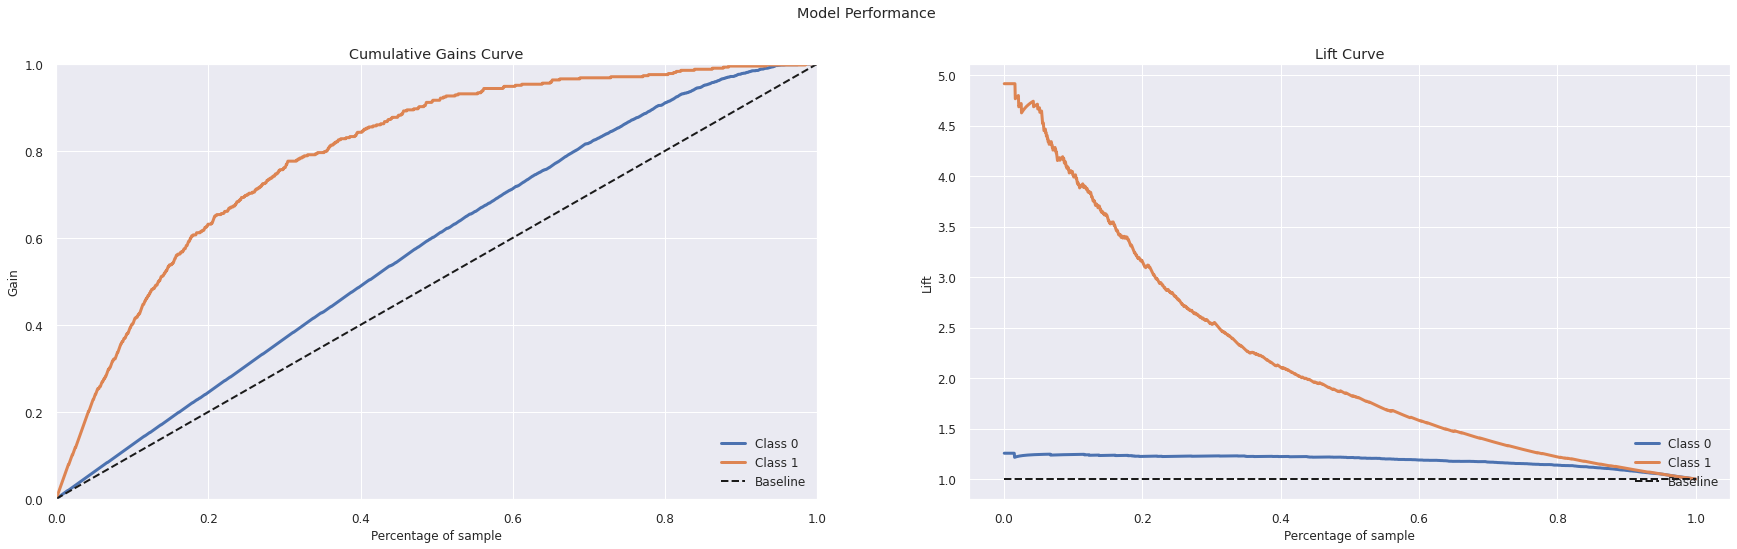

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(30,8))

fig.suptitle('Model Performance')

y_probas = model_cat.predict_proba(x_validation)
plot_cumulative_gain(y_validation, y_probas, ax=axes[0]);

plot_lift_curve(y_validation, y_probas, ax=axes[1]);
plt.savefig("/home/tc0019/DS/topbottombank/reports/cumulative_lift_curves.png")


### 7.9.5 Class Prediction Error

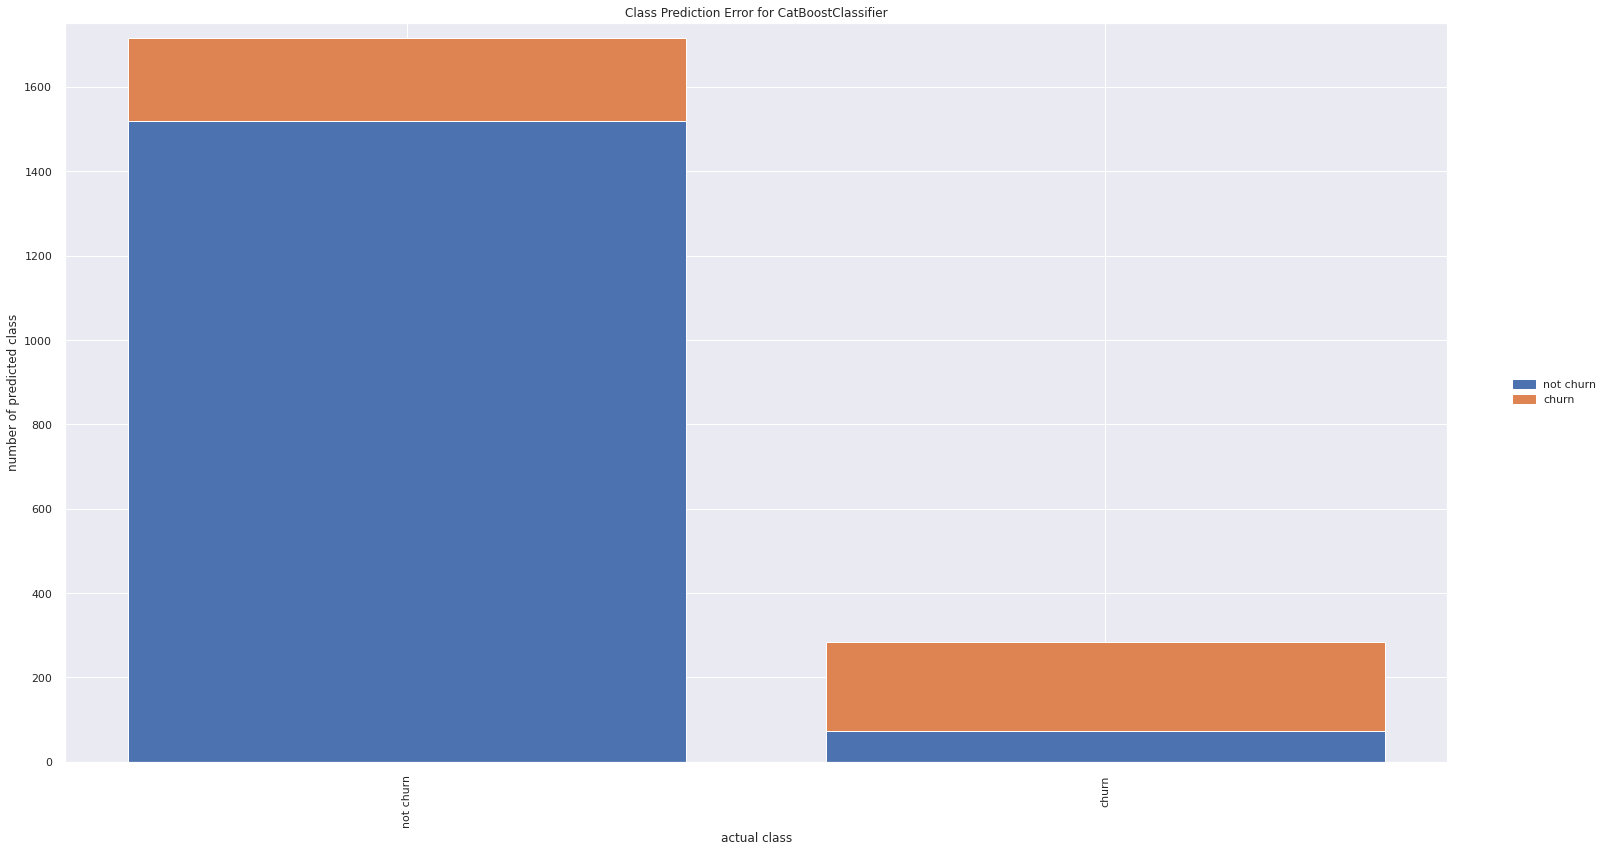

In [ ]:
cat_class_pred = ClassPredictionError(wrap(model_cat), classes=["not churn", "churn"])
cat_class_pred.score(x_validation, y_validation)
cat_class_pred.finalize()

### 7.9.6 KS Statistic
 The Kolmogorov-Smirnov Statistic is used only in binary classification problems. It is the maximum difference between the cumulative True Positive and False Positive rate. It captures the model's power of discriminating positive labels from a negative labels. Therefore, the greater the distance between both curves, the betterConclusion: CatBoost has the greater distance between the True Positive and False Positive curves

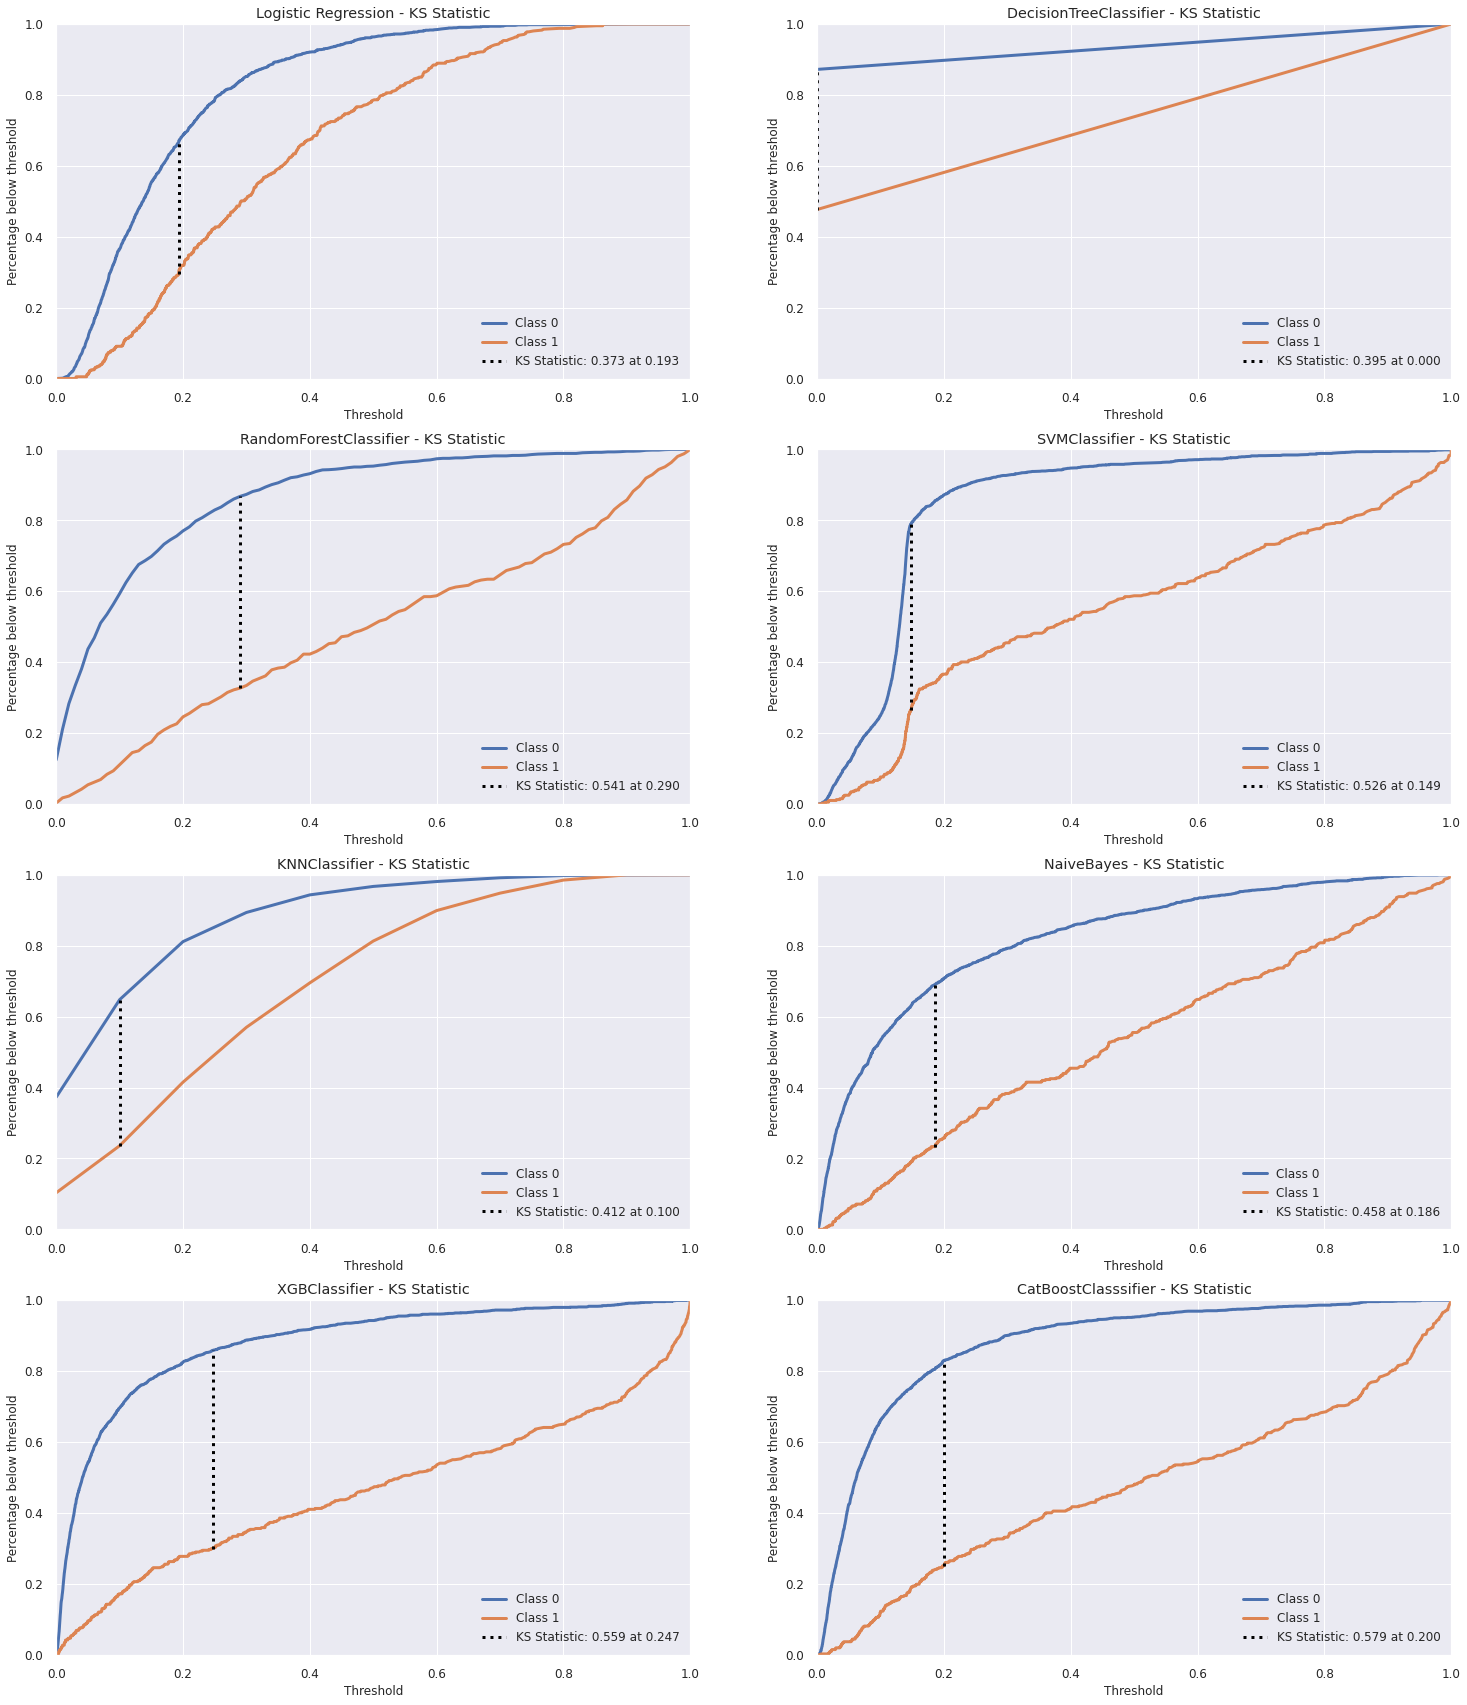

In [ ]:
#Plot Lift Curve
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2,figsize=(25, 30))

plot_ks_statistic(y_validation, y_probas_lr,  title='Logistic Regression - KS Statistic', ax=ax1);
plot_ks_statistic(y_validation, y_probas_dtc, title='DecisionTreeClassifier - KS Statistic', ax=ax2);
plot_ks_statistic(y_validation, y_probas_rf,  title='RandomForestClassifier - KS Statistic', ax=ax3) ;
plot_ks_statistic(y_validation, y_probas_svm, title='SVMClassifier - KS Statistic',ax=ax4) ; 
plot_ks_statistic(y_validation, y_probas_knn, title='KNNClassifier - KS Statistic',ax=ax5);  
plot_ks_statistic(y_validation, y_probas_gnb, title='NaiveBayes - KS Statistic',ax=ax6);  
plot_ks_statistic(y_validation, y_probas_xgb, title='XGBClassifier - KS Statistic',ax=ax7);
plot_ks_statistic(y_validation, y_probas_cat, title='CatBoostClasssifier - KS Statistic',ax=ax8);  
plt.savefig("/home/tc0019/DS/topbottombank/reports/ks_curve.png")


### 7.9.7 Learning Curves

In [ ]:
# plt.subplots(figsize=(30,8))

# plt.subplot(4, 2, 1)
# plot_learning_curve(model_lr, 'LogisticRegression', X, y, 10);

# plt.subplot(4, 2, 2)
# plot_learning_curve(model_dtc, 'DecisionTreeClassifier', X, y, 10);

# plt.subplot(4, 2, 3)
# plot_learning_curve(model_rf, 'RandomForestClassifier', X, y, 10);

# plt.subplot(4, 2, 4)
# plot_learning_curve(model_svm, 'SVMClassifier', X, y, 10);

# plt.subplot(4, 2, 5)
# plot_learning_curve(model_knn, 'KNNClassifier', X, y, 10);

# plt.subplot(4, 2, 6)
# plot_learning_curve(model_gnb, 'NaiveBayes', X, y, 10);

# plt.subplot(4, 2, 7)
# plot_learning_curve(model_xgb, 'XGBClassifier', X, y, 10);

# plt.subplot(4, 2, 8)
# plot_learning_curve(model_cat, 'CatBoostClasssifier', X, y, 10);

# plt.savefig("/home/tc0019/DS/topbottombank/reports/leaning_curves.png")



### 7.9.8 Precision-recall curve
 To analyse Precision and Recall is useful here because there is an imbalance between churn and not churn clients. This graph also shows the F1 scores (harmonic mean between precision and recall), therefore, the closer the curve gets to the F1 thresholds the betterConclusion:  CatBoost has a slightly better Average Precision of 

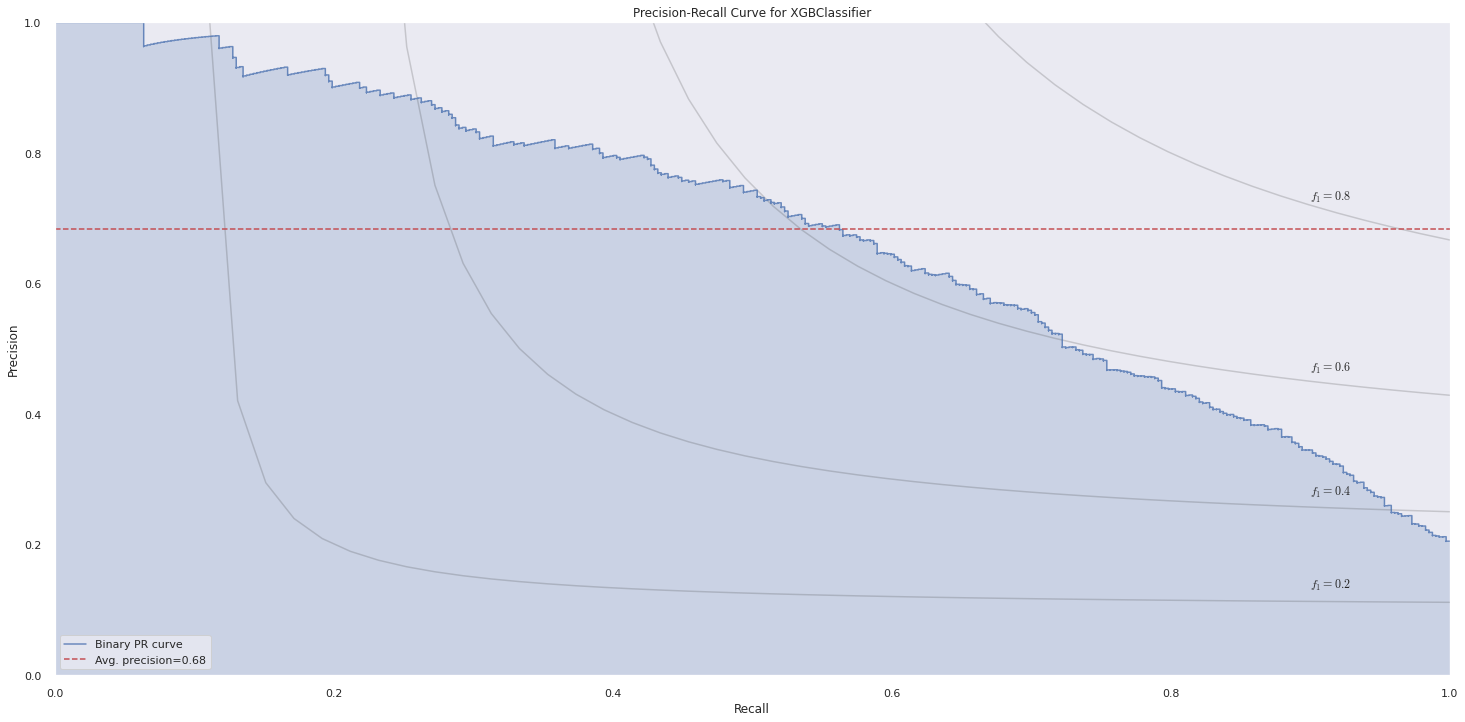

In [ ]:
# viz = PrecisionRecallCurve(model_cat, iso_f1_curves=True, ax=ax1)
viz = PrecisionRecallCurve(model_xgb, iso_f1_curves=True)
viz.fit(X_train, y_train)
viz.score(x_validation, y_validation)
viz.finalize()

 
# plt.savefig("/home/tc0019/DS/topbottombank/reports/precision_recall_curve.png")


### 7.9.9 Calibration Curve

In [ ]:
probas_list=[y_probas_lr, y_probas_dtc, y_probas_rf, y_probas_svm, y_probas_knn, y_probas_gnb, y_probas_xgb, y_probas_cat]
clf_names=['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'SVMClassifier', 'KNNClassifier', 'NaiveBayes', 'XGBClassifier', 'CatBoostClassifier']


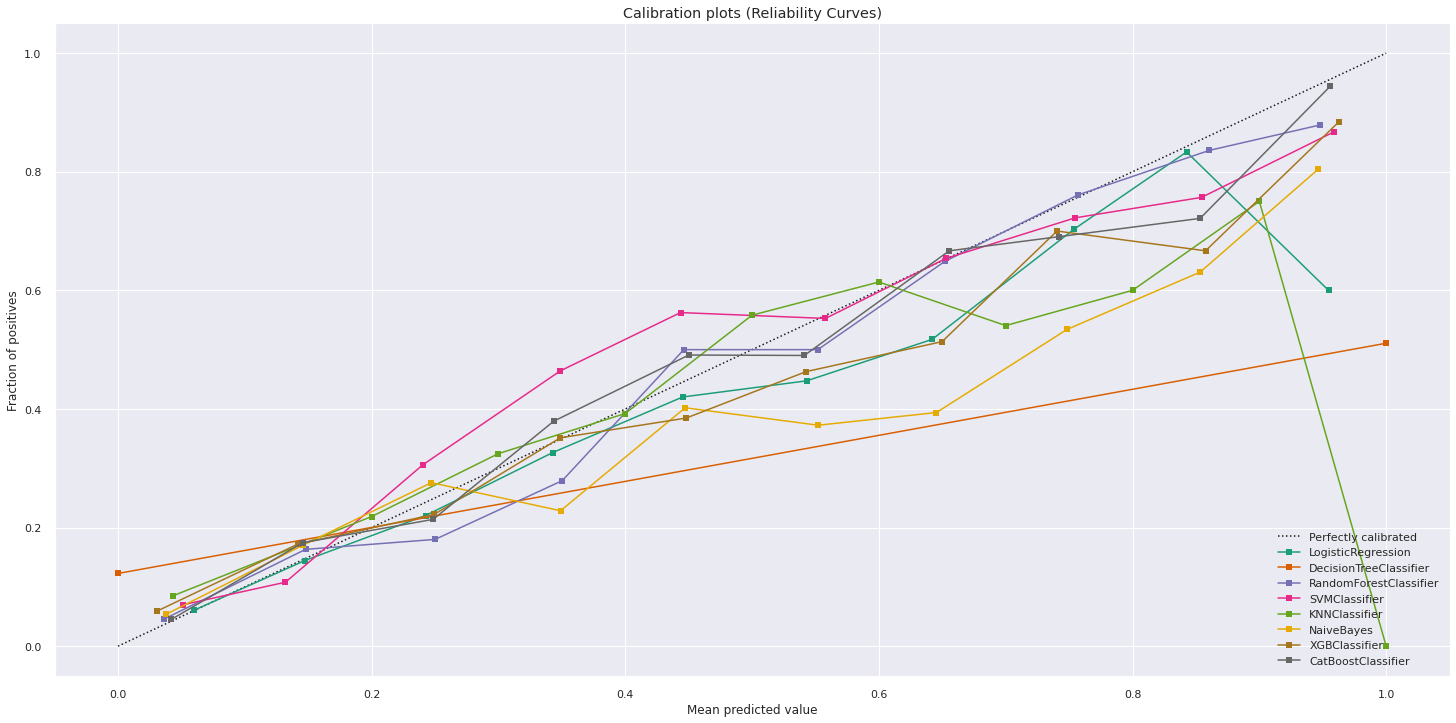

In [ ]:
plot_calibration_curve(y_validation, probas_list, n_bins=10, clf_names=clf_names,title='Calibration plots (Reliability Curves)', cmap='Dark2');

## 7.10 Conclusion Before Fine-Tuning 

In [ ]:
models = [model_lr, model_dtc, model_rf, model_svm, model_knn, model_gnb, model_xgb, model_cat]
models_metrics=pd.DataFrame(model_metrics(models, y_validation))
models_metrics.round(2).sort_values('ROCAUC',ascending=False)

Model Name  Accuracy  Precision  Recall  F1-Score  ROCAUC
7      CatBoostClassifier      0.86       0.74    0.52      0.61    0.88
2  RandomForestClassifier      0.86       0.73    0.49      0.59    0.86
6           XGBClassifier      0.86       0.70    0.53      0.60    0.85
3                     SVC      0.84       0.80    0.27      0.40    0.82
5              GaussianNB      0.80       0.51    0.44      0.48    0.80
0      LogisticRegression      0.81       0.60    0.22      0.32    0.76
4    KNeighborsClassifier      0.81       0.59    0.19      0.28    0.76
1  DecisionTreeClassifier      0.80       0.51    0.52      0.52    0.70

In [ ]:
asd

NameError: name 'asd' is not defined

# 8.0. HYPERPARAMETER FINE TUNING

There are several approaches to hyperparameter tuning. In this CRISP cycle I will be focusing on **Grid Search**
https://medium.com/aiplusoau/hyperparameter-tuning-a5fe69d2a6c7


**Grid Search**

This is an automated way of hyperparameter tuning. This method works by exhaustively searching through all the values in the hyperparameter space. It basically computes all the possible combinations of all the hyperparameters, evaluates the performance for each combination using cross validation, and saves the best hyperparameters. This makes grid search computationally expensive.


For this method, we need to specify a grid which is a python dictionary that contains hyperparameters and their corresponding values.


#Method 1

grid = dict()
grid['n_estimators'] = [100, 200, 300]
grid['max_depth'] = [3,4,5]

#Method 2

grid = {'max_depth': [3,4,5],'n_estimators':[100, 200, 300]}

In [ ]:
df8 = df7.copy()

### 8.1 CatBoost Real Performance - Cross Validation

In [ ]:
# from sklearn.model_selection import GridSearchCV

# parameters = {
#           'logging_level':['Silent'],
#           'eval_metric': ['BalancedAccuracy'],
#           'depth':[3,1,2,6,4,5,7,8,9,10],
#           'iterations':[250,100,500,1000],
#           'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
#           'l2_leaf_reg':[3,1,5,10,100],
#           'random_state':[32]
#           }


In [ ]:
# CBC = CatBoostClassifier()

# Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 5, n_jobs=-1)
# Grid_CBC.fit(X_train, y_train, eval_set=(x_validation, y_validation), use_best_model=True)



# print(" Results from Grid Search " )
# # print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
# print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
# print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

 Results from Grid Search 

 The best score across ALL searched params:
 0.9113029827315542

 The best parameters across ALL searched params:
 
 {'depth': 9, 'eval_metric': 'BalancedAccuracy', 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.03, 'logging_level': 'Silent', 'random_state': 32}

In [ ]:
import pickle 
parameters={}

model_cat_cv = CatBoostClassifier(  depth= 9, 
                                    eval_metric= 'BalancedAccuracy', 
                                    iterations= 1000, 
                                    l2_leaf_reg= 1, 
                                    learning_rate= 0.03, 
                                    logging_level= 'Silent', 
                                    random_state= 32).fit(X_train, y_train, early_stopping_rounds=10)

# pickle.dump(model_cat_cv, open('/home/tc0019/DS/topbottom/models/catboost_cv1.pkl', 'wb'))

In [ ]:
# prediction
yhat_cat_cv=model_cat_cv.predict(x_validation)

print("Acurácia CatBoost = ", accuracy_score(y_validation, yhat_cat_cv))
print(classification_report(y_validation, yhat_cat_cv))

# 9.0 BUSINESS PERFORMANCE

- predict_proba: The first index refers to the probability that the data belong to class 0, and the second refers to the probability that the data belong to class 1. So when df is sliced [: ,1] all lines(:) and only second colunm (1), meaning i just want the prob of 1 (churn) happens

- I'm considering the x_validation to be my dataset, since this is the data that was not known by model.

In [ ]:
df5.head(74)

In [ ]:
df9 = x_validation
df9.head(50).sort_index()

## 9.3 Business Questions






## Answers about the case



1. Qual a taxa de Churn atual da empresa?
    - The base has 10k customers and 2037 of them exited the bank, it represents 20,37% of churn.

.

.

2. Como a taxa de churn varia por mes?
    - I made an assumption about this dataset, I divided the hole 10k clients by 12 and considered them the clients of each month of the year.
    - It goes between 17-22%

.   

.

3. Qual retorno esperado em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn?
    - media de quanto o banco fatura por cliente e decidir quanto dar de cupom, oferecer 3 estrategias.

.

.

4. Qual a performance do modelo em classificar os clientes como churns?

    - With a  sample of 1593 customers, this model can classify correctly 1496 representing 88% of acertiveness.

              Acurácia CatBoost =  0.91

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1593
           1       0.94      0.88      0.91      1593

.

.

5. Qual o lucro do banco com este cliente ?
   - On average the amount the bank earns is $18.761,21 by clients

   - If offered $50 coupon to 200,   it's possible to convert $3.752.242,00   from churn clients
   - If offered $28.6 coupon to 350, it's possible to convert $9.380.604,00   from churn clients
   - If offered $16.6 coupon to 600, it's possible to convert $11.256.724,70  from churn clients


Qual a taxa de Churn atual da empresa?
- General Churn will be consider annual
- the base has 10k customers and 2037 of them exited the bank, it represents 20,37% of churn.

In [ ]:
aux=df3[df3['exited']==1].count()
print('churn = (2037/10000) x100 = 20,37%')
value=aux.exited          

Monthly Churn

- I just made an assumption here, I divided the hole 10k clients by 12 and considered them the clients of each month of the year.

In [ ]:
df_business=df3.copy()

df_business.loc[df_business['estimated_salary'] < 100090, 'bank_profit'] = df_business['estimated_salary']*0.15
df_business.loc[df_business['estimated_salary'] > 100090, 'bank_profit'] = df_business['estimated_salary']*0.20

mask=np.array_split(df_business,12)

for i in range(0,12,1):
    
    df=mask[i]
    j= i + 1
    month_custumers=df.shape[0]
    exited_count=df[df['exited']==1].count()
    value_exited=exited_count.exited
    montlhy_churn=(value_exited/month_custumers)*100
    print("The value of churn for the month ", j ," is equal to " , montlhy_churn.round(), "%" )

    income = df.bank_profit.sum()
    lost_revenue = df.loc[df['exited']==1, 'bank_profit'].sum()
    balance= income - lost_revenue

    print("The income for the month         " , j ," is equal to " , '$', income.round() )
    print("The lost_revenuefor the month    " , j ," is equal to " , '$', lost_revenue.round())
    print("The MRR Churn for the month      " , j ," is equal to " , '$', balance.round(), "\n\n" )



In [ ]:
mean_value=df_business.estimated_salary.mean().round()


df_business.loc[df_business['estimated_salary'] < mean_value, 'bank_profit'] = df_business['estimated_salary']*0.15
df_business.loc[df_business['estimated_salary'] > mean_value, 'bank_profit'] = df_business['estimated_salary']*0.20

df_business.head()

Adding score and ranking to final data frame

In [ ]:
yhat_cat_cv=model_cat_cv.predict_proba(x_validation)

df9.loc[df9['estimated_salary'] < mean_value, 'bank_profit'] = df9['estimated_salary']*0.15
df9.loc[df9['estimated_salary'] > mean_value, 'bank_profit'] = df9['estimated_salary']*0.20

df9['estimated_salary']=df


df9['score']=yhat_cat_cv[:,1].tolist()
df9['customer_id']=df1.customer_id

df9=df9.sort_values('score', ascending=False ).reset_index(drop=True)

df9['ranking']=df9.index+1

df9.head()

## 9.1 Cumulative Gain Curve

Considering **42% of the base**(3186 customers) according to the chart it's possible to reach **80% of churn custumers**

In [ ]:
y_val=pd.DataFrame(y_validation)
# testando=y_val[:, 1].tolist()
y_val.isna().sum()

exited    0
dtype: int64

In [ ]:

skplt.metrics.plot_cumulative_gain(y_validation, yhat_cat_cv,title='Cumulative Gain Curve');

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

## 9.2 Lift Curve

Considering **42% of the base**(3186 customers) according tothe chart, it's possible to perform almost 2 times better than a baseline model

In [ ]:
skplt.metrics.plot_lift_curve(y_validation, yhat_cat_cv,title='Lift Curve');


In [ ]:
# from yellowbrick.classifier import ClassPredictionError

# return_churn = ClassPredictionError(wrap(model_cat_cv), classes=["Churn", "Not Churn"])
# return_churn.score(x_validation, y_validation)
# return_churn.finalize()

 ## 9.3 Coupon

If offered $50 coupon to 200, it's possible to convert $3.752.242,00 ROI=37522,42%


In [ ]:
10000/200

In [ ]:
18761.2077499*200

If offered $28.6 coupon to 350, it's possible to convert $9.380.604,00 ROI=93806,04%


In [ ]:
10000/350

In [ ]:
18761.2077499*350

If offered $16.6 coupon to 600, it's possible to convert $11.256.724,70 ROI=112567,24%


In [ ]:
10000/600

In [ ]:
18761.2077499*600

In [ ]:
#Mean Estimated Salary

mean = df_raw['EstimatedSalary'].mean().round()

mean

In [ ]:
y_proba_cat = pd.DataFrame(model_cat_cv.predict_proba(x_validation))


In [ ]:
#Get the Estimated Salary information

bal = x_validation[['estimated_salary']]

bal['estimated_salary'] = mms.inverse_transform(bal[['estimated_salary']].values)

exited_bal = pd.concat((y_validation, bal), axis=1)

In [ ]:
bal['estimated_salary'].head()

In [ ]:
#Merge DataFrames

exited_bal.reset_index(drop=True, inplace=True)

pred = pd.concat((exited_bal, y_proba_cat), axis=1)

pred.drop([0], axis=1, inplace=True)

In [ ]:
#Sort by probability to churn

pred.sort_values(by=1, inplace=True, ascending=False)

In [ ]:
#Get the top 100 probabilities

top_100 = pred.head(100)

In [ ]:
#Proportion of sucess - percentage

a = top_100['exited'].value_counts(normalize=True)*100

a.to_frame()

In [ ]:
#Proportion of sucess - absolute values

false_churn = top_100['exited'].value_counts()

false_churn.to_frame()

In [ ]:
#Create above average column

top_100['above_average'] = top_100['estimated_salary']

top_100['above_average'] = top_100['above_average'].apply(lambda x: 'yes' if x>=mean else 'no')

In [ ]:
 #Above average overall statistics

a = top_100.pivot_table(values='exited', columns='above_average', aggfunc='count')

a

In [ ]:
#Create DataFrame for true churns

true_100 = top_100[top_100['exited'] == 1]

true_100.shape

In [ ]:
#Calculate the estimate return for each client 

true_100['100_return'] = true_100['estimated_salary']

true_100['100_return'] = true_100['100_return'].apply(lambda x: x*0.03 if x>=mean else x*0.05)

In [ ]:
 #Results - if 100% of clients returned

return_100 = (true_100['100_return'].sum()).round()

# waste_100 = false_churn[0] * 100

print('If all churn clients were recovered: $', return_100)
# print('Clients that were not actual churn (waste): $',waste_100)

In [ ]:
true_100['estimated_salary'].head()

### 200

In [ ]:
#Mean Estimated Salary

mean = df_raw['EstimatedSalary'].mean().round()

mean

In [ ]:
y_proba_cat = pd.DataFrame(model_cat_cv.predict_proba(x_validation))


In [ ]:
#Get the Estimated Salary information

bal = x_validation[['estimated_salary']]

bal['estimated_salary'] = mms.inverse_transform(bal[['estimated_salary']].values)

exited_bal = pd.concat((y_validation, bal), axis=1)

In [ ]:
bal['estimated_salary'].head()

In [ ]:
#Merge DataFrames

exited_bal.reset_index(drop=True, inplace=True)

pred = pd.concat((exited_bal, y_proba_cat), axis=1)

pred.drop([0], axis=1, inplace=True)

In [ ]:
#Sort by probability to churn

pred.sort_values(by=1, inplace=True, ascending=False)

In [ ]:
#Get the top 100 probabilities

top_200 = pred.head(900)

In [ ]:
#Proportion of sucess - percentage

a = top_200['exited'].value_counts(normalize=True)*100

a.to_frame()

In [ ]:
#Proportion of sucess - absolute values

false_churn = top_200['exited'].value_counts()

false_churn.to_frame()

In [ ]:
#Create above average column

top_100['above_average'] = top_100['estimated_salary']

top_100['above_average'] = top_100['above_average'].apply(lambda x: 'yes' if x>=mean else 'no')

In [ ]:
 #Above average overall statistics

a = top_100.pivot_table(values='exited', columns='above_average', aggfunc='count')

a

In [ ]:
#Create DataFrame for true churns

true_100 = top_100[top_100['exited'] == 1]

true_100.shape

In [ ]:
#Calculate the estimate return for each client 

true_100['100_return'] = true_100['estimated_salary']

true_100['100_return'] = true_100['100_return'].apply(lambda x: x*0.03 if x>=mean else x*0.05)

In [ ]:
 #Results - if 100% of clients returned

return_100 = (true_100['100_return'].sum()).round()

# waste_100 = false_churn[0] * 100

print('If all churn clients were recovered: $', return_100)
# print('Clients that were not actual churn (waste): $',waste_100)

In [ ]:
# df_business.loc[df_business['exited']==1].head()
df_business.exited.value_counts()

The **business** and **marketing** teams **worked together** on a study and arrived at ***three options***

1º simulation: **$100** coupon

With a budget of $10.000,00, the **top 100 clients with highest probabilities** would receive the coupon

Of the top 100 clients, ***97%*** of them were **True Churns** and ***03%*** were **False Churns**

Financial results:

- If **all True Churn clients** were recovered: **$364.863,00**
- **False Churn** clients - *Waste*: **$300,00**

Scenario analysis:

- *Pessimistic*: **$255.404,00** recovered
- *Realistic*: **$291.890,00** recovered
- *Optimistic*: **$328.377,00** recovered
- *Mean of scenarios*: **$255.404,00** recovered

2º simulation: **$50** coupon

With a budget of $10.000,00, the **top 200 clients with highest probabilities** would receive the coupon

Of the top 200 clients, ***94%*** of them were **True Churns** and ***6%*** were **False Churns**

Financial results:

- If **all True Churn clients** were recovered - *Potential recovery*: **$1.129.669,00**
- **False Churn** clients - *Waste*: **$600,00**

Scenario analysis:

- *Pessimistic*: **$451.868,00** recovered
- *Realistic*: **$564.834,00** recovered
- *Optimistic*: **$677.801,00** recovered
- *Mean of scenarios*: **$564.834,00** recovered

3º simulation: **$25** coupon,

With a budget of $10.000,00, the **top 400 clients with highest probabilities** would receive the coupon

Of the top 400 clients, ***82,25%*** of them were **True Churns** and ***17,75%*** were **False Churns**

Financial results:

- If **all True Churn clients** were recovered - *Potential recovery*: **$1.314.779,00**
- **False Churn** clients - *Waste*: **$1.775,00**

Scenario analysis:

- *Pessimistic*: **$338.901,00** recovered
- *Realistic*: **$451.868,00** recovered
- *Optimistic*: **$564.834,00** recovered
- *Mean of scenarios*: **$451.868,00** recovered

---

To calculate the Return of Investment (ROI), we'll use the **Mean Return** of all the Scenarios values. The ROI for each of the three options are:

- **$100** ROI: **2554%**
- **$50** ROI: **5648%**
- **$25** ROI: **4519%**

 Conclusion: the cupom with $50 is going to be the chosen option, because it maximazes the Return of Investment which is 5648%


# 10.0 Deploy to Production

In [ ]:
df5.columns

## 10.1 Churn Class

In [ ]:
class ChurnScore():
    def __init__(self):
        # model load
        self.model=pickle.load(open('/home/tc0019/DS/topbottom/parameter/catboost_cv1.pkl', 'rb'))

        #parameters load
        self.age                    =pickle.dump( open('/home/tc0019/DS/topbottom/parameter/age_scaler.pkl', 'rb' ))
        self.credit_score           =pickle.load( open('/home/tc0019/DS/topbottom/parameter/credit_score.pkl', 'rb' ))
        self.estimated_salary       =pickle.load( open('/home/tc0019/DS/topbottom/parameter/estimated_salary_scaler.pkl', 'rb' ))
        self.tenure                 =pickle.load( open('/home/tc0019/DS/topbottom/parameter/tenure_scaler.pk1', 'rb'))
        self.balance                =pickle.load( open('/home/tc0019/DS/topbottom/parameter/balance_scaler.pk1', 'rb'))
        self.num_of_products        =pickle.load( open('/home/tc0019/DS/topbottom/parameter/num_of_products_scaler.pk1', 'rb'))
        self.balance_by_age         =pickle.load( open('/home/tc0019/DS/topbottom/parameter/balance_by_age_scaler.pk1', 'rb'))
        self.balance_by_num_of_prod =pickle.load( open('/home/tc0019/DS/topbottom/parameter/balance_by_num_of_prod_scaler.pk1', 'rb'))
        self.num_of_prod_by_age     =pickle.load( open('/home/tc0019/DS/topbottom/parameter/num_of_prod_by_age_scaler.pk1', 'rb'))
        
        return self

    def data_cleaning(self, df1):

        cols_old=['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
            'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
            'IsActiveMember', 'EstimatedSalary', 'Exited']

        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase, cols_old))
        df1.columns = cols_new

        return df1

    def feature_engeneering(self, df2):

        df2['balance_by_age']=df2['balance']/df2['age']
        df2['num_of_prod_by_age']=df2['num_of_products']/df2['age']
        df2['balance_by_num_of_prod']=df2['balance']/df2['num_of_products']
        cols_drop = ['row_number','customer_id','surname']
        df2 = df2.drop(cols_drop, axis=1)

        return df2

    def data_preparation(self,df5):
        
        df5['age']=self.age.transform(df5[['age']].values)
        df5['credit_score'] = self.credit_score.transform(df5[['credit_score']].values)
        df5['estimated_salary']=self.estimated_salary.transform(df5[['estimatedestimated_salary']].values)
        df5['tenure'] = self.tenure.transform(df5[['tenure']].values)
        df5['balance'] = self.balance.transform(df5[['balance']].values)
        df5['num_of_products'] = self.num_of_products.transform(df5[['num_num_of_products']].values)
        df5['balance_by_age'] = self.balance_by_age.transform(df5[['balance_by_age']].values)
        df5['balance_by_num_of_prod'] = self.balance_by_num_of_prod.transform(df5[['balance_by_num_of_prod']].values)
        df5['num_of_prod_by_age'] = self.num_of_prod_by_age.transform(df5[['num_of_prod_by_age']].values)
        df5=pd.get_dummies(df5, prefix=['geography'], columns=['geography'])
        df5=pd.get_dummies(df5,prefix=['gender'],columns=['gender'])
        df5=pd.get_dummies(df5,prefix=['has_cr_card'],columns=['has_cr_card'])
        df5=pd.get_dummies(df5,prefix=['is_active_member'],columns=['is_active_member'])

        # Balance dataset
        smt = c.SMOTETomek(sampling_strategy ='auto', random_state=32, n_jobs=-1)

        # apply sampler
        X_train, y_train = smt.fit_resample(df5, df5['exited'])

        # concatenate
        df_aux=X_train.drop('exited', axis=1)
        df5=pd.concat([df_aux, y_train], axis=1)
        df5['exited']= y_train
        important_cols = ['estimated_salary', 'num_of_prod_by_age', 'balance_by_num_of_prod', 'geography_Germany', 
                 'balance', 'age', 'credit_score', 'tenure', 'balance_by_age', 'num_of_products']

        return df5[important_cols]


    def get_predictions(self, model, dataframe):

        yhat_proba = self.model.predict_proba(dataframe)

        # transform yhat_proba to 1D-array
        yhat_proba_1d = yhat_proba[:, 1].tolist()

        # include in dataframe
        dataframe = dataframe.copy()
        dataframe['prob_churn'] = yhat_proba_1d
        
        # reset index
        dataframe.reset_index(drop=True, inplace=True)
        return dataframe.to_json(orient='records')

## 10.2 API main

In [ ]:
import pickle
import pandas   as pd
from flask      import Flask, request, Response
from predictions.ChurnScore import ChurnScore

model=pickle.load(open('/home/tc0019/DS/topbottom/parameter/catboost_cv1.pkl', 'rb'))


app=Flask(__name__)

@app.route('/')
def home():
    """Return a friendly HTTPS greeting."""
    return 'Hello Churn Predictions API is running'


@app.route('/getpred', methods=['POST'])
def getpred():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
    else:
        return Response({}, status=200, mimetype='application/json')


    pipeline = ChurnScore ()

    # data cleaning
    df1=pipeline.data_cleaning(test_raw)
   
    #feature engeneering
    df2=pipeline.feature_engeneering(df1)
   
    # data preparation
    df3=pipeline.data_preparation(df2)
   
    # prediction  
    df_response=pipeline.get_predictions(model,df3)

    return df_response


if __name__ == '__main__':
    app.run('0.0.0.0', port=5000)

## 10.3 API tester

In [ ]:
df_raw=pd.read_csv('/home/tc0019/DS/topbottom/churn.csv')
df_raw.head()

In [ ]:
dft=df_raw
dft.head()

In [ ]:
# df['geography_France']=np.NaN
dft.loc[dft['Geography']=='France', 'geography_France']=1 
dft.loc[dft['Geography']=='Germany', 'geography_Germany']=1 
dft.loc[dft['Geography']=='Spain', 'geography_Spain']=1 

dft.loc[dft['Gender']=='Female', 'gender_Female']=1 
dft.loc[dft['Gender']=='Male', 'gender_Male']=1 

dft.loc[dft['HasCrCard']==0, 'has_cr_card_0']=1 
dft.loc[dft['HasCrCard']==1, 'has_cr_card_1']=1 

dft.loc[dft['IsActiveMember']==0, 'is_active_member_0']=1 
dft.loc[dft['IsActiveMember']==1, 'is_active_member_1']=1 

dft=dft.fillna(0)
# 'gender_Female', 'gender_Male', 'has_cr_card_0', 'has_cr_card_1', 
#        'is_active_member_0', 'is_active_member_1'
# dft.loc[~dft['Geography']=='France', 'geography_France']=0
# df['geography_France']=np.where(df.Geography=='France', 1, 0)

dft.head()
# if df['Geography']=='France':
#     df['geography_France']=1

In [ ]:
import json
from flask      import Flask, request, Response
import requests


data = json.dumps( df_raw.to_dict( orient='records' ) )

data


In [ ]:
# API Call
url = 'http://172.17.0.2:5000/getpred'
header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'prob_churn', ascending=False ).head()

In [ ]:
d1.dtypes

In [ ]:
df_raw.loc[df_raw['CustomerId']==15662291]

In [ ]:
import pandas as pd

# #create DataFrame
# df = pd.DataFrame({'team': ['A', 'A', 'B', 'B', 'B', 'B', 'C', 'C'],
#                    'points': [25, 12, 15, 14, 19, 23, 25, 29]})
df=df_raw
#view DataFrame
df.head()

In [ ]:
from sklearn.preprocessing import OneHotEncoder

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'Geography' column 
# pickle.dump(encoder,open('/home/tc0019/DS/topbottombank/src/parameter/is_active_member_scaler.pkl', 'wb' ))

encoder_df = pd.DataFrame(encoder.fit_transform(df[['Geography']]).toarray())
df = df.join(encoder_df)
# df.columns = [
#              'RowNumber','CustomerId',  'Surname',
#            'CreditScore', 'Geography',         'Gender',     'Age',
#                 'Tenure',         'Balance',   'NumOfProducts',
#              'HasCrCard',  'IsActiveMember', 'EstimatedSalary',
#                 'Exited','geography_France', 'geography_Germany', 'geography_Spain']

#view final df
df.head(10)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

geography=pickle.load(open('/home/tc0019/DS/topbottombank/src/parameter/geography_scaler.pkl'))
encoder_df = pd.DataFrame(geography.fit_transform(df[['Geography']]).toarray())
df = df.join(encoder_df)
df.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited','geography_France', 'geography_Germany', 'geography_Spain']

#perform one-hot encoding on 'Geography' column 
# pickle.dump(encoder,open('/home/tc0019/DS/topbottombank/src/parameter/is_active_member_scaler.pkl', 'wb' ))

# encoder_df = pd.DataFrame(encoder.fit_transform(df[['Gender']]).toarray())
# df = df.join(encoder_df)
# df.columns = [
#              'RowNumber','CustomerId',  'Surname',
#            'CreditScore', 'Geography',         'Gender',     'Age',
#                 'Tenure',         'Balance',   'NumOfProducts',
#              'HasCrCard',  'IsActiveMember', 'EstimatedSalary',
#                 'Exited','geography_France', 'geography_Germany', 'geography_Spain']

#view final df
df.head(10)

In [ ]:
#drop 'team' column
# final_df.drop('Geography', axis=1, inplace=True)

#view final df
final_df.columns


In [ ]:
#rename columns
final_df.columns = ['RowNumber',      'CustomerId',         'Surname',
           'CreditScore',          'Gender',             'Age',
                'Tenure',         'Balance',   'NumOfProducts',
             'HasCrCard',  'IsActiveMember', 'EstimatedSalary',
                'Exited','geography_France', 'geography_Germany', 'geography_Spain']

#view final df
final_df.head(10)
